<a href="https://colab.research.google.com/github/MatchLab-Imperial/keras_triplet_descriptor/blob/master/Baseline_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Necessary Modules

We now import the modules we will use in this baseline code. 

In [1]:
import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

Using TensorFlow backend.


The `read_data` and `utils` imports are functions provided in the repository we just cloned. You can navigate through the *File tab* and check what those functions do for a better understanding.

![texto del enlace](https://i.ibb.co/HnfSvfT/filetab.png)





We also fix the seeds of the pseudo-random number generators to have reproducible results. The idea of fixing the seed is having the same results every time the algorithm is run if there are no changes in the code.

In [2]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

Now we load the data. The original HPatches dataset has several splits, which are used to separate the available sequences in train sequences and test sequences. For our experiments in N-HPatches we use the same splits as in HPatches. Specifically, we load (and report results) using the split `'a'`:


In [3]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('\\')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('\\')[-1] in split['test'], seqs)) 
print(len(seqs_train))
print(len(seqs_test))

76
40


## Models and loss

We now define three functions that define the main modules of our baseline. 

*   **get_denoise_model(..)** returns the denoising model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras denoising model. 
*   **get_descriptor_model(..)** builts the descriptor model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras descriptor model. The model we use as baseline returns a descriptor of dimension *128x1*.
*   **triplet_loss(..)** defines the loss function which is used to train the descriptor model. 

You can modify the models in these functions and run the training code again. For example, the given denoising model is quite shallow, maybe using a deeper network can improve results. Or testing new initializations for the weights. Or maybe adding dropout. Or modifying the loss function somehow...

In [4]:
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract
from keras.models import Model, load_model

def DnCNN(depth,filters=64,image_channels=1, use_bnorm=True):
  layer_count = 0
  inpt = Input(shape=(None,None,image_channels),name = 'input'+str(layer_count))
  # 1st layer, Conv+relu
  layer_count += 1
  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',name = 'conv'+str(layer_count))(inpt)
  layer_count += 1
  x = Activation('relu',name = 'relu'+str(layer_count))(x)
  # depth-2 layers, Conv+BN+relu
  for i in range(depth-2):
    layer_count += 1
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
    if use_bnorm:
      layer_count += 1
      #x = BatchNormalization(axis=3, momentum=0.1,epsilon=0.0001, name = 'bn'+str(layer_count))(x)
    x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001, name = 'bn'+str(layer_count))(x)
    layer_count += 1
    x = Activation('relu',name = 'relu'+str(layer_count))(x)
  # last layer, Conv
  layer_count += 1
  x = Conv2D(filters=image_channels, kernel_size=(3,3), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
  layer_count += 1
  x = Subtract(name = 'subtract' + str(layer_count))([inpt, x])   # input - noise
  model = Model(inputs=inpt, outputs=x)
  
  return model

def get_denoise_model(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
    
  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_net = Model(inputs = inputs, outputs = conv4)
  
  #return shallow_net
  return DnCNN(depth=17,filters=64,image_channels=1,use_bnorm=True)



def get_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model
  
  
def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

## Denoising Image Patches


We use the *DenoiseHPatches* class implemented in the read_data.py file, which takes as input the list of sequences to load and the size of batches. 

*DenoiseHPatches* outputs batches where the input data is the noisy image and the label is the clean image, so we can use a mean absolute error (MAE) metric as loss function. You can try to use different metrics here to see if that improves results. 

Afterward, we take a subset of training and validation sequences by using *random.sample* (3 sequences for training and 1 for validation data). The purpose of doing so is just to speed-up training when trying different setups, but you should use the whole dataset when training your final model. Remove the random.sample function to give the generator all the training data.

In addition, note that we are using the test set as validation. We will provide you with a new test set that will be used to evaluate your final model, and from which you will not have the clean images. 

**Updated**: Training should be quite faster now (1 epoch around 15 minutes).

In [5]:
#denoise_generator = DenoiseHPatches(random.sample(seqs_train, 3), batch_size=50)
#denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 1), batch_size=50)

# Uncomment following lines for using all the data to train the denoising model
denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:59<00:00,  1.31s/it]


In [6]:
shape = (32, 32, 1)
denoise_model = get_denoise_model(shape)

Instructions for updating:
Colocations handled automatically by placer.


We set number of epochs to 1, tweak it, along with other hyperparameters, to improve the performance of the model.

In [7]:
sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam(0.001)
denoise_model.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])
epochs = 1
### Use a loop to save for each epoch the weights in an external website in
### case colab stops. Every time you call fit/fit_generator the weigths are NOT
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)
for e in range(epochs):
  denoise_history = denoise_model.fit_generator(generator=denoise_generator, 
                                                epochs=1, 
                                                validation_data=denoise_generator_val)
  ### Saves optimizer and weights
  denoise_model.save('models/' + str(e) + 'epoch_denoise.h5') 
  ### Uploads files to external hosting
  #!curl -F "file=@denoise.h5" https://file.io


Instructions for updating:
Use tf.cast instead.
Epoch 1/1


  136/31179 [..............................] - ETA: 40:46:35 - loss: 16.5258 - mean_absolute_error: 16.525 - ETA: 20:50:38 - loss: 16.9574 - mean_absolute_error: 16.957 - ETA: 14:12:24 - loss: 16.6620 - mean_absolute_error: 16.662 - ETA: 10:52:08 - loss: 16.9243 - mean_absolute_error: 16.924 - ETA: 8:52:23 - loss: 16.6899 - mean_absolute_error: 16.689 - ETA: 7:32:28 - loss: 16.8235 - mean_absolute_error: 16.82 - ETA: 6:35:16 - loss: 16.6621 - mean_absolute_error: 16.66 - ETA: 5:52:16 - loss: 16.6095 - mean_absolute_error: 16.60 - ETA: 5:18:47 - loss: 16.5641 - mean_absolute_error: 16.56 - ETA: 4:52:05 - loss: 16.4185 - mean_absolute_error: 16.41 - ETA: 4:30:09 - loss: 16.3775 - mean_absolute_error: 16.37 - ETA: 4:11:44 - loss: 16.2562 - mean_absolute_error: 16.25 - ETA: 3:56:29 - loss: 16.1911 - mean_absolute_error: 16.19 - ETA: 3:43:20 - loss: 16.0561 - mean_absolute_error: 16.05 - ETA: 3:31:56 - loss: 16.0159 - mean_absolute_error: 16.01 - ETA: 3:21:50 - loss: 15.9753 - mean_absolute

  277/31179 [..............................] - ETA: 1:08:54 - loss: 10.1590 - mean_absolute_error: 10.15 - ETA: 1:08:46 - loss: 10.1340 - mean_absolute_error: 10.13 - ETA: 1:08:40 - loss: 10.1032 - mean_absolute_error: 10.10 - ETA: 1:08:32 - loss: 10.0759 - mean_absolute_error: 10.07 - ETA: 1:08:25 - loss: 10.0524 - mean_absolute_error: 10.05 - ETA: 1:08:18 - loss: 10.0308 - mean_absolute_error: 10.03 - ETA: 1:08:11 - loss: 10.0093 - mean_absolute_error: 10.00 - ETA: 1:08:04 - loss: 9.9872 - mean_absolute_error: 9.9872 - ETA: 1:07:57 - loss: 9.9598 - mean_absolute_error: 9.95 - ETA: 1:07:51 - loss: 9.9331 - mean_absolute_error: 9.93 - ETA: 1:07:44 - loss: 9.9069 - mean_absolute_error: 9.90 - ETA: 1:07:37 - loss: 9.8819 - mean_absolute_error: 9.88 - ETA: 1:07:31 - loss: 9.8564 - mean_absolute_error: 9.85 - ETA: 1:07:25 - loss: 9.8321 - mean_absolute_error: 9.83 - ETA: 1:07:18 - loss: 9.8099 - mean_absolute_error: 9.80 - ETA: 1:07:13 - loss: 9.7837 - mean_absolute_error: 9.78 - ETA: 1:07

  423/31179 [..............................] - ETA: 59:47 - loss: 8.0375 - mean_absolute_error: 8.03 - ETA: 59:45 - loss: 8.0286 - mean_absolute_error: 8.02 - ETA: 59:43 - loss: 8.0198 - mean_absolute_error: 8.01 - ETA: 59:41 - loss: 8.0081 - mean_absolute_error: 8.00 - ETA: 59:39 - loss: 7.9982 - mean_absolute_error: 7.99 - ETA: 59:37 - loss: 7.9922 - mean_absolute_error: 7.99 - ETA: 59:35 - loss: 7.9866 - mean_absolute_error: 7.98 - ETA: 59:33 - loss: 7.9766 - mean_absolute_error: 7.97 - ETA: 59:30 - loss: 7.9678 - mean_absolute_error: 7.96 - ETA: 59:29 - loss: 7.9591 - mean_absolute_error: 7.95 - ETA: 59:27 - loss: 7.9513 - mean_absolute_error: 7.95 - ETA: 59:25 - loss: 7.9429 - mean_absolute_error: 7.94 - ETA: 59:23 - loss: 7.9352 - mean_absolute_error: 7.93 - ETA: 59:21 - loss: 7.9276 - mean_absolute_error: 7.92 - ETA: 59:19 - loss: 7.9211 - mean_absolute_error: 7.92 - ETA: 59:17 - loss: 7.9127 - mean_absolute_error: 7.91 - ETA: 59:14 - loss: 7.9047 - mean_absolute_error: 7.90 - E

  569/31179 [..............................] - ETA: 56:27 - loss: 7.2173 - mean_absolute_error: 7.21 - ETA: 56:26 - loss: 7.2135 - mean_absolute_error: 7.21 - ETA: 56:26 - loss: 7.2089 - mean_absolute_error: 7.20 - ETA: 56:25 - loss: 7.2044 - mean_absolute_error: 7.20 - ETA: 56:24 - loss: 7.2009 - mean_absolute_error: 7.20 - ETA: 56:23 - loss: 7.1984 - mean_absolute_error: 7.19 - ETA: 56:22 - loss: 7.1940 - mean_absolute_error: 7.19 - ETA: 56:21 - loss: 7.1905 - mean_absolute_error: 7.19 - ETA: 56:20 - loss: 7.1859 - mean_absolute_error: 7.18 - ETA: 56:20 - loss: 7.1838 - mean_absolute_error: 7.18 - ETA: 56:19 - loss: 7.1808 - mean_absolute_error: 7.18 - ETA: 56:18 - loss: 7.1784 - mean_absolute_error: 7.17 - ETA: 56:17 - loss: 7.1739 - mean_absolute_error: 7.17 - ETA: 56:16 - loss: 7.1711 - mean_absolute_error: 7.17 - ETA: 56:16 - loss: 7.1676 - mean_absolute_error: 7.16 - ETA: 56:15 - loss: 7.1634 - mean_absolute_error: 7.16 - ETA: 56:14 - loss: 7.1609 - mean_absolute_error: 7.16 - E

  715/31179 [..............................] - ETA: 55:03 - loss: 6.7856 - mean_absolute_error: 6.78 - ETA: 55:02 - loss: 6.7828 - mean_absolute_error: 6.78 - ETA: 55:02 - loss: 6.7795 - mean_absolute_error: 6.77 - ETA: 55:02 - loss: 6.7767 - mean_absolute_error: 6.77 - ETA: 55:01 - loss: 6.7738 - mean_absolute_error: 6.77 - ETA: 55:01 - loss: 6.7710 - mean_absolute_error: 6.77 - ETA: 55:00 - loss: 6.7685 - mean_absolute_error: 6.76 - ETA: 55:00 - loss: 6.7664 - mean_absolute_error: 6.76 - ETA: 55:00 - loss: 6.7640 - mean_absolute_error: 6.76 - ETA: 54:59 - loss: 6.7617 - mean_absolute_error: 6.76 - ETA: 54:59 - loss: 6.7590 - mean_absolute_error: 6.75 - ETA: 54:58 - loss: 6.7566 - mean_absolute_error: 6.75 - ETA: 54:58 - loss: 6.7553 - mean_absolute_error: 6.75 - ETA: 54:58 - loss: 6.7525 - mean_absolute_error: 6.75 - ETA: 54:57 - loss: 6.7506 - mean_absolute_error: 6.75 - ETA: 54:57 - loss: 6.7482 - mean_absolute_error: 6.74 - ETA: 54:57 - loss: 6.7460 - mean_absolute_error: 6.74 - E

  861/31179 [..............................] - ETA: 54:25 - loss: 6.5201 - mean_absolute_error: 6.52 - ETA: 54:25 - loss: 6.5179 - mean_absolute_error: 6.51 - ETA: 54:25 - loss: 6.5167 - mean_absolute_error: 6.51 - ETA: 54:25 - loss: 6.5148 - mean_absolute_error: 6.51 - ETA: 54:25 - loss: 6.5144 - mean_absolute_error: 6.51 - ETA: 54:24 - loss: 6.5129 - mean_absolute_error: 6.51 - ETA: 54:24 - loss: 6.5108 - mean_absolute_error: 6.51 - ETA: 54:24 - loss: 6.5091 - mean_absolute_error: 6.50 - ETA: 54:24 - loss: 6.5076 - mean_absolute_error: 6.50 - ETA: 54:24 - loss: 6.5062 - mean_absolute_error: 6.50 - ETA: 54:23 - loss: 6.5045 - mean_absolute_error: 6.50 - ETA: 54:23 - loss: 6.5032 - mean_absolute_error: 6.50 - ETA: 54:23 - loss: 6.5014 - mean_absolute_error: 6.50 - ETA: 54:23 - loss: 6.4994 - mean_absolute_error: 6.49 - ETA: 54:23 - loss: 6.4973 - mean_absolute_error: 6.49 - ETA: 54:22 - loss: 6.4958 - mean_absolute_error: 6.49 - ETA: 54:22 - loss: 6.4938 - mean_absolute_error: 6.49 - E

 1007/31179 [..............................] - ETA: 53:56 - loss: 6.3253 - mean_absolute_error: 6.32 - ETA: 53:56 - loss: 6.3238 - mean_absolute_error: 6.32 - ETA: 53:55 - loss: 6.3230 - mean_absolute_error: 6.32 - ETA: 53:55 - loss: 6.3216 - mean_absolute_error: 6.32 - ETA: 53:55 - loss: 6.3201 - mean_absolute_error: 6.32 - ETA: 53:55 - loss: 6.3192 - mean_absolute_error: 6.31 - ETA: 53:54 - loss: 6.3182 - mean_absolute_error: 6.31 - ETA: 53:54 - loss: 6.3167 - mean_absolute_error: 6.31 - ETA: 53:54 - loss: 6.3160 - mean_absolute_error: 6.31 - ETA: 53:54 - loss: 6.3153 - mean_absolute_error: 6.31 - ETA: 53:54 - loss: 6.3152 - mean_absolute_error: 6.31 - ETA: 53:54 - loss: 6.3141 - mean_absolute_error: 6.31 - ETA: 53:54 - loss: 6.3133 - mean_absolute_error: 6.31 - ETA: 53:53 - loss: 6.3124 - mean_absolute_error: 6.31 - ETA: 53:53 - loss: 6.3113 - mean_absolute_error: 6.31 - ETA: 53:53 - loss: 6.3101 - mean_absolute_error: 6.31 - ETA: 53:53 - loss: 6.3089 - mean_absolute_error: 6.30 - E

 1153/31179 [>.............................] - ETA: 53:28 - loss: 6.1844 - mean_absolute_error: 6.18 - ETA: 53:27 - loss: 6.1835 - mean_absolute_error: 6.18 - ETA: 53:27 - loss: 6.1822 - mean_absolute_error: 6.18 - ETA: 53:27 - loss: 6.1816 - mean_absolute_error: 6.18 - ETA: 53:27 - loss: 6.1806 - mean_absolute_error: 6.18 - ETA: 53:27 - loss: 6.1796 - mean_absolute_error: 6.17 - ETA: 53:26 - loss: 6.1792 - mean_absolute_error: 6.17 - ETA: 53:26 - loss: 6.1787 - mean_absolute_error: 6.17 - ETA: 53:26 - loss: 6.1776 - mean_absolute_error: 6.17 - ETA: 53:26 - loss: 6.1770 - mean_absolute_error: 6.17 - ETA: 53:26 - loss: 6.1762 - mean_absolute_error: 6.17 - ETA: 53:25 - loss: 6.1760 - mean_absolute_error: 6.17 - ETA: 53:25 - loss: 6.1747 - mean_absolute_error: 6.17 - ETA: 53:25 - loss: 6.1735 - mean_absolute_error: 6.17 - ETA: 53:25 - loss: 6.1732 - mean_absolute_error: 6.17 - ETA: 53:24 - loss: 6.1725 - mean_absolute_error: 6.17 - ETA: 53:24 - loss: 6.1722 - mean_absolute_error: 6.17 - E

 1299/31179 [>.............................] - ETA: 53:03 - loss: 6.0774 - mean_absolute_error: 6.07 - ETA: 53:03 - loss: 6.0777 - mean_absolute_error: 6.07 - ETA: 53:02 - loss: 6.0777 - mean_absolute_error: 6.07 - ETA: 53:02 - loss: 6.0774 - mean_absolute_error: 6.07 - ETA: 53:02 - loss: 6.0766 - mean_absolute_error: 6.07 - ETA: 53:02 - loss: 6.0760 - mean_absolute_error: 6.07 - ETA: 53:02 - loss: 6.0759 - mean_absolute_error: 6.07 - ETA: 53:01 - loss: 6.0749 - mean_absolute_error: 6.07 - ETA: 53:01 - loss: 6.0739 - mean_absolute_error: 6.07 - ETA: 53:01 - loss: 6.0731 - mean_absolute_error: 6.07 - ETA: 53:01 - loss: 6.0725 - mean_absolute_error: 6.07 - ETA: 53:01 - loss: 6.0721 - mean_absolute_error: 6.07 - ETA: 53:00 - loss: 6.0717 - mean_absolute_error: 6.07 - ETA: 53:00 - loss: 6.0707 - mean_absolute_error: 6.07 - ETA: 53:00 - loss: 6.0702 - mean_absolute_error: 6.07 - ETA: 53:00 - loss: 6.0696 - mean_absolute_error: 6.06 - ETA: 53:00 - loss: 6.0693 - mean_absolute_error: 6.06 - E

 1445/31179 [>.............................] - ETA: 52:39 - loss: 5.9942 - mean_absolute_error: 5.99 - ETA: 52:39 - loss: 5.9937 - mean_absolute_error: 5.99 - ETA: 52:39 - loss: 5.9930 - mean_absolute_error: 5.99 - ETA: 52:39 - loss: 5.9925 - mean_absolute_error: 5.99 - ETA: 52:39 - loss: 5.9922 - mean_absolute_error: 5.99 - ETA: 52:39 - loss: 5.9916 - mean_absolute_error: 5.99 - ETA: 52:39 - loss: 5.9911 - mean_absolute_error: 5.99 - ETA: 52:39 - loss: 5.9904 - mean_absolute_error: 5.99 - ETA: 52:38 - loss: 5.9896 - mean_absolute_error: 5.98 - ETA: 52:38 - loss: 5.9887 - mean_absolute_error: 5.98 - ETA: 52:38 - loss: 5.9877 - mean_absolute_error: 5.98 - ETA: 52:38 - loss: 5.9874 - mean_absolute_error: 5.98 - ETA: 52:38 - loss: 5.9869 - mean_absolute_error: 5.98 - ETA: 52:38 - loss: 5.9861 - mean_absolute_error: 5.98 - ETA: 52:38 - loss: 5.9854 - mean_absolute_error: 5.98 - ETA: 52:37 - loss: 5.9849 - mean_absolute_error: 5.98 - ETA: 52:37 - loss: 5.9841 - mean_absolute_error: 5.98 - E

 1591/31179 [>.............................] - ETA: 52:19 - loss: 5.9191 - mean_absolute_error: 5.91 - ETA: 52:19 - loss: 5.9187 - mean_absolute_error: 5.91 - ETA: 52:19 - loss: 5.9182 - mean_absolute_error: 5.91 - ETA: 52:19 - loss: 5.9178 - mean_absolute_error: 5.91 - ETA: 52:19 - loss: 5.9169 - mean_absolute_error: 5.91 - ETA: 52:18 - loss: 5.9160 - mean_absolute_error: 5.91 - ETA: 52:18 - loss: 5.9153 - mean_absolute_error: 5.91 - ETA: 52:18 - loss: 5.9148 - mean_absolute_error: 5.91 - ETA: 52:18 - loss: 5.9151 - mean_absolute_error: 5.91 - ETA: 52:18 - loss: 5.9147 - mean_absolute_error: 5.91 - ETA: 52:18 - loss: 5.9141 - mean_absolute_error: 5.91 - ETA: 52:17 - loss: 5.9135 - mean_absolute_error: 5.91 - ETA: 52:17 - loss: 5.9131 - mean_absolute_error: 5.91 - ETA: 52:17 - loss: 5.9121 - mean_absolute_error: 5.91 - ETA: 52:17 - loss: 5.9114 - mean_absolute_error: 5.91 - ETA: 52:17 - loss: 5.9107 - mean_absolute_error: 5.91 - ETA: 52:17 - loss: 5.9100 - mean_absolute_error: 5.91 - E

 1737/31179 [>.............................] - ETA: 51:59 - loss: 5.8563 - mean_absolute_error: 5.85 - ETA: 51:58 - loss: 5.8565 - mean_absolute_error: 5.85 - ETA: 51:58 - loss: 5.8561 - mean_absolute_error: 5.85 - ETA: 51:58 - loss: 5.8554 - mean_absolute_error: 5.85 - ETA: 51:58 - loss: 5.8550 - mean_absolute_error: 5.85 - ETA: 51:58 - loss: 5.8547 - mean_absolute_error: 5.85 - ETA: 51:58 - loss: 5.8544 - mean_absolute_error: 5.85 - ETA: 51:58 - loss: 5.8539 - mean_absolute_error: 5.85 - ETA: 51:57 - loss: 5.8533 - mean_absolute_error: 5.85 - ETA: 51:57 - loss: 5.8526 - mean_absolute_error: 5.85 - ETA: 51:57 - loss: 5.8524 - mean_absolute_error: 5.85 - ETA: 51:57 - loss: 5.8519 - mean_absolute_error: 5.85 - ETA: 51:57 - loss: 5.8517 - mean_absolute_error: 5.85 - ETA: 51:57 - loss: 5.8515 - mean_absolute_error: 5.85 - ETA: 51:57 - loss: 5.8511 - mean_absolute_error: 5.85 - ETA: 51:57 - loss: 5.8506 - mean_absolute_error: 5.85 - ETA: 51:56 - loss: 5.8498 - mean_absolute_error: 5.84 - E

 1883/31179 [>.............................] - ETA: 51:40 - loss: 5.8012 - mean_absolute_error: 5.80 - ETA: 51:40 - loss: 5.8004 - mean_absolute_error: 5.80 - ETA: 51:40 - loss: 5.8001 - mean_absolute_error: 5.80 - ETA: 51:40 - loss: 5.7996 - mean_absolute_error: 5.79 - ETA: 51:40 - loss: 5.7990 - mean_absolute_error: 5.79 - ETA: 51:39 - loss: 5.7986 - mean_absolute_error: 5.79 - ETA: 51:39 - loss: 5.7987 - mean_absolute_error: 5.79 - ETA: 51:39 - loss: 5.7982 - mean_absolute_error: 5.79 - ETA: 51:39 - loss: 5.7979 - mean_absolute_error: 5.79 - ETA: 51:39 - loss: 5.7973 - mean_absolute_error: 5.79 - ETA: 51:39 - loss: 5.7966 - mean_absolute_error: 5.79 - ETA: 51:39 - loss: 5.7962 - mean_absolute_error: 5.79 - ETA: 51:39 - loss: 5.7960 - mean_absolute_error: 5.79 - ETA: 51:39 - loss: 5.7959 - mean_absolute_error: 5.79 - ETA: 51:38 - loss: 5.7956 - mean_absolute_error: 5.79 - ETA: 51:38 - loss: 5.7952 - mean_absolute_error: 5.79 - ETA: 51:38 - loss: 5.7947 - mean_absolute_error: 5.79 - E

 2029/31179 [>.............................] - ETA: 51:21 - loss: 5.7532 - mean_absolute_error: 5.75 - ETA: 51:21 - loss: 5.7531 - mean_absolute_error: 5.75 - ETA: 51:21 - loss: 5.7532 - mean_absolute_error: 5.75 - ETA: 51:21 - loss: 5.7530 - mean_absolute_error: 5.75 - ETA: 51:21 - loss: 5.7526 - mean_absolute_error: 5.75 - ETA: 51:21 - loss: 5.7520 - mean_absolute_error: 5.75 - ETA: 51:21 - loss: 5.7516 - mean_absolute_error: 5.75 - ETA: 51:21 - loss: 5.7514 - mean_absolute_error: 5.75 - ETA: 51:21 - loss: 5.7509 - mean_absolute_error: 5.75 - ETA: 51:21 - loss: 5.7508 - mean_absolute_error: 5.75 - ETA: 51:21 - loss: 5.7506 - mean_absolute_error: 5.75 - ETA: 51:21 - loss: 5.7504 - mean_absolute_error: 5.75 - ETA: 51:21 - loss: 5.7502 - mean_absolute_error: 5.75 - ETA: 51:21 - loss: 5.7499 - mean_absolute_error: 5.74 - ETA: 51:21 - loss: 5.7496 - mean_absolute_error: 5.74 - ETA: 51:20 - loss: 5.7495 - mean_absolute_error: 5.74 - ETA: 51:20 - loss: 5.7495 - mean_absolute_error: 5.74 - E

 2175/31179 [=>............................] - ETA: 51:06 - loss: 5.7121 - mean_absolute_error: 5.71 - ETA: 51:05 - loss: 5.7119 - mean_absolute_error: 5.71 - ETA: 51:05 - loss: 5.7116 - mean_absolute_error: 5.71 - ETA: 51:05 - loss: 5.7115 - mean_absolute_error: 5.71 - ETA: 51:05 - loss: 5.7113 - mean_absolute_error: 5.71 - ETA: 51:05 - loss: 5.7109 - mean_absolute_error: 5.71 - ETA: 51:05 - loss: 5.7107 - mean_absolute_error: 5.71 - ETA: 51:05 - loss: 5.7104 - mean_absolute_error: 5.71 - ETA: 51:05 - loss: 5.7104 - mean_absolute_error: 5.71 - ETA: 51:04 - loss: 5.7101 - mean_absolute_error: 5.71 - ETA: 51:04 - loss: 5.7099 - mean_absolute_error: 5.70 - ETA: 51:04 - loss: 5.7097 - mean_absolute_error: 5.70 - ETA: 51:04 - loss: 5.7092 - mean_absolute_error: 5.70 - ETA: 51:04 - loss: 5.7095 - mean_absolute_error: 5.70 - ETA: 51:04 - loss: 5.7092 - mean_absolute_error: 5.70 - ETA: 51:04 - loss: 5.7090 - mean_absolute_error: 5.70 - ETA: 51:04 - loss: 5.7089 - mean_absolute_error: 5.70 - E

 2321/31179 [=>............................] - ETA: 50:48 - loss: 5.6755 - mean_absolute_error: 5.67 - ETA: 50:48 - loss: 5.6750 - mean_absolute_error: 5.67 - ETA: 50:48 - loss: 5.6750 - mean_absolute_error: 5.67 - ETA: 50:48 - loss: 5.6748 - mean_absolute_error: 5.67 - ETA: 50:48 - loss: 5.6743 - mean_absolute_error: 5.67 - ETA: 50:48 - loss: 5.6743 - mean_absolute_error: 5.67 - ETA: 50:48 - loss: 5.6740 - mean_absolute_error: 5.67 - ETA: 50:48 - loss: 5.6737 - mean_absolute_error: 5.67 - ETA: 50:48 - loss: 5.6738 - mean_absolute_error: 5.67 - ETA: 50:48 - loss: 5.6734 - mean_absolute_error: 5.67 - ETA: 50:47 - loss: 5.6733 - mean_absolute_error: 5.67 - ETA: 50:47 - loss: 5.6729 - mean_absolute_error: 5.67 - ETA: 50:47 - loss: 5.6727 - mean_absolute_error: 5.67 - ETA: 50:47 - loss: 5.6730 - mean_absolute_error: 5.67 - ETA: 50:47 - loss: 5.6726 - mean_absolute_error: 5.67 - ETA: 50:47 - loss: 5.6724 - mean_absolute_error: 5.67 - ETA: 50:47 - loss: 5.6720 - mean_absolute_error: 5.67 - E

 2467/31179 [=>............................] - ETA: 50:33 - loss: 5.6418 - mean_absolute_error: 5.64 - ETA: 50:33 - loss: 5.6418 - mean_absolute_error: 5.64 - ETA: 50:33 - loss: 5.6415 - mean_absolute_error: 5.64 - ETA: 50:32 - loss: 5.6416 - mean_absolute_error: 5.64 - ETA: 50:32 - loss: 5.6415 - mean_absolute_error: 5.64 - ETA: 50:32 - loss: 5.6412 - mean_absolute_error: 5.64 - ETA: 50:32 - loss: 5.6410 - mean_absolute_error: 5.64 - ETA: 50:32 - loss: 5.6410 - mean_absolute_error: 5.64 - ETA: 50:32 - loss: 5.6407 - mean_absolute_error: 5.64 - ETA: 50:32 - loss: 5.6402 - mean_absolute_error: 5.64 - ETA: 50:32 - loss: 5.6400 - mean_absolute_error: 5.64 - ETA: 50:32 - loss: 5.6400 - mean_absolute_error: 5.64 - ETA: 50:31 - loss: 5.6396 - mean_absolute_error: 5.63 - ETA: 50:31 - loss: 5.6396 - mean_absolute_error: 5.63 - ETA: 50:31 - loss: 5.6393 - mean_absolute_error: 5.63 - ETA: 50:31 - loss: 5.6391 - mean_absolute_error: 5.63 - ETA: 50:31 - loss: 5.6386 - mean_absolute_error: 5.63 - E

 2613/31179 [=>............................] - ETA: 50:17 - loss: 5.6120 - mean_absolute_error: 5.61 - ETA: 50:16 - loss: 5.6118 - mean_absolute_error: 5.61 - ETA: 50:16 - loss: 5.6115 - mean_absolute_error: 5.61 - ETA: 50:16 - loss: 5.6116 - mean_absolute_error: 5.61 - ETA: 50:16 - loss: 5.6112 - mean_absolute_error: 5.61 - ETA: 50:16 - loss: 5.6110 - mean_absolute_error: 5.61 - ETA: 50:16 - loss: 5.6110 - mean_absolute_error: 5.61 - ETA: 50:16 - loss: 5.6108 - mean_absolute_error: 5.61 - ETA: 50:16 - loss: 5.6106 - mean_absolute_error: 5.61 - ETA: 50:15 - loss: 5.6103 - mean_absolute_error: 5.61 - ETA: 50:15 - loss: 5.6101 - mean_absolute_error: 5.61 - ETA: 50:15 - loss: 5.6100 - mean_absolute_error: 5.61 - ETA: 50:15 - loss: 5.6097 - mean_absolute_error: 5.60 - ETA: 50:15 - loss: 5.6097 - mean_absolute_error: 5.60 - ETA: 50:15 - loss: 5.6095 - mean_absolute_error: 5.60 - ETA: 50:15 - loss: 5.6092 - mean_absolute_error: 5.60 - ETA: 50:15 - loss: 5.6091 - mean_absolute_error: 5.60 - E

 2759/31179 [=>............................] - ETA: 50:01 - loss: 5.5863 - mean_absolute_error: 5.58 - ETA: 50:01 - loss: 5.5863 - mean_absolute_error: 5.58 - ETA: 50:01 - loss: 5.5860 - mean_absolute_error: 5.58 - ETA: 50:01 - loss: 5.5860 - mean_absolute_error: 5.58 - ETA: 50:00 - loss: 5.5857 - mean_absolute_error: 5.58 - ETA: 50:00 - loss: 5.5853 - mean_absolute_error: 5.58 - ETA: 50:00 - loss: 5.5853 - mean_absolute_error: 5.58 - ETA: 50:00 - loss: 5.5850 - mean_absolute_error: 5.58 - ETA: 50:00 - loss: 5.5848 - mean_absolute_error: 5.58 - ETA: 50:00 - loss: 5.5847 - mean_absolute_error: 5.58 - ETA: 50:00 - loss: 5.5845 - mean_absolute_error: 5.58 - ETA: 50:00 - loss: 5.5841 - mean_absolute_error: 5.58 - ETA: 50:00 - loss: 5.5837 - mean_absolute_error: 5.58 - ETA: 49:59 - loss: 5.5833 - mean_absolute_error: 5.58 - ETA: 49:59 - loss: 5.5834 - mean_absolute_error: 5.58 - ETA: 49:59 - loss: 5.5829 - mean_absolute_error: 5.58 - ETA: 49:59 - loss: 5.5829 - mean_absolute_error: 5.58 - E

 2905/31179 [=>............................] - ETA: 49:46 - loss: 5.5622 - mean_absolute_error: 5.56 - ETA: 49:46 - loss: 5.5622 - mean_absolute_error: 5.56 - ETA: 49:46 - loss: 5.5621 - mean_absolute_error: 5.56 - ETA: 49:46 - loss: 5.5618 - mean_absolute_error: 5.56 - ETA: 49:46 - loss: 5.5615 - mean_absolute_error: 5.56 - ETA: 49:46 - loss: 5.5613 - mean_absolute_error: 5.56 - ETA: 49:46 - loss: 5.5611 - mean_absolute_error: 5.56 - ETA: 49:46 - loss: 5.5609 - mean_absolute_error: 5.56 - ETA: 49:45 - loss: 5.5610 - mean_absolute_error: 5.56 - ETA: 49:45 - loss: 5.5608 - mean_absolute_error: 5.56 - ETA: 49:45 - loss: 5.5604 - mean_absolute_error: 5.56 - ETA: 49:45 - loss: 5.5604 - mean_absolute_error: 5.56 - ETA: 49:45 - loss: 5.5602 - mean_absolute_error: 5.56 - ETA: 49:45 - loss: 5.5599 - mean_absolute_error: 5.55 - ETA: 49:45 - loss: 5.5597 - mean_absolute_error: 5.55 - ETA: 49:45 - loss: 5.5595 - mean_absolute_error: 5.55 - ETA: 49:45 - loss: 5.5593 - mean_absolute_error: 5.55 - E

 3051/31179 [=>............................] - ETA: 49:33 - loss: 5.5402 - mean_absolute_error: 5.54 - ETA: 49:33 - loss: 5.5404 - mean_absolute_error: 5.54 - ETA: 49:32 - loss: 5.5403 - mean_absolute_error: 5.54 - ETA: 49:32 - loss: 5.5401 - mean_absolute_error: 5.54 - ETA: 49:32 - loss: 5.5399 - mean_absolute_error: 5.53 - ETA: 49:32 - loss: 5.5396 - mean_absolute_error: 5.53 - ETA: 49:32 - loss: 5.5394 - mean_absolute_error: 5.53 - ETA: 49:32 - loss: 5.5393 - mean_absolute_error: 5.53 - ETA: 49:32 - loss: 5.5393 - mean_absolute_error: 5.53 - ETA: 49:32 - loss: 5.5391 - mean_absolute_error: 5.53 - ETA: 49:32 - loss: 5.5388 - mean_absolute_error: 5.53 - ETA: 49:31 - loss: 5.5385 - mean_absolute_error: 5.53 - ETA: 49:31 - loss: 5.5384 - mean_absolute_error: 5.53 - ETA: 49:31 - loss: 5.5382 - mean_absolute_error: 5.53 - ETA: 49:31 - loss: 5.5380 - mean_absolute_error: 5.53 - ETA: 49:31 - loss: 5.5379 - mean_absolute_error: 5.53 - ETA: 49:31 - loss: 5.5376 - mean_absolute_error: 5.53 - E

 3197/31179 [==>...........................] - ETA: 49:18 - loss: 5.5201 - mean_absolute_error: 5.52 - ETA: 49:18 - loss: 5.5202 - mean_absolute_error: 5.52 - ETA: 49:18 - loss: 5.5200 - mean_absolute_error: 5.52 - ETA: 49:18 - loss: 5.5200 - mean_absolute_error: 5.52 - ETA: 49:18 - loss: 5.5199 - mean_absolute_error: 5.51 - ETA: 49:18 - loss: 5.5197 - mean_absolute_error: 5.51 - ETA: 49:17 - loss: 5.5196 - mean_absolute_error: 5.51 - ETA: 49:17 - loss: 5.5196 - mean_absolute_error: 5.51 - ETA: 49:17 - loss: 5.5193 - mean_absolute_error: 5.51 - ETA: 49:17 - loss: 5.5191 - mean_absolute_error: 5.51 - ETA: 49:17 - loss: 5.5188 - mean_absolute_error: 5.51 - ETA: 49:17 - loss: 5.5188 - mean_absolute_error: 5.51 - ETA: 49:17 - loss: 5.5186 - mean_absolute_error: 5.51 - ETA: 49:17 - loss: 5.5186 - mean_absolute_error: 5.51 - ETA: 49:17 - loss: 5.5184 - mean_absolute_error: 5.51 - ETA: 49:16 - loss: 5.5182 - mean_absolute_error: 5.51 - ETA: 49:16 - loss: 5.5180 - mean_absolute_error: 5.51 - E

 3343/31179 [==>...........................] - ETA: 49:02 - loss: 5.5018 - mean_absolute_error: 5.50 - ETA: 49:02 - loss: 5.5016 - mean_absolute_error: 5.50 - ETA: 49:02 - loss: 5.5012 - mean_absolute_error: 5.50 - ETA: 49:02 - loss: 5.5012 - mean_absolute_error: 5.50 - ETA: 49:02 - loss: 5.5010 - mean_absolute_error: 5.50 - ETA: 49:02 - loss: 5.5009 - mean_absolute_error: 5.50 - ETA: 49:02 - loss: 5.5008 - mean_absolute_error: 5.50 - ETA: 49:02 - loss: 5.5005 - mean_absolute_error: 5.50 - ETA: 49:01 - loss: 5.5004 - mean_absolute_error: 5.50 - ETA: 49:01 - loss: 5.5003 - mean_absolute_error: 5.50 - ETA: 49:01 - loss: 5.5003 - mean_absolute_error: 5.50 - ETA: 49:01 - loss: 5.5004 - mean_absolute_error: 5.50 - ETA: 49:01 - loss: 5.5002 - mean_absolute_error: 5.50 - ETA: 49:01 - loss: 5.5003 - mean_absolute_error: 5.50 - ETA: 49:01 - loss: 5.5001 - mean_absolute_error: 5.50 - ETA: 49:01 - loss: 5.5001 - mean_absolute_error: 5.50 - ETA: 49:01 - loss: 5.4998 - mean_absolute_error: 5.49 - E

 3489/31179 [==>...........................] - ETA: 48:47 - loss: 5.4818 - mean_absolute_error: 5.48 - ETA: 48:47 - loss: 5.4816 - mean_absolute_error: 5.48 - ETA: 48:46 - loss: 5.4814 - mean_absolute_error: 5.48 - ETA: 48:46 - loss: 5.4814 - mean_absolute_error: 5.48 - ETA: 48:46 - loss: 5.4814 - mean_absolute_error: 5.48 - ETA: 48:46 - loss: 5.4815 - mean_absolute_error: 5.48 - ETA: 48:46 - loss: 5.4813 - mean_absolute_error: 5.48 - ETA: 48:46 - loss: 5.4810 - mean_absolute_error: 5.48 - ETA: 48:46 - loss: 5.4810 - mean_absolute_error: 5.48 - ETA: 48:46 - loss: 5.4808 - mean_absolute_error: 5.48 - ETA: 48:46 - loss: 5.4806 - mean_absolute_error: 5.48 - ETA: 48:46 - loss: 5.4804 - mean_absolute_error: 5.48 - ETA: 48:46 - loss: 5.4802 - mean_absolute_error: 5.48 - ETA: 48:45 - loss: 5.4800 - mean_absolute_error: 5.48 - ETA: 48:45 - loss: 5.4799 - mean_absolute_error: 5.47 - ETA: 48:45 - loss: 5.4796 - mean_absolute_error: 5.47 - ETA: 48:45 - loss: 5.4794 - mean_absolute_error: 5.47 - E

 3635/31179 [==>...........................] - ETA: 48:33 - loss: 5.4643 - mean_absolute_error: 5.46 - ETA: 48:33 - loss: 5.4642 - mean_absolute_error: 5.46 - ETA: 48:33 - loss: 5.4640 - mean_absolute_error: 5.46 - ETA: 48:33 - loss: 5.4638 - mean_absolute_error: 5.46 - ETA: 48:33 - loss: 5.4636 - mean_absolute_error: 5.46 - ETA: 48:33 - loss: 5.4636 - mean_absolute_error: 5.46 - ETA: 48:32 - loss: 5.4633 - mean_absolute_error: 5.46 - ETA: 48:32 - loss: 5.4631 - mean_absolute_error: 5.46 - ETA: 48:32 - loss: 5.4631 - mean_absolute_error: 5.46 - ETA: 48:32 - loss: 5.4630 - mean_absolute_error: 5.46 - ETA: 48:32 - loss: 5.4627 - mean_absolute_error: 5.46 - ETA: 48:32 - loss: 5.4626 - mean_absolute_error: 5.46 - ETA: 48:32 - loss: 5.4624 - mean_absolute_error: 5.46 - ETA: 48:32 - loss: 5.4623 - mean_absolute_error: 5.46 - ETA: 48:32 - loss: 5.4622 - mean_absolute_error: 5.46 - ETA: 48:32 - loss: 5.4621 - mean_absolute_error: 5.46 - ETA: 48:31 - loss: 5.4619 - mean_absolute_error: 5.46 - E

 3781/31179 [==>...........................] - ETA: 48:19 - loss: 5.4466 - mean_absolute_error: 5.44 - ETA: 48:19 - loss: 5.4466 - mean_absolute_error: 5.44 - ETA: 48:19 - loss: 5.4466 - mean_absolute_error: 5.44 - ETA: 48:19 - loss: 5.4466 - mean_absolute_error: 5.44 - ETA: 48:19 - loss: 5.4465 - mean_absolute_error: 5.44 - ETA: 48:19 - loss: 5.4464 - mean_absolute_error: 5.44 - ETA: 48:19 - loss: 5.4462 - mean_absolute_error: 5.44 - ETA: 48:19 - loss: 5.4461 - mean_absolute_error: 5.44 - ETA: 48:18 - loss: 5.4459 - mean_absolute_error: 5.44 - ETA: 48:18 - loss: 5.4459 - mean_absolute_error: 5.44 - ETA: 48:18 - loss: 5.4459 - mean_absolute_error: 5.44 - ETA: 48:18 - loss: 5.4459 - mean_absolute_error: 5.44 - ETA: 48:18 - loss: 5.4458 - mean_absolute_error: 5.44 - ETA: 48:18 - loss: 5.4456 - mean_absolute_error: 5.44 - ETA: 48:18 - loss: 5.4454 - mean_absolute_error: 5.44 - ETA: 48:18 - loss: 5.4453 - mean_absolute_error: 5.44 - ETA: 48:18 - loss: 5.4453 - mean_absolute_error: 5.44 - E

 3927/31179 [==>...........................] - ETA: 48:05 - loss: 5.4336 - mean_absolute_error: 5.43 - ETA: 48:05 - loss: 5.4336 - mean_absolute_error: 5.43 - ETA: 48:05 - loss: 5.4335 - mean_absolute_error: 5.43 - ETA: 48:05 - loss: 5.4334 - mean_absolute_error: 5.43 - ETA: 48:05 - loss: 5.4333 - mean_absolute_error: 5.43 - ETA: 48:05 - loss: 5.4332 - mean_absolute_error: 5.43 - ETA: 48:05 - loss: 5.4330 - mean_absolute_error: 5.43 - ETA: 48:05 - loss: 5.4329 - mean_absolute_error: 5.43 - ETA: 48:05 - loss: 5.4329 - mean_absolute_error: 5.43 - ETA: 48:04 - loss: 5.4327 - mean_absolute_error: 5.43 - ETA: 48:04 - loss: 5.4325 - mean_absolute_error: 5.43 - ETA: 48:04 - loss: 5.4325 - mean_absolute_error: 5.43 - ETA: 48:04 - loss: 5.4325 - mean_absolute_error: 5.43 - ETA: 48:04 - loss: 5.4323 - mean_absolute_error: 5.43 - ETA: 48:04 - loss: 5.4321 - mean_absolute_error: 5.43 - ETA: 48:04 - loss: 5.4321 - mean_absolute_error: 5.43 - ETA: 48:04 - loss: 5.4320 - mean_absolute_error: 5.43 - E

 4073/31179 [==>...........................] - ETA: 47:50 - loss: 5.4175 - mean_absolute_error: 5.41 - ETA: 47:50 - loss: 5.4173 - mean_absolute_error: 5.41 - ETA: 47:50 - loss: 5.4173 - mean_absolute_error: 5.41 - ETA: 47:50 - loss: 5.4172 - mean_absolute_error: 5.41 - ETA: 47:50 - loss: 5.4169 - mean_absolute_error: 5.41 - ETA: 47:50 - loss: 5.4169 - mean_absolute_error: 5.41 - ETA: 47:50 - loss: 5.4167 - mean_absolute_error: 5.41 - ETA: 47:50 - loss: 5.4166 - mean_absolute_error: 5.41 - ETA: 47:50 - loss: 5.4165 - mean_absolute_error: 5.41 - ETA: 47:49 - loss: 5.4164 - mean_absolute_error: 5.41 - ETA: 47:49 - loss: 5.4164 - mean_absolute_error: 5.41 - ETA: 47:49 - loss: 5.4163 - mean_absolute_error: 5.41 - ETA: 47:49 - loss: 5.4161 - mean_absolute_error: 5.41 - ETA: 47:49 - loss: 5.4160 - mean_absolute_error: 5.41 - ETA: 47:49 - loss: 5.4159 - mean_absolute_error: 5.41 - ETA: 47:49 - loss: 5.4157 - mean_absolute_error: 5.41 - ETA: 47:49 - loss: 5.4157 - mean_absolute_error: 5.41 - E

 4219/31179 [===>..........................] - ETA: 47:35 - loss: 5.4048 - mean_absolute_error: 5.40 - ETA: 47:35 - loss: 5.4047 - mean_absolute_error: 5.40 - ETA: 47:35 - loss: 5.4045 - mean_absolute_error: 5.40 - ETA: 47:35 - loss: 5.4044 - mean_absolute_error: 5.40 - ETA: 47:35 - loss: 5.4043 - mean_absolute_error: 5.40 - ETA: 47:35 - loss: 5.4043 - mean_absolute_error: 5.40 - ETA: 47:35 - loss: 5.4043 - mean_absolute_error: 5.40 - ETA: 47:34 - loss: 5.4042 - mean_absolute_error: 5.40 - ETA: 47:34 - loss: 5.4041 - mean_absolute_error: 5.40 - ETA: 47:34 - loss: 5.4042 - mean_absolute_error: 5.40 - ETA: 47:34 - loss: 5.4041 - mean_absolute_error: 5.40 - ETA: 47:34 - loss: 5.4040 - mean_absolute_error: 5.40 - ETA: 47:34 - loss: 5.4039 - mean_absolute_error: 5.40 - ETA: 47:34 - loss: 5.4038 - mean_absolute_error: 5.40 - ETA: 47:34 - loss: 5.4036 - mean_absolute_error: 5.40 - ETA: 47:34 - loss: 5.4035 - mean_absolute_error: 5.40 - ETA: 47:33 - loss: 5.4034 - mean_absolute_error: 5.40 - E

 4365/31179 [===>..........................] - ETA: 47:20 - loss: 5.3927 - mean_absolute_error: 5.39 - ETA: 47:20 - loss: 5.3928 - mean_absolute_error: 5.39 - ETA: 47:20 - loss: 5.3928 - mean_absolute_error: 5.39 - ETA: 47:20 - loss: 5.3926 - mean_absolute_error: 5.39 - ETA: 47:20 - loss: 5.3926 - mean_absolute_error: 5.39 - ETA: 47:20 - loss: 5.3925 - mean_absolute_error: 5.39 - ETA: 47:20 - loss: 5.3924 - mean_absolute_error: 5.39 - ETA: 47:20 - loss: 5.3925 - mean_absolute_error: 5.39 - ETA: 47:19 - loss: 5.3925 - mean_absolute_error: 5.39 - ETA: 47:19 - loss: 5.3924 - mean_absolute_error: 5.39 - ETA: 47:19 - loss: 5.3922 - mean_absolute_error: 5.39 - ETA: 47:19 - loss: 5.3922 - mean_absolute_error: 5.39 - ETA: 47:19 - loss: 5.3922 - mean_absolute_error: 5.39 - ETA: 47:19 - loss: 5.3921 - mean_absolute_error: 5.39 - ETA: 47:19 - loss: 5.3918 - mean_absolute_error: 5.39 - ETA: 47:19 - loss: 5.3918 - mean_absolute_error: 5.39 - ETA: 47:19 - loss: 5.3917 - mean_absolute_error: 5.39 - E

 4511/31179 [===>..........................] - ETA: 47:06 - loss: 5.3825 - mean_absolute_error: 5.38 - ETA: 47:05 - loss: 5.3826 - mean_absolute_error: 5.38 - ETA: 47:05 - loss: 5.3825 - mean_absolute_error: 5.38 - ETA: 47:05 - loss: 5.3826 - mean_absolute_error: 5.38 - ETA: 47:05 - loss: 5.3825 - mean_absolute_error: 5.38 - ETA: 47:05 - loss: 5.3824 - mean_absolute_error: 5.38 - ETA: 47:05 - loss: 5.3823 - mean_absolute_error: 5.38 - ETA: 47:05 - loss: 5.3823 - mean_absolute_error: 5.38 - ETA: 47:05 - loss: 5.3822 - mean_absolute_error: 5.38 - ETA: 47:05 - loss: 5.3820 - mean_absolute_error: 5.38 - ETA: 47:04 - loss: 5.3819 - mean_absolute_error: 5.38 - ETA: 47:04 - loss: 5.3816 - mean_absolute_error: 5.38 - ETA: 47:04 - loss: 5.3816 - mean_absolute_error: 5.38 - ETA: 47:04 - loss: 5.3814 - mean_absolute_error: 5.38 - ETA: 47:04 - loss: 5.3813 - mean_absolute_error: 5.38 - ETA: 47:04 - loss: 5.3813 - mean_absolute_error: 5.38 - ETA: 47:04 - loss: 5.3812 - mean_absolute_error: 5.38 - E

 4657/31179 [===>..........................] - ETA: 46:52 - loss: 5.3716 - mean_absolute_error: 5.37 - ETA: 46:52 - loss: 5.3715 - mean_absolute_error: 5.37 - ETA: 46:52 - loss: 5.3714 - mean_absolute_error: 5.37 - ETA: 46:52 - loss: 5.3713 - mean_absolute_error: 5.37 - ETA: 46:52 - loss: 5.3711 - mean_absolute_error: 5.37 - ETA: 46:51 - loss: 5.3710 - mean_absolute_error: 5.37 - ETA: 46:51 - loss: 5.3710 - mean_absolute_error: 5.37 - ETA: 46:51 - loss: 5.3709 - mean_absolute_error: 5.37 - ETA: 46:51 - loss: 5.3708 - mean_absolute_error: 5.37 - ETA: 46:51 - loss: 5.3706 - mean_absolute_error: 5.37 - ETA: 46:51 - loss: 5.3705 - mean_absolute_error: 5.37 - ETA: 46:51 - loss: 5.3704 - mean_absolute_error: 5.37 - ETA: 46:51 - loss: 5.3704 - mean_absolute_error: 5.37 - ETA: 46:51 - loss: 5.3702 - mean_absolute_error: 5.37 - ETA: 46:51 - loss: 5.3701 - mean_absolute_error: 5.37 - ETA: 46:51 - loss: 5.3700 - mean_absolute_error: 5.37 - ETA: 46:50 - loss: 5.3699 - mean_absolute_error: 5.36 - E

 4803/31179 [===>..........................] - ETA: 46:37 - loss: 5.3603 - mean_absolute_error: 5.36 - ETA: 46:37 - loss: 5.3601 - mean_absolute_error: 5.36 - ETA: 46:37 - loss: 5.3602 - mean_absolute_error: 5.36 - ETA: 46:37 - loss: 5.3603 - mean_absolute_error: 5.36 - ETA: 46:37 - loss: 5.3603 - mean_absolute_error: 5.36 - ETA: 46:37 - loss: 5.3602 - mean_absolute_error: 5.36 - ETA: 46:37 - loss: 5.3602 - mean_absolute_error: 5.36 - ETA: 46:37 - loss: 5.3602 - mean_absolute_error: 5.36 - ETA: 46:37 - loss: 5.3601 - mean_absolute_error: 5.36 - ETA: 46:37 - loss: 5.3602 - mean_absolute_error: 5.36 - ETA: 46:36 - loss: 5.3601 - mean_absolute_error: 5.36 - ETA: 46:36 - loss: 5.3600 - mean_absolute_error: 5.36 - ETA: 46:36 - loss: 5.3599 - mean_absolute_error: 5.35 - ETA: 46:36 - loss: 5.3599 - mean_absolute_error: 5.35 - ETA: 46:36 - loss: 5.3599 - mean_absolute_error: 5.35 - ETA: 46:36 - loss: 5.3600 - mean_absolute_error: 5.36 - ETA: 46:36 - loss: 5.3600 - mean_absolute_error: 5.36 - E

 4949/31179 [===>..........................] - ETA: 46:23 - loss: 5.3517 - mean_absolute_error: 5.35 - ETA: 46:23 - loss: 5.3515 - mean_absolute_error: 5.35 - ETA: 46:22 - loss: 5.3515 - mean_absolute_error: 5.35 - ETA: 46:22 - loss: 5.3514 - mean_absolute_error: 5.35 - ETA: 46:22 - loss: 5.3512 - mean_absolute_error: 5.35 - ETA: 46:22 - loss: 5.3513 - mean_absolute_error: 5.35 - ETA: 46:22 - loss: 5.3513 - mean_absolute_error: 5.35 - ETA: 46:22 - loss: 5.3512 - mean_absolute_error: 5.35 - ETA: 46:22 - loss: 5.3512 - mean_absolute_error: 5.35 - ETA: 46:22 - loss: 5.3511 - mean_absolute_error: 5.35 - ETA: 46:22 - loss: 5.3511 - mean_absolute_error: 5.35 - ETA: 46:22 - loss: 5.3510 - mean_absolute_error: 5.35 - ETA: 46:21 - loss: 5.3509 - mean_absolute_error: 5.35 - ETA: 46:21 - loss: 5.3507 - mean_absolute_error: 5.35 - ETA: 46:21 - loss: 5.3507 - mean_absolute_error: 5.35 - ETA: 46:21 - loss: 5.3506 - mean_absolute_error: 5.35 - ETA: 46:21 - loss: 5.3508 - mean_absolute_error: 5.35 - E

 5095/31179 [===>..........................] - ETA: 46:09 - loss: 5.3430 - mean_absolute_error: 5.34 - ETA: 46:09 - loss: 5.3430 - mean_absolute_error: 5.34 - ETA: 46:09 - loss: 5.3429 - mean_absolute_error: 5.34 - ETA: 46:09 - loss: 5.3428 - mean_absolute_error: 5.34 - ETA: 46:08 - loss: 5.3426 - mean_absolute_error: 5.34 - ETA: 46:08 - loss: 5.3425 - mean_absolute_error: 5.34 - ETA: 46:08 - loss: 5.3425 - mean_absolute_error: 5.34 - ETA: 46:08 - loss: 5.3424 - mean_absolute_error: 5.34 - ETA: 46:08 - loss: 5.3423 - mean_absolute_error: 5.34 - ETA: 46:08 - loss: 5.3423 - mean_absolute_error: 5.34 - ETA: 46:08 - loss: 5.3421 - mean_absolute_error: 5.34 - ETA: 46:08 - loss: 5.3420 - mean_absolute_error: 5.34 - ETA: 46:08 - loss: 5.3419 - mean_absolute_error: 5.34 - ETA: 46:08 - loss: 5.3419 - mean_absolute_error: 5.34 - ETA: 46:07 - loss: 5.3418 - mean_absolute_error: 5.34 - ETA: 46:07 - loss: 5.3416 - mean_absolute_error: 5.34 - ETA: 46:07 - loss: 5.3416 - mean_absolute_error: 5.34 - E

 5241/31179 [====>.........................] - ETA: 45:54 - loss: 5.3323 - mean_absolute_error: 5.33 - ETA: 45:54 - loss: 5.3322 - mean_absolute_error: 5.33 - ETA: 45:54 - loss: 5.3322 - mean_absolute_error: 5.33 - ETA: 45:54 - loss: 5.3322 - mean_absolute_error: 5.33 - ETA: 45:54 - loss: 5.3321 - mean_absolute_error: 5.33 - ETA: 45:54 - loss: 5.3321 - mean_absolute_error: 5.33 - ETA: 45:54 - loss: 5.3320 - mean_absolute_error: 5.33 - ETA: 45:54 - loss: 5.3319 - mean_absolute_error: 5.33 - ETA: 45:54 - loss: 5.3318 - mean_absolute_error: 5.33 - ETA: 45:54 - loss: 5.3317 - mean_absolute_error: 5.33 - ETA: 45:53 - loss: 5.3317 - mean_absolute_error: 5.33 - ETA: 45:53 - loss: 5.3316 - mean_absolute_error: 5.33 - ETA: 45:53 - loss: 5.3316 - mean_absolute_error: 5.33 - ETA: 45:53 - loss: 5.3314 - mean_absolute_error: 5.33 - ETA: 45:53 - loss: 5.3314 - mean_absolute_error: 5.33 - ETA: 45:53 - loss: 5.3313 - mean_absolute_error: 5.33 - ETA: 45:53 - loss: 5.3312 - mean_absolute_error: 5.33 - E

 5387/31179 [====>.........................] - ETA: 45:39 - loss: 5.3220 - mean_absolute_error: 5.32 - ETA: 45:39 - loss: 5.3219 - mean_absolute_error: 5.32 - ETA: 45:39 - loss: 5.3218 - mean_absolute_error: 5.32 - ETA: 45:39 - loss: 5.3216 - mean_absolute_error: 5.32 - ETA: 45:39 - loss: 5.3215 - mean_absolute_error: 5.32 - ETA: 45:39 - loss: 5.3214 - mean_absolute_error: 5.32 - ETA: 45:39 - loss: 5.3214 - mean_absolute_error: 5.32 - ETA: 45:39 - loss: 5.3213 - mean_absolute_error: 5.32 - ETA: 45:39 - loss: 5.3213 - mean_absolute_error: 5.32 - ETA: 45:39 - loss: 5.3213 - mean_absolute_error: 5.32 - ETA: 45:38 - loss: 5.3212 - mean_absolute_error: 5.32 - ETA: 45:38 - loss: 5.3211 - mean_absolute_error: 5.32 - ETA: 45:38 - loss: 5.3211 - mean_absolute_error: 5.32 - ETA: 45:38 - loss: 5.3210 - mean_absolute_error: 5.32 - ETA: 45:38 - loss: 5.3209 - mean_absolute_error: 5.32 - ETA: 45:38 - loss: 5.3210 - mean_absolute_error: 5.32 - ETA: 45:38 - loss: 5.3210 - mean_absolute_error: 5.32 - E

 5533/31179 [====>.........................] - ETA: 45:26 - loss: 5.3126 - mean_absolute_error: 5.31 - ETA: 45:26 - loss: 5.3126 - mean_absolute_error: 5.31 - ETA: 45:26 - loss: 5.3126 - mean_absolute_error: 5.31 - ETA: 45:26 - loss: 5.3125 - mean_absolute_error: 5.31 - ETA: 45:26 - loss: 5.3126 - mean_absolute_error: 5.31 - ETA: 45:26 - loss: 5.3126 - mean_absolute_error: 5.31 - ETA: 45:25 - loss: 5.3125 - mean_absolute_error: 5.31 - ETA: 45:25 - loss: 5.3124 - mean_absolute_error: 5.31 - ETA: 45:25 - loss: 5.3124 - mean_absolute_error: 5.31 - ETA: 45:25 - loss: 5.3125 - mean_absolute_error: 5.31 - ETA: 45:25 - loss: 5.3123 - mean_absolute_error: 5.31 - ETA: 45:25 - loss: 5.3122 - mean_absolute_error: 5.31 - ETA: 45:25 - loss: 5.3121 - mean_absolute_error: 5.31 - ETA: 45:25 - loss: 5.3120 - mean_absolute_error: 5.31 - ETA: 45:25 - loss: 5.3119 - mean_absolute_error: 5.31 - ETA: 45:25 - loss: 5.3118 - mean_absolute_error: 5.31 - ETA: 45:24 - loss: 5.3116 - mean_absolute_error: 5.31 - E

 5679/31179 [====>.........................] - ETA: 45:11 - loss: 5.3035 - mean_absolute_error: 5.30 - ETA: 45:11 - loss: 5.3034 - mean_absolute_error: 5.30 - ETA: 45:11 - loss: 5.3034 - mean_absolute_error: 5.30 - ETA: 45:11 - loss: 5.3033 - mean_absolute_error: 5.30 - ETA: 45:11 - loss: 5.3033 - mean_absolute_error: 5.30 - ETA: 45:11 - loss: 5.3032 - mean_absolute_error: 5.30 - ETA: 45:11 - loss: 5.3032 - mean_absolute_error: 5.30 - ETA: 45:10 - loss: 5.3032 - mean_absolute_error: 5.30 - ETA: 45:10 - loss: 5.3031 - mean_absolute_error: 5.30 - ETA: 45:10 - loss: 5.3029 - mean_absolute_error: 5.30 - ETA: 45:10 - loss: 5.3029 - mean_absolute_error: 5.30 - ETA: 45:10 - loss: 5.3028 - mean_absolute_error: 5.30 - ETA: 45:10 - loss: 5.3027 - mean_absolute_error: 5.30 - ETA: 45:10 - loss: 5.3026 - mean_absolute_error: 5.30 - ETA: 45:10 - loss: 5.3024 - mean_absolute_error: 5.30 - ETA: 45:10 - loss: 5.3025 - mean_absolute_error: 5.30 - ETA: 45:10 - loss: 5.3024 - mean_absolute_error: 5.30 - E

 5825/31179 [====>.........................] - ETA: 44:56 - loss: 5.2951 - mean_absolute_error: 5.29 - ETA: 44:56 - loss: 5.2951 - mean_absolute_error: 5.29 - ETA: 44:56 - loss: 5.2952 - mean_absolute_error: 5.29 - ETA: 44:56 - loss: 5.2953 - mean_absolute_error: 5.29 - ETA: 44:56 - loss: 5.2952 - mean_absolute_error: 5.29 - ETA: 44:56 - loss: 5.2951 - mean_absolute_error: 5.29 - ETA: 44:55 - loss: 5.2950 - mean_absolute_error: 5.29 - ETA: 44:55 - loss: 5.2949 - mean_absolute_error: 5.29 - ETA: 44:55 - loss: 5.2948 - mean_absolute_error: 5.29 - ETA: 44:55 - loss: 5.2948 - mean_absolute_error: 5.29 - ETA: 44:55 - loss: 5.2946 - mean_absolute_error: 5.29 - ETA: 44:55 - loss: 5.2947 - mean_absolute_error: 5.29 - ETA: 44:55 - loss: 5.2946 - mean_absolute_error: 5.29 - ETA: 44:55 - loss: 5.2945 - mean_absolute_error: 5.29 - ETA: 44:55 - loss: 5.2944 - mean_absolute_error: 5.29 - ETA: 44:54 - loss: 5.2943 - mean_absolute_error: 5.29 - ETA: 44:54 - loss: 5.2943 - mean_absolute_error: 5.29 - E

 5971/31179 [====>.........................] - ETA: 44:42 - loss: 5.2873 - mean_absolute_error: 5.28 - ETA: 44:42 - loss: 5.2872 - mean_absolute_error: 5.28 - ETA: 44:42 - loss: 5.2872 - mean_absolute_error: 5.28 - ETA: 44:41 - loss: 5.2871 - mean_absolute_error: 5.28 - ETA: 44:41 - loss: 5.2870 - mean_absolute_error: 5.28 - ETA: 44:41 - loss: 5.2869 - mean_absolute_error: 5.28 - ETA: 44:41 - loss: 5.2868 - mean_absolute_error: 5.28 - ETA: 44:41 - loss: 5.2868 - mean_absolute_error: 5.28 - ETA: 44:41 - loss: 5.2868 - mean_absolute_error: 5.28 - ETA: 44:41 - loss: 5.2868 - mean_absolute_error: 5.28 - ETA: 44:41 - loss: 5.2867 - mean_absolute_error: 5.28 - ETA: 44:41 - loss: 5.2866 - mean_absolute_error: 5.28 - ETA: 44:41 - loss: 5.2867 - mean_absolute_error: 5.28 - ETA: 44:40 - loss: 5.2867 - mean_absolute_error: 5.28 - ETA: 44:40 - loss: 5.2866 - mean_absolute_error: 5.28 - ETA: 44:40 - loss: 5.2866 - mean_absolute_error: 5.28 - ETA: 44:40 - loss: 5.2864 - mean_absolute_error: 5.28 - E

 6117/31179 [====>.........................] - ETA: 44:27 - loss: 5.2792 - mean_absolute_error: 5.27 - ETA: 44:27 - loss: 5.2792 - mean_absolute_error: 5.27 - ETA: 44:27 - loss: 5.2793 - mean_absolute_error: 5.27 - ETA: 44:27 - loss: 5.2793 - mean_absolute_error: 5.27 - ETA: 44:27 - loss: 5.2793 - mean_absolute_error: 5.27 - ETA: 44:27 - loss: 5.2794 - mean_absolute_error: 5.27 - ETA: 44:26 - loss: 5.2794 - mean_absolute_error: 5.27 - ETA: 44:26 - loss: 5.2793 - mean_absolute_error: 5.27 - ETA: 44:26 - loss: 5.2793 - mean_absolute_error: 5.27 - ETA: 44:26 - loss: 5.2794 - mean_absolute_error: 5.27 - ETA: 44:26 - loss: 5.2793 - mean_absolute_error: 5.27 - ETA: 44:26 - loss: 5.2793 - mean_absolute_error: 5.27 - ETA: 44:26 - loss: 5.2794 - mean_absolute_error: 5.27 - ETA: 44:26 - loss: 5.2793 - mean_absolute_error: 5.27 - ETA: 44:26 - loss: 5.2792 - mean_absolute_error: 5.27 - ETA: 44:26 - loss: 5.2791 - mean_absolute_error: 5.27 - ETA: 44:26 - loss: 5.2791 - mean_absolute_error: 5.27 - E

 6263/31179 [=====>........................] - ETA: 44:12 - loss: 5.2729 - mean_absolute_error: 5.27 - ETA: 44:12 - loss: 5.2728 - mean_absolute_error: 5.27 - ETA: 44:12 - loss: 5.2727 - mean_absolute_error: 5.27 - ETA: 44:12 - loss: 5.2727 - mean_absolute_error: 5.27 - ETA: 44:12 - loss: 5.2727 - mean_absolute_error: 5.27 - ETA: 44:11 - loss: 5.2727 - mean_absolute_error: 5.27 - ETA: 44:11 - loss: 5.2725 - mean_absolute_error: 5.27 - ETA: 44:11 - loss: 5.2725 - mean_absolute_error: 5.27 - ETA: 44:11 - loss: 5.2725 - mean_absolute_error: 5.27 - ETA: 44:11 - loss: 5.2724 - mean_absolute_error: 5.27 - ETA: 44:11 - loss: 5.2723 - mean_absolute_error: 5.27 - ETA: 44:11 - loss: 5.2722 - mean_absolute_error: 5.27 - ETA: 44:11 - loss: 5.2722 - mean_absolute_error: 5.27 - ETA: 44:11 - loss: 5.2722 - mean_absolute_error: 5.27 - ETA: 44:11 - loss: 5.2721 - mean_absolute_error: 5.27 - ETA: 44:10 - loss: 5.2720 - mean_absolute_error: 5.27 - ETA: 44:10 - loss: 5.2720 - mean_absolute_error: 5.27 - E

 6409/31179 [=====>........................] - ETA: 43:56 - loss: 5.2645 - mean_absolute_error: 5.26 - ETA: 43:56 - loss: 5.2645 - mean_absolute_error: 5.26 - ETA: 43:56 - loss: 5.2645 - mean_absolute_error: 5.26 - ETA: 43:56 - loss: 5.2643 - mean_absolute_error: 5.26 - ETA: 43:56 - loss: 5.2644 - mean_absolute_error: 5.26 - ETA: 43:56 - loss: 5.2643 - mean_absolute_error: 5.26 - ETA: 43:55 - loss: 5.2641 - mean_absolute_error: 5.26 - ETA: 43:55 - loss: 5.2641 - mean_absolute_error: 5.26 - ETA: 43:55 - loss: 5.2641 - mean_absolute_error: 5.26 - ETA: 43:55 - loss: 5.2640 - mean_absolute_error: 5.26 - ETA: 43:55 - loss: 5.2639 - mean_absolute_error: 5.26 - ETA: 43:55 - loss: 5.2639 - mean_absolute_error: 5.26 - ETA: 43:55 - loss: 5.2638 - mean_absolute_error: 5.26 - ETA: 43:55 - loss: 5.2637 - mean_absolute_error: 5.26 - ETA: 43:55 - loss: 5.2636 - mean_absolute_error: 5.26 - ETA: 43:55 - loss: 5.2636 - mean_absolute_error: 5.26 - ETA: 43:55 - loss: 5.2635 - mean_absolute_error: 5.26 - E

 6555/31179 [=====>........................] - ETA: 43:42 - loss: 5.2574 - mean_absolute_error: 5.25 - ETA: 43:42 - loss: 5.2574 - mean_absolute_error: 5.25 - ETA: 43:42 - loss: 5.2573 - mean_absolute_error: 5.25 - ETA: 43:42 - loss: 5.2572 - mean_absolute_error: 5.25 - ETA: 43:42 - loss: 5.2571 - mean_absolute_error: 5.25 - ETA: 43:41 - loss: 5.2571 - mean_absolute_error: 5.25 - ETA: 43:41 - loss: 5.2570 - mean_absolute_error: 5.25 - ETA: 43:41 - loss: 5.2569 - mean_absolute_error: 5.25 - ETA: 43:41 - loss: 5.2569 - mean_absolute_error: 5.25 - ETA: 43:41 - loss: 5.2568 - mean_absolute_error: 5.25 - ETA: 43:41 - loss: 5.2568 - mean_absolute_error: 5.25 - ETA: 43:41 - loss: 5.2567 - mean_absolute_error: 5.25 - ETA: 43:41 - loss: 5.2566 - mean_absolute_error: 5.25 - ETA: 43:41 - loss: 5.2565 - mean_absolute_error: 5.25 - ETA: 43:40 - loss: 5.2564 - mean_absolute_error: 5.25 - ETA: 43:40 - loss: 5.2564 - mean_absolute_error: 5.25 - ETA: 43:40 - loss: 5.2563 - mean_absolute_error: 5.25 - E

 6701/31179 [=====>........................] - ETA: 43:27 - loss: 5.2506 - mean_absolute_error: 5.25 - ETA: 43:27 - loss: 5.2507 - mean_absolute_error: 5.25 - ETA: 43:27 - loss: 5.2506 - mean_absolute_error: 5.25 - ETA: 43:26 - loss: 5.2506 - mean_absolute_error: 5.25 - ETA: 43:26 - loss: 5.2505 - mean_absolute_error: 5.25 - ETA: 43:26 - loss: 5.2504 - mean_absolute_error: 5.25 - ETA: 43:26 - loss: 5.2504 - mean_absolute_error: 5.25 - ETA: 43:26 - loss: 5.2503 - mean_absolute_error: 5.25 - ETA: 43:26 - loss: 5.2504 - mean_absolute_error: 5.25 - ETA: 43:26 - loss: 5.2503 - mean_absolute_error: 5.25 - ETA: 43:26 - loss: 5.2502 - mean_absolute_error: 5.25 - ETA: 43:26 - loss: 5.2501 - mean_absolute_error: 5.25 - ETA: 43:26 - loss: 5.2500 - mean_absolute_error: 5.25 - ETA: 43:25 - loss: 5.2500 - mean_absolute_error: 5.25 - ETA: 43:25 - loss: 5.2499 - mean_absolute_error: 5.24 - ETA: 43:25 - loss: 5.2499 - mean_absolute_error: 5.24 - ETA: 43:25 - loss: 5.2498 - mean_absolute_error: 5.24 - E

 6847/31179 [=====>........................] - ETA: 43:12 - loss: 5.2444 - mean_absolute_error: 5.24 - ETA: 43:11 - loss: 5.2444 - mean_absolute_error: 5.24 - ETA: 43:11 - loss: 5.2443 - mean_absolute_error: 5.24 - ETA: 43:11 - loss: 5.2443 - mean_absolute_error: 5.24 - ETA: 43:11 - loss: 5.2442 - mean_absolute_error: 5.24 - ETA: 43:11 - loss: 5.2441 - mean_absolute_error: 5.24 - ETA: 43:11 - loss: 5.2440 - mean_absolute_error: 5.24 - ETA: 43:11 - loss: 5.2440 - mean_absolute_error: 5.24 - ETA: 43:11 - loss: 5.2440 - mean_absolute_error: 5.24 - ETA: 43:11 - loss: 5.2439 - mean_absolute_error: 5.24 - ETA: 43:11 - loss: 5.2439 - mean_absolute_error: 5.24 - ETA: 43:10 - loss: 5.2438 - mean_absolute_error: 5.24 - ETA: 43:10 - loss: 5.2438 - mean_absolute_error: 5.24 - ETA: 43:10 - loss: 5.2437 - mean_absolute_error: 5.24 - ETA: 43:10 - loss: 5.2438 - mean_absolute_error: 5.24 - ETA: 43:10 - loss: 5.2438 - mean_absolute_error: 5.24 - ETA: 43:10 - loss: 5.2437 - mean_absolute_error: 5.24 - E

 6993/31179 [=====>........................] - ETA: 42:55 - loss: 5.2370 - mean_absolute_error: 5.23 - ETA: 42:55 - loss: 5.2370 - mean_absolute_error: 5.23 - ETA: 42:55 - loss: 5.2370 - mean_absolute_error: 5.23 - ETA: 42:55 - loss: 5.2369 - mean_absolute_error: 5.23 - ETA: 42:55 - loss: 5.2369 - mean_absolute_error: 5.23 - ETA: 42:55 - loss: 5.2369 - mean_absolute_error: 5.23 - ETA: 42:55 - loss: 5.2367 - mean_absolute_error: 5.23 - ETA: 42:55 - loss: 5.2367 - mean_absolute_error: 5.23 - ETA: 42:55 - loss: 5.2367 - mean_absolute_error: 5.23 - ETA: 42:54 - loss: 5.2367 - mean_absolute_error: 5.23 - ETA: 42:54 - loss: 5.2366 - mean_absolute_error: 5.23 - ETA: 42:54 - loss: 5.2366 - mean_absolute_error: 5.23 - ETA: 42:54 - loss: 5.2365 - mean_absolute_error: 5.23 - ETA: 42:54 - loss: 5.2365 - mean_absolute_error: 5.23 - ETA: 42:54 - loss: 5.2365 - mean_absolute_error: 5.23 - ETA: 42:54 - loss: 5.2364 - mean_absolute_error: 5.23 - ETA: 42:54 - loss: 5.2364 - mean_absolute_error: 5.23 - E

 7139/31179 [=====>........................] - ETA: 42:40 - loss: 5.2311 - mean_absolute_error: 5.23 - ETA: 42:39 - loss: 5.2310 - mean_absolute_error: 5.23 - ETA: 42:39 - loss: 5.2310 - mean_absolute_error: 5.23 - ETA: 42:39 - loss: 5.2310 - mean_absolute_error: 5.23 - ETA: 42:39 - loss: 5.2309 - mean_absolute_error: 5.23 - ETA: 42:39 - loss: 5.2309 - mean_absolute_error: 5.23 - ETA: 42:39 - loss: 5.2309 - mean_absolute_error: 5.23 - ETA: 42:39 - loss: 5.2307 - mean_absolute_error: 5.23 - ETA: 42:39 - loss: 5.2306 - mean_absolute_error: 5.23 - ETA: 42:39 - loss: 5.2306 - mean_absolute_error: 5.23 - ETA: 42:39 - loss: 5.2305 - mean_absolute_error: 5.23 - ETA: 42:38 - loss: 5.2304 - mean_absolute_error: 5.23 - ETA: 42:38 - loss: 5.2304 - mean_absolute_error: 5.23 - ETA: 42:38 - loss: 5.2304 - mean_absolute_error: 5.23 - ETA: 42:38 - loss: 5.2303 - mean_absolute_error: 5.23 - ETA: 42:38 - loss: 5.2303 - mean_absolute_error: 5.23 - ETA: 42:38 - loss: 5.2303 - mean_absolute_error: 5.23 - E

 7285/31179 [======>.......................] - ETA: 42:24 - loss: 5.2260 - mean_absolute_error: 5.22 - ETA: 42:24 - loss: 5.2260 - mean_absolute_error: 5.22 - ETA: 42:24 - loss: 5.2259 - mean_absolute_error: 5.22 - ETA: 42:24 - loss: 5.2259 - mean_absolute_error: 5.22 - ETA: 42:24 - loss: 5.2258 - mean_absolute_error: 5.22 - ETA: 42:23 - loss: 5.2258 - mean_absolute_error: 5.22 - ETA: 42:23 - loss: 5.2258 - mean_absolute_error: 5.22 - ETA: 42:23 - loss: 5.2257 - mean_absolute_error: 5.22 - ETA: 42:23 - loss: 5.2257 - mean_absolute_error: 5.22 - ETA: 42:23 - loss: 5.2257 - mean_absolute_error: 5.22 - ETA: 42:23 - loss: 5.2256 - mean_absolute_error: 5.22 - ETA: 42:23 - loss: 5.2256 - mean_absolute_error: 5.22 - ETA: 42:23 - loss: 5.2255 - mean_absolute_error: 5.22 - ETA: 42:23 - loss: 5.2254 - mean_absolute_error: 5.22 - ETA: 42:23 - loss: 5.2254 - mean_absolute_error: 5.22 - ETA: 42:22 - loss: 5.2253 - mean_absolute_error: 5.22 - ETA: 42:22 - loss: 5.2253 - mean_absolute_error: 5.22 - E

 7431/31179 [======>.......................] - ETA: 42:09 - loss: 5.2204 - mean_absolute_error: 5.22 - ETA: 42:08 - loss: 5.2203 - mean_absolute_error: 5.22 - ETA: 42:08 - loss: 5.2203 - mean_absolute_error: 5.22 - ETA: 42:08 - loss: 5.2203 - mean_absolute_error: 5.22 - ETA: 42:08 - loss: 5.2203 - mean_absolute_error: 5.22 - ETA: 42:08 - loss: 5.2202 - mean_absolute_error: 5.22 - ETA: 42:08 - loss: 5.2202 - mean_absolute_error: 5.22 - ETA: 42:08 - loss: 5.2202 - mean_absolute_error: 5.22 - ETA: 42:08 - loss: 5.2202 - mean_absolute_error: 5.22 - ETA: 42:08 - loss: 5.2202 - mean_absolute_error: 5.22 - ETA: 42:07 - loss: 5.2201 - mean_absolute_error: 5.22 - ETA: 42:07 - loss: 5.2201 - mean_absolute_error: 5.22 - ETA: 42:07 - loss: 5.2200 - mean_absolute_error: 5.22 - ETA: 42:07 - loss: 5.2200 - mean_absolute_error: 5.22 - ETA: 42:07 - loss: 5.2200 - mean_absolute_error: 5.22 - ETA: 42:07 - loss: 5.2199 - mean_absolute_error: 5.21 - ETA: 42:07 - loss: 5.2198 - mean_absolute_error: 5.21 - E

 7577/31179 [======>.......................] - ETA: 41:53 - loss: 5.2148 - mean_absolute_error: 5.21 - ETA: 41:53 - loss: 5.2148 - mean_absolute_error: 5.21 - ETA: 41:53 - loss: 5.2147 - mean_absolute_error: 5.21 - ETA: 41:53 - loss: 5.2146 - mean_absolute_error: 5.21 - ETA: 41:53 - loss: 5.2146 - mean_absolute_error: 5.21 - ETA: 41:53 - loss: 5.2146 - mean_absolute_error: 5.21 - ETA: 41:53 - loss: 5.2145 - mean_absolute_error: 5.21 - ETA: 41:53 - loss: 5.2145 - mean_absolute_error: 5.21 - ETA: 41:53 - loss: 5.2144 - mean_absolute_error: 5.21 - ETA: 41:52 - loss: 5.2144 - mean_absolute_error: 5.21 - ETA: 41:52 - loss: 5.2144 - mean_absolute_error: 5.21 - ETA: 41:52 - loss: 5.2144 - mean_absolute_error: 5.21 - ETA: 41:52 - loss: 5.2144 - mean_absolute_error: 5.21 - ETA: 41:52 - loss: 5.2144 - mean_absolute_error: 5.21 - ETA: 41:52 - loss: 5.2143 - mean_absolute_error: 5.21 - ETA: 41:52 - loss: 5.2142 - mean_absolute_error: 5.21 - ETA: 41:52 - loss: 5.2143 - mean_absolute_error: 5.21 - E

 7723/31179 [======>.......................] - ETA: 41:38 - loss: 5.2098 - mean_absolute_error: 5.20 - ETA: 41:38 - loss: 5.2098 - mean_absolute_error: 5.20 - ETA: 41:38 - loss: 5.2098 - mean_absolute_error: 5.20 - ETA: 41:38 - loss: 5.2097 - mean_absolute_error: 5.20 - ETA: 41:38 - loss: 5.2097 - mean_absolute_error: 5.20 - ETA: 41:38 - loss: 5.2096 - mean_absolute_error: 5.20 - ETA: 41:38 - loss: 5.2096 - mean_absolute_error: 5.20 - ETA: 41:38 - loss: 5.2095 - mean_absolute_error: 5.20 - ETA: 41:37 - loss: 5.2095 - mean_absolute_error: 5.20 - ETA: 41:37 - loss: 5.2094 - mean_absolute_error: 5.20 - ETA: 41:37 - loss: 5.2094 - mean_absolute_error: 5.20 - ETA: 41:37 - loss: 5.2093 - mean_absolute_error: 5.20 - ETA: 41:37 - loss: 5.2093 - mean_absolute_error: 5.20 - ETA: 41:37 - loss: 5.2092 - mean_absolute_error: 5.20 - ETA: 41:37 - loss: 5.2092 - mean_absolute_error: 5.20 - ETA: 41:37 - loss: 5.2091 - mean_absolute_error: 5.20 - ETA: 41:37 - loss: 5.2090 - mean_absolute_error: 5.20 - E

 7869/31179 [======>.......................] - ETA: 41:23 - loss: 5.2050 - mean_absolute_error: 5.20 - ETA: 41:23 - loss: 5.2048 - mean_absolute_error: 5.20 - ETA: 41:23 - loss: 5.2048 - mean_absolute_error: 5.20 - ETA: 41:23 - loss: 5.2048 - mean_absolute_error: 5.20 - ETA: 41:22 - loss: 5.2047 - mean_absolute_error: 5.20 - ETA: 41:22 - loss: 5.2047 - mean_absolute_error: 5.20 - ETA: 41:22 - loss: 5.2048 - mean_absolute_error: 5.20 - ETA: 41:22 - loss: 5.2048 - mean_absolute_error: 5.20 - ETA: 41:22 - loss: 5.2047 - mean_absolute_error: 5.20 - ETA: 41:22 - loss: 5.2047 - mean_absolute_error: 5.20 - ETA: 41:22 - loss: 5.2047 - mean_absolute_error: 5.20 - ETA: 41:22 - loss: 5.2046 - mean_absolute_error: 5.20 - ETA: 41:22 - loss: 5.2046 - mean_absolute_error: 5.20 - ETA: 41:22 - loss: 5.2045 - mean_absolute_error: 5.20 - ETA: 41:21 - loss: 5.2044 - mean_absolute_error: 5.20 - ETA: 41:21 - loss: 5.2043 - mean_absolute_error: 5.20 - ETA: 41:21 - loss: 5.2042 - mean_absolute_error: 5.20 - E

 8015/31179 [======>.......................] - ETA: 41:07 - loss: 5.1994 - mean_absolute_error: 5.19 - ETA: 41:07 - loss: 5.1994 - mean_absolute_error: 5.19 - ETA: 41:07 - loss: 5.1994 - mean_absolute_error: 5.19 - ETA: 41:07 - loss: 5.1993 - mean_absolute_error: 5.19 - ETA: 41:07 - loss: 5.1992 - mean_absolute_error: 5.19 - ETA: 41:07 - loss: 5.1992 - mean_absolute_error: 5.19 - ETA: 41:07 - loss: 5.1991 - mean_absolute_error: 5.19 - ETA: 41:07 - loss: 5.1991 - mean_absolute_error: 5.19 - ETA: 41:06 - loss: 5.1990 - mean_absolute_error: 5.19 - ETA: 41:06 - loss: 5.1989 - mean_absolute_error: 5.19 - ETA: 41:06 - loss: 5.1988 - mean_absolute_error: 5.19 - ETA: 41:06 - loss: 5.1988 - mean_absolute_error: 5.19 - ETA: 41:06 - loss: 5.1988 - mean_absolute_error: 5.19 - ETA: 41:06 - loss: 5.1987 - mean_absolute_error: 5.19 - ETA: 41:06 - loss: 5.1987 - mean_absolute_error: 5.19 - ETA: 41:06 - loss: 5.1986 - mean_absolute_error: 5.19 - ETA: 41:06 - loss: 5.1986 - mean_absolute_error: 5.19 - E

 8161/31179 [======>.......................] - ETA: 40:52 - loss: 5.1946 - mean_absolute_error: 5.19 - ETA: 40:52 - loss: 5.1945 - mean_absolute_error: 5.19 - ETA: 40:52 - loss: 5.1945 - mean_absolute_error: 5.19 - ETA: 40:52 - loss: 5.1944 - mean_absolute_error: 5.19 - ETA: 40:51 - loss: 5.1945 - mean_absolute_error: 5.19 - ETA: 40:51 - loss: 5.1945 - mean_absolute_error: 5.19 - ETA: 40:51 - loss: 5.1944 - mean_absolute_error: 5.19 - ETA: 40:51 - loss: 5.1944 - mean_absolute_error: 5.19 - ETA: 40:51 - loss: 5.1944 - mean_absolute_error: 5.19 - ETA: 40:51 - loss: 5.1944 - mean_absolute_error: 5.19 - ETA: 40:51 - loss: 5.1943 - mean_absolute_error: 5.19 - ETA: 40:51 - loss: 5.1943 - mean_absolute_error: 5.19 - ETA: 40:51 - loss: 5.1944 - mean_absolute_error: 5.19 - ETA: 40:50 - loss: 5.1943 - mean_absolute_error: 5.19 - ETA: 40:50 - loss: 5.1942 - mean_absolute_error: 5.19 - ETA: 40:50 - loss: 5.1941 - mean_absolute_error: 5.19 - ETA: 40:50 - loss: 5.1941 - mean_absolute_error: 5.19 - E

 8307/31179 [======>.......................] - ETA: 40:36 - loss: 5.1902 - mean_absolute_error: 5.19 - ETA: 40:36 - loss: 5.1902 - mean_absolute_error: 5.19 - ETA: 40:36 - loss: 5.1901 - mean_absolute_error: 5.19 - ETA: 40:36 - loss: 5.1901 - mean_absolute_error: 5.19 - ETA: 40:36 - loss: 5.1901 - mean_absolute_error: 5.19 - ETA: 40:36 - loss: 5.1900 - mean_absolute_error: 5.19 - ETA: 40:36 - loss: 5.1900 - mean_absolute_error: 5.19 - ETA: 40:36 - loss: 5.1900 - mean_absolute_error: 5.19 - ETA: 40:36 - loss: 5.1900 - mean_absolute_error: 5.19 - ETA: 40:35 - loss: 5.1901 - mean_absolute_error: 5.19 - ETA: 40:35 - loss: 5.1900 - mean_absolute_error: 5.19 - ETA: 40:35 - loss: 5.1900 - mean_absolute_error: 5.19 - ETA: 40:35 - loss: 5.1900 - mean_absolute_error: 5.19 - ETA: 40:35 - loss: 5.1899 - mean_absolute_error: 5.18 - ETA: 40:35 - loss: 5.1899 - mean_absolute_error: 5.18 - ETA: 40:35 - loss: 5.1899 - mean_absolute_error: 5.18 - ETA: 40:35 - loss: 5.1899 - mean_absolute_error: 5.18 - E

 8453/31179 [=======>......................] - ETA: 40:21 - loss: 5.1859 - mean_absolute_error: 5.18 - ETA: 40:21 - loss: 5.1859 - mean_absolute_error: 5.18 - ETA: 40:21 - loss: 5.1858 - mean_absolute_error: 5.18 - ETA: 40:21 - loss: 5.1857 - mean_absolute_error: 5.18 - ETA: 40:21 - loss: 5.1857 - mean_absolute_error: 5.18 - ETA: 40:21 - loss: 5.1856 - mean_absolute_error: 5.18 - ETA: 40:20 - loss: 5.1855 - mean_absolute_error: 5.18 - ETA: 40:20 - loss: 5.1855 - mean_absolute_error: 5.18 - ETA: 40:20 - loss: 5.1855 - mean_absolute_error: 5.18 - ETA: 40:20 - loss: 5.1854 - mean_absolute_error: 5.18 - ETA: 40:20 - loss: 5.1853 - mean_absolute_error: 5.18 - ETA: 40:20 - loss: 5.1853 - mean_absolute_error: 5.18 - ETA: 40:20 - loss: 5.1852 - mean_absolute_error: 5.18 - ETA: 40:20 - loss: 5.1852 - mean_absolute_error: 5.18 - ETA: 40:20 - loss: 5.1852 - mean_absolute_error: 5.18 - ETA: 40:20 - loss: 5.1853 - mean_absolute_error: 5.18 - ETA: 40:19 - loss: 5.1853 - mean_absolute_error: 5.18 - E

 8599/31179 [=======>......................] - ETA: 40:06 - loss: 5.1814 - mean_absolute_error: 5.18 - ETA: 40:06 - loss: 5.1814 - mean_absolute_error: 5.18 - ETA: 40:05 - loss: 5.1814 - mean_absolute_error: 5.18 - ETA: 40:05 - loss: 5.1813 - mean_absolute_error: 5.18 - ETA: 40:05 - loss: 5.1813 - mean_absolute_error: 5.18 - ETA: 40:05 - loss: 5.1812 - mean_absolute_error: 5.18 - ETA: 40:05 - loss: 5.1811 - mean_absolute_error: 5.18 - ETA: 40:05 - loss: 5.1811 - mean_absolute_error: 5.18 - ETA: 40:05 - loss: 5.1810 - mean_absolute_error: 5.18 - ETA: 40:05 - loss: 5.1810 - mean_absolute_error: 5.18 - ETA: 40:05 - loss: 5.1810 - mean_absolute_error: 5.18 - ETA: 40:05 - loss: 5.1810 - mean_absolute_error: 5.18 - ETA: 40:04 - loss: 5.1810 - mean_absolute_error: 5.18 - ETA: 40:04 - loss: 5.1809 - mean_absolute_error: 5.18 - ETA: 40:04 - loss: 5.1809 - mean_absolute_error: 5.18 - ETA: 40:04 - loss: 5.1808 - mean_absolute_error: 5.18 - ETA: 40:04 - loss: 5.1809 - mean_absolute_error: 5.18 - E

 8745/31179 [=======>......................] - ETA: 39:50 - loss: 5.1773 - mean_absolute_error: 5.17 - ETA: 39:50 - loss: 5.1773 - mean_absolute_error: 5.17 - ETA: 39:50 - loss: 5.1773 - mean_absolute_error: 5.17 - ETA: 39:50 - loss: 5.1773 - mean_absolute_error: 5.17 - ETA: 39:50 - loss: 5.1772 - mean_absolute_error: 5.17 - ETA: 39:50 - loss: 5.1772 - mean_absolute_error: 5.17 - ETA: 39:50 - loss: 5.1771 - mean_absolute_error: 5.17 - ETA: 39:50 - loss: 5.1771 - mean_absolute_error: 5.17 - ETA: 39:50 - loss: 5.1771 - mean_absolute_error: 5.17 - ETA: 39:49 - loss: 5.1771 - mean_absolute_error: 5.17 - ETA: 39:49 - loss: 5.1771 - mean_absolute_error: 5.17 - ETA: 39:49 - loss: 5.1771 - mean_absolute_error: 5.17 - ETA: 39:49 - loss: 5.1771 - mean_absolute_error: 5.17 - ETA: 39:49 - loss: 5.1771 - mean_absolute_error: 5.17 - ETA: 39:49 - loss: 5.1770 - mean_absolute_error: 5.17 - ETA: 39:49 - loss: 5.1770 - mean_absolute_error: 5.17 - ETA: 39:49 - loss: 5.1770 - mean_absolute_error: 5.17 - E

 8891/31179 [=======>......................] - ETA: 39:35 - loss: 5.1726 - mean_absolute_error: 5.17 - ETA: 39:35 - loss: 5.1726 - mean_absolute_error: 5.17 - ETA: 39:35 - loss: 5.1727 - mean_absolute_error: 5.17 - ETA: 39:35 - loss: 5.1727 - mean_absolute_error: 5.17 - ETA: 39:35 - loss: 5.1727 - mean_absolute_error: 5.17 - ETA: 39:34 - loss: 5.1726 - mean_absolute_error: 5.17 - ETA: 39:34 - loss: 5.1727 - mean_absolute_error: 5.17 - ETA: 39:34 - loss: 5.1727 - mean_absolute_error: 5.17 - ETA: 39:34 - loss: 5.1726 - mean_absolute_error: 5.17 - ETA: 39:34 - loss: 5.1726 - mean_absolute_error: 5.17 - ETA: 39:34 - loss: 5.1725 - mean_absolute_error: 5.17 - ETA: 39:34 - loss: 5.1724 - mean_absolute_error: 5.17 - ETA: 39:34 - loss: 5.1724 - mean_absolute_error: 5.17 - ETA: 39:34 - loss: 5.1723 - mean_absolute_error: 5.17 - ETA: 39:34 - loss: 5.1722 - mean_absolute_error: 5.17 - ETA: 39:33 - loss: 5.1722 - mean_absolute_error: 5.17 - ETA: 39:33 - loss: 5.1722 - mean_absolute_error: 5.17 - E

 9037/31179 [=======>......................] - ETA: 39:20 - loss: 5.1682 - mean_absolute_error: 5.16 - ETA: 39:20 - loss: 5.1681 - mean_absolute_error: 5.16 - ETA: 39:20 - loss: 5.1680 - mean_absolute_error: 5.16 - ETA: 39:19 - loss: 5.1680 - mean_absolute_error: 5.16 - ETA: 39:19 - loss: 5.1680 - mean_absolute_error: 5.16 - ETA: 39:19 - loss: 5.1680 - mean_absolute_error: 5.16 - ETA: 39:19 - loss: 5.1680 - mean_absolute_error: 5.16 - ETA: 39:19 - loss: 5.1680 - mean_absolute_error: 5.16 - ETA: 39:19 - loss: 5.1679 - mean_absolute_error: 5.16 - ETA: 39:19 - loss: 5.1678 - mean_absolute_error: 5.16 - ETA: 39:19 - loss: 5.1678 - mean_absolute_error: 5.16 - ETA: 39:19 - loss: 5.1678 - mean_absolute_error: 5.16 - ETA: 39:18 - loss: 5.1677 - mean_absolute_error: 5.16 - ETA: 39:18 - loss: 5.1677 - mean_absolute_error: 5.16 - ETA: 39:18 - loss: 5.1677 - mean_absolute_error: 5.16 - ETA: 39:18 - loss: 5.1677 - mean_absolute_error: 5.16 - ETA: 39:18 - loss: 5.1676 - mean_absolute_error: 5.16 - E

 9183/31179 [=======>......................] - ETA: 39:04 - loss: 5.1637 - mean_absolute_error: 5.16 - ETA: 39:04 - loss: 5.1637 - mean_absolute_error: 5.16 - ETA: 39:04 - loss: 5.1636 - mean_absolute_error: 5.16 - ETA: 39:04 - loss: 5.1636 - mean_absolute_error: 5.16 - ETA: 39:04 - loss: 5.1637 - mean_absolute_error: 5.16 - ETA: 39:04 - loss: 5.1636 - mean_absolute_error: 5.16 - ETA: 39:04 - loss: 5.1636 - mean_absolute_error: 5.16 - ETA: 39:03 - loss: 5.1636 - mean_absolute_error: 5.16 - ETA: 39:03 - loss: 5.1636 - mean_absolute_error: 5.16 - ETA: 39:03 - loss: 5.1635 - mean_absolute_error: 5.16 - ETA: 39:03 - loss: 5.1635 - mean_absolute_error: 5.16 - ETA: 39:03 - loss: 5.1635 - mean_absolute_error: 5.16 - ETA: 39:03 - loss: 5.1634 - mean_absolute_error: 5.16 - ETA: 39:03 - loss: 5.1634 - mean_absolute_error: 5.16 - ETA: 39:03 - loss: 5.1633 - mean_absolute_error: 5.16 - ETA: 39:03 - loss: 5.1633 - mean_absolute_error: 5.16 - ETA: 39:02 - loss: 5.1633 - mean_absolute_error: 5.16 - E

 9329/31179 [=======>......................] - ETA: 38:49 - loss: 5.1596 - mean_absolute_error: 5.15 - ETA: 38:49 - loss: 5.1596 - mean_absolute_error: 5.15 - ETA: 38:49 - loss: 5.1595 - mean_absolute_error: 5.15 - ETA: 38:48 - loss: 5.1596 - mean_absolute_error: 5.15 - ETA: 38:48 - loss: 5.1595 - mean_absolute_error: 5.15 - ETA: 38:48 - loss: 5.1595 - mean_absolute_error: 5.15 - ETA: 38:48 - loss: 5.1595 - mean_absolute_error: 5.15 - ETA: 38:48 - loss: 5.1594 - mean_absolute_error: 5.15 - ETA: 38:48 - loss: 5.1594 - mean_absolute_error: 5.15 - ETA: 38:48 - loss: 5.1594 - mean_absolute_error: 5.15 - ETA: 38:48 - loss: 5.1594 - mean_absolute_error: 5.15 - ETA: 38:48 - loss: 5.1594 - mean_absolute_error: 5.15 - ETA: 38:47 - loss: 5.1593 - mean_absolute_error: 5.15 - ETA: 38:47 - loss: 5.1593 - mean_absolute_error: 5.15 - ETA: 38:47 - loss: 5.1593 - mean_absolute_error: 5.15 - ETA: 38:47 - loss: 5.1592 - mean_absolute_error: 5.15 - ETA: 38:47 - loss: 5.1592 - mean_absolute_error: 5.15 - E

 9475/31179 [========>.....................] - ETA: 38:34 - loss: 5.1560 - mean_absolute_error: 5.15 - ETA: 38:33 - loss: 5.1560 - mean_absolute_error: 5.15 - ETA: 38:33 - loss: 5.1560 - mean_absolute_error: 5.15 - ETA: 38:33 - loss: 5.1560 - mean_absolute_error: 5.15 - ETA: 38:33 - loss: 5.1559 - mean_absolute_error: 5.15 - ETA: 38:33 - loss: 5.1559 - mean_absolute_error: 5.15 - ETA: 38:33 - loss: 5.1559 - mean_absolute_error: 5.15 - ETA: 38:33 - loss: 5.1558 - mean_absolute_error: 5.15 - ETA: 38:33 - loss: 5.1558 - mean_absolute_error: 5.15 - ETA: 38:32 - loss: 5.1558 - mean_absolute_error: 5.15 - ETA: 38:32 - loss: 5.1557 - mean_absolute_error: 5.15 - ETA: 38:32 - loss: 5.1556 - mean_absolute_error: 5.15 - ETA: 38:32 - loss: 5.1556 - mean_absolute_error: 5.15 - ETA: 38:32 - loss: 5.1556 - mean_absolute_error: 5.15 - ETA: 38:32 - loss: 5.1555 - mean_absolute_error: 5.15 - ETA: 38:32 - loss: 5.1555 - mean_absolute_error: 5.15 - ETA: 38:32 - loss: 5.1555 - mean_absolute_error: 5.15 - E

 9621/31179 [========>.....................] - ETA: 38:18 - loss: 5.1521 - mean_absolute_error: 5.15 - ETA: 38:18 - loss: 5.1521 - mean_absolute_error: 5.15 - ETA: 38:18 - loss: 5.1521 - mean_absolute_error: 5.15 - ETA: 38:18 - loss: 5.1521 - mean_absolute_error: 5.15 - ETA: 38:17 - loss: 5.1520 - mean_absolute_error: 5.15 - ETA: 38:17 - loss: 5.1519 - mean_absolute_error: 5.15 - ETA: 38:17 - loss: 5.1518 - mean_absolute_error: 5.15 - ETA: 38:17 - loss: 5.1518 - mean_absolute_error: 5.15 - ETA: 38:17 - loss: 5.1518 - mean_absolute_error: 5.15 - ETA: 38:17 - loss: 5.1518 - mean_absolute_error: 5.15 - ETA: 38:17 - loss: 5.1517 - mean_absolute_error: 5.15 - ETA: 38:17 - loss: 5.1517 - mean_absolute_error: 5.15 - ETA: 38:17 - loss: 5.1516 - mean_absolute_error: 5.15 - ETA: 38:16 - loss: 5.1515 - mean_absolute_error: 5.15 - ETA: 38:16 - loss: 5.1514 - mean_absolute_error: 5.15 - ETA: 38:16 - loss: 5.1514 - mean_absolute_error: 5.15 - ETA: 38:16 - loss: 5.1514 - mean_absolute_error: 5.15 - E

 9767/31179 [========>.....................] - ETA: 38:02 - loss: 5.1479 - mean_absolute_error: 5.14 - ETA: 38:02 - loss: 5.1479 - mean_absolute_error: 5.14 - ETA: 38:02 - loss: 5.1479 - mean_absolute_error: 5.14 - ETA: 38:02 - loss: 5.1478 - mean_absolute_error: 5.14 - ETA: 38:01 - loss: 5.1479 - mean_absolute_error: 5.14 - ETA: 38:01 - loss: 5.1478 - mean_absolute_error: 5.14 - ETA: 38:01 - loss: 5.1478 - mean_absolute_error: 5.14 - ETA: 38:01 - loss: 5.1478 - mean_absolute_error: 5.14 - ETA: 38:01 - loss: 5.1478 - mean_absolute_error: 5.14 - ETA: 38:01 - loss: 5.1477 - mean_absolute_error: 5.14 - ETA: 38:01 - loss: 5.1477 - mean_absolute_error: 5.14 - ETA: 38:01 - loss: 5.1477 - mean_absolute_error: 5.14 - ETA: 38:01 - loss: 5.1476 - mean_absolute_error: 5.14 - ETA: 38:00 - loss: 5.1476 - mean_absolute_error: 5.14 - ETA: 38:00 - loss: 5.1476 - mean_absolute_error: 5.14 - ETA: 38:00 - loss: 5.1475 - mean_absolute_error: 5.14 - ETA: 38:00 - loss: 5.1475 - mean_absolute_error: 5.14 - E

 9913/31179 [========>.....................] - ETA: 37:46 - loss: 5.1441 - mean_absolute_error: 5.14 - ETA: 37:46 - loss: 5.1441 - mean_absolute_error: 5.14 - ETA: 37:46 - loss: 5.1441 - mean_absolute_error: 5.14 - ETA: 37:46 - loss: 5.1441 - mean_absolute_error: 5.14 - ETA: 37:46 - loss: 5.1440 - mean_absolute_error: 5.14 - ETA: 37:46 - loss: 5.1439 - mean_absolute_error: 5.14 - ETA: 37:46 - loss: 5.1439 - mean_absolute_error: 5.14 - ETA: 37:46 - loss: 5.1439 - mean_absolute_error: 5.14 - ETA: 37:45 - loss: 5.1439 - mean_absolute_error: 5.14 - ETA: 37:45 - loss: 5.1438 - mean_absolute_error: 5.14 - ETA: 37:45 - loss: 5.1438 - mean_absolute_error: 5.14 - ETA: 37:45 - loss: 5.1439 - mean_absolute_error: 5.14 - ETA: 37:45 - loss: 5.1438 - mean_absolute_error: 5.14 - ETA: 37:45 - loss: 5.1438 - mean_absolute_error: 5.14 - ETA: 37:45 - loss: 5.1438 - mean_absolute_error: 5.14 - ETA: 37:45 - loss: 5.1438 - mean_absolute_error: 5.14 - ETA: 37:45 - loss: 5.1437 - mean_absolute_error: 5.14 - E

10059/31179 [========>.....................] - ETA: 37:31 - loss: 5.1401 - mean_absolute_error: 5.14 - ETA: 37:31 - loss: 5.1401 - mean_absolute_error: 5.14 - ETA: 37:31 - loss: 5.1401 - mean_absolute_error: 5.14 - ETA: 37:31 - loss: 5.1400 - mean_absolute_error: 5.14 - ETA: 37:30 - loss: 5.1400 - mean_absolute_error: 5.14 - ETA: 37:30 - loss: 5.1400 - mean_absolute_error: 5.14 - ETA: 37:30 - loss: 5.1400 - mean_absolute_error: 5.14 - ETA: 37:30 - loss: 5.1400 - mean_absolute_error: 5.14 - ETA: 37:30 - loss: 5.1399 - mean_absolute_error: 5.13 - ETA: 37:30 - loss: 5.1399 - mean_absolute_error: 5.13 - ETA: 37:30 - loss: 5.1399 - mean_absolute_error: 5.13 - ETA: 37:30 - loss: 5.1398 - mean_absolute_error: 5.13 - ETA: 37:30 - loss: 5.1398 - mean_absolute_error: 5.13 - ETA: 37:30 - loss: 5.1397 - mean_absolute_error: 5.13 - ETA: 37:29 - loss: 5.1397 - mean_absolute_error: 5.13 - ETA: 37:29 - loss: 5.1396 - mean_absolute_error: 5.13 - ETA: 37:29 - loss: 5.1397 - mean_absolute_error: 5.13 - E

10205/31179 [========>.....................] - ETA: 37:16 - loss: 5.1362 - mean_absolute_error: 5.13 - ETA: 37:16 - loss: 5.1361 - mean_absolute_error: 5.13 - ETA: 37:16 - loss: 5.1362 - mean_absolute_error: 5.13 - ETA: 37:16 - loss: 5.1361 - mean_absolute_error: 5.13 - ETA: 37:15 - loss: 5.1360 - mean_absolute_error: 5.13 - ETA: 37:15 - loss: 5.1361 - mean_absolute_error: 5.13 - ETA: 37:15 - loss: 5.1360 - mean_absolute_error: 5.13 - ETA: 37:15 - loss: 5.1361 - mean_absolute_error: 5.13 - ETA: 37:15 - loss: 5.1360 - mean_absolute_error: 5.13 - ETA: 37:15 - loss: 5.1360 - mean_absolute_error: 5.13 - ETA: 37:15 - loss: 5.1360 - mean_absolute_error: 5.13 - ETA: 37:15 - loss: 5.1360 - mean_absolute_error: 5.13 - ETA: 37:15 - loss: 5.1360 - mean_absolute_error: 5.13 - ETA: 37:15 - loss: 5.1360 - mean_absolute_error: 5.13 - ETA: 37:14 - loss: 5.1359 - mean_absolute_error: 5.13 - ETA: 37:14 - loss: 5.1359 - mean_absolute_error: 5.13 - ETA: 37:14 - loss: 5.1358 - mean_absolute_error: 5.13 - E

10351/31179 [========>.....................] - ETA: 37:01 - loss: 5.1323 - mean_absolute_error: 5.13 - ETA: 37:00 - loss: 5.1323 - mean_absolute_error: 5.13 - ETA: 37:00 - loss: 5.1323 - mean_absolute_error: 5.13 - ETA: 37:00 - loss: 5.1322 - mean_absolute_error: 5.13 - ETA: 37:00 - loss: 5.1322 - mean_absolute_error: 5.13 - ETA: 37:00 - loss: 5.1322 - mean_absolute_error: 5.13 - ETA: 37:00 - loss: 5.1322 - mean_absolute_error: 5.13 - ETA: 37:00 - loss: 5.1322 - mean_absolute_error: 5.13 - ETA: 37:00 - loss: 5.1321 - mean_absolute_error: 5.13 - ETA: 37:00 - loss: 5.1321 - mean_absolute_error: 5.13 - ETA: 37:00 - loss: 5.1322 - mean_absolute_error: 5.13 - ETA: 36:59 - loss: 5.1322 - mean_absolute_error: 5.13 - ETA: 36:59 - loss: 5.1321 - mean_absolute_error: 5.13 - ETA: 36:59 - loss: 5.1321 - mean_absolute_error: 5.13 - ETA: 36:59 - loss: 5.1321 - mean_absolute_error: 5.13 - ETA: 36:59 - loss: 5.1320 - mean_absolute_error: 5.13 - ETA: 36:59 - loss: 5.1320 - mean_absolute_error: 5.13 - E

10497/31179 [=========>....................] - ETA: 36:45 - loss: 5.1289 - mean_absolute_error: 5.12 - ETA: 36:45 - loss: 5.1288 - mean_absolute_error: 5.12 - ETA: 36:45 - loss: 5.1289 - mean_absolute_error: 5.12 - ETA: 36:45 - loss: 5.1289 - mean_absolute_error: 5.12 - ETA: 36:45 - loss: 5.1288 - mean_absolute_error: 5.12 - ETA: 36:45 - loss: 5.1289 - mean_absolute_error: 5.12 - ETA: 36:44 - loss: 5.1288 - mean_absolute_error: 5.12 - ETA: 36:44 - loss: 5.1288 - mean_absolute_error: 5.12 - ETA: 36:44 - loss: 5.1288 - mean_absolute_error: 5.12 - ETA: 36:44 - loss: 5.1287 - mean_absolute_error: 5.12 - ETA: 36:44 - loss: 5.1288 - mean_absolute_error: 5.12 - ETA: 36:44 - loss: 5.1287 - mean_absolute_error: 5.12 - ETA: 36:44 - loss: 5.1287 - mean_absolute_error: 5.12 - ETA: 36:44 - loss: 5.1287 - mean_absolute_error: 5.12 - ETA: 36:44 - loss: 5.1286 - mean_absolute_error: 5.12 - ETA: 36:43 - loss: 5.1286 - mean_absolute_error: 5.12 - ETA: 36:43 - loss: 5.1286 - mean_absolute_error: 5.12 - E

10643/31179 [=========>....................] - ETA: 36:30 - loss: 5.1259 - mean_absolute_error: 5.12 - ETA: 36:30 - loss: 5.1259 - mean_absolute_error: 5.12 - ETA: 36:29 - loss: 5.1258 - mean_absolute_error: 5.12 - ETA: 36:29 - loss: 5.1259 - mean_absolute_error: 5.12 - ETA: 36:29 - loss: 5.1258 - mean_absolute_error: 5.12 - ETA: 36:29 - loss: 5.1257 - mean_absolute_error: 5.12 - ETA: 36:29 - loss: 5.1257 - mean_absolute_error: 5.12 - ETA: 36:29 - loss: 5.1257 - mean_absolute_error: 5.12 - ETA: 36:29 - loss: 5.1257 - mean_absolute_error: 5.12 - ETA: 36:29 - loss: 5.1257 - mean_absolute_error: 5.12 - ETA: 36:29 - loss: 5.1257 - mean_absolute_error: 5.12 - ETA: 36:28 - loss: 5.1257 - mean_absolute_error: 5.12 - ETA: 36:28 - loss: 5.1257 - mean_absolute_error: 5.12 - ETA: 36:28 - loss: 5.1257 - mean_absolute_error: 5.12 - ETA: 36:28 - loss: 5.1257 - mean_absolute_error: 5.12 - ETA: 36:28 - loss: 5.1256 - mean_absolute_error: 5.12 - ETA: 36:28 - loss: 5.1256 - mean_absolute_error: 5.12 - E

10789/31179 [=========>....................] - ETA: 36:14 - loss: 5.1223 - mean_absolute_error: 5.12 - ETA: 36:14 - loss: 5.1222 - mean_absolute_error: 5.12 - ETA: 36:14 - loss: 5.1223 - mean_absolute_error: 5.12 - ETA: 36:14 - loss: 5.1222 - mean_absolute_error: 5.12 - ETA: 36:14 - loss: 5.1222 - mean_absolute_error: 5.12 - ETA: 36:14 - loss: 5.1222 - mean_absolute_error: 5.12 - ETA: 36:14 - loss: 5.1222 - mean_absolute_error: 5.12 - ETA: 36:13 - loss: 5.1222 - mean_absolute_error: 5.12 - ETA: 36:13 - loss: 5.1222 - mean_absolute_error: 5.12 - ETA: 36:13 - loss: 5.1222 - mean_absolute_error: 5.12 - ETA: 36:13 - loss: 5.1222 - mean_absolute_error: 5.12 - ETA: 36:13 - loss: 5.1221 - mean_absolute_error: 5.12 - ETA: 36:13 - loss: 5.1221 - mean_absolute_error: 5.12 - ETA: 36:13 - loss: 5.1221 - mean_absolute_error: 5.12 - ETA: 36:13 - loss: 5.1221 - mean_absolute_error: 5.12 - ETA: 36:13 - loss: 5.1221 - mean_absolute_error: 5.12 - ETA: 36:13 - loss: 5.1221 - mean_absolute_error: 5.12 - E

10935/31179 [=========>....................] - ETA: 35:59 - loss: 5.1194 - mean_absolute_error: 5.11 - ETA: 35:59 - loss: 5.1193 - mean_absolute_error: 5.11 - ETA: 35:59 - loss: 5.1193 - mean_absolute_error: 5.11 - ETA: 35:59 - loss: 5.1194 - mean_absolute_error: 5.11 - ETA: 35:59 - loss: 5.1193 - mean_absolute_error: 5.11 - ETA: 35:58 - loss: 5.1193 - mean_absolute_error: 5.11 - ETA: 35:58 - loss: 5.1192 - mean_absolute_error: 5.11 - ETA: 35:58 - loss: 5.1193 - mean_absolute_error: 5.11 - ETA: 35:58 - loss: 5.1192 - mean_absolute_error: 5.11 - ETA: 35:58 - loss: 5.1192 - mean_absolute_error: 5.11 - ETA: 35:58 - loss: 5.1191 - mean_absolute_error: 5.11 - ETA: 35:58 - loss: 5.1190 - mean_absolute_error: 5.11 - ETA: 35:58 - loss: 5.1190 - mean_absolute_error: 5.11 - ETA: 35:58 - loss: 5.1190 - mean_absolute_error: 5.11 - ETA: 35:58 - loss: 5.1189 - mean_absolute_error: 5.11 - ETA: 35:57 - loss: 5.1189 - mean_absolute_error: 5.11 - ETA: 35:57 - loss: 5.1189 - mean_absolute_error: 5.11 - E

11081/31179 [=========>....................] - ETA: 35:44 - loss: 5.1160 - mean_absolute_error: 5.11 - ETA: 35:44 - loss: 5.1160 - mean_absolute_error: 5.11 - ETA: 35:44 - loss: 5.1160 - mean_absolute_error: 5.11 - ETA: 35:44 - loss: 5.1160 - mean_absolute_error: 5.11 - ETA: 35:44 - loss: 5.1159 - mean_absolute_error: 5.11 - ETA: 35:44 - loss: 5.1159 - mean_absolute_error: 5.11 - ETA: 35:44 - loss: 5.1158 - mean_absolute_error: 5.11 - ETA: 35:43 - loss: 5.1158 - mean_absolute_error: 5.11 - ETA: 35:43 - loss: 5.1157 - mean_absolute_error: 5.11 - ETA: 35:43 - loss: 5.1157 - mean_absolute_error: 5.11 - ETA: 35:43 - loss: 5.1157 - mean_absolute_error: 5.11 - ETA: 35:43 - loss: 5.1156 - mean_absolute_error: 5.11 - ETA: 35:43 - loss: 5.1156 - mean_absolute_error: 5.11 - ETA: 35:43 - loss: 5.1156 - mean_absolute_error: 5.11 - ETA: 35:43 - loss: 5.1155 - mean_absolute_error: 5.11 - ETA: 35:43 - loss: 5.1154 - mean_absolute_error: 5.11 - ETA: 35:43 - loss: 5.1155 - mean_absolute_error: 5.11 - E

11227/31179 [=========>....................] - ETA: 35:29 - loss: 5.1128 - mean_absolute_error: 5.11 - ETA: 35:29 - loss: 5.1127 - mean_absolute_error: 5.11 - ETA: 35:29 - loss: 5.1127 - mean_absolute_error: 5.11 - ETA: 35:29 - loss: 5.1127 - mean_absolute_error: 5.11 - ETA: 35:29 - loss: 5.1127 - mean_absolute_error: 5.11 - ETA: 35:28 - loss: 5.1126 - mean_absolute_error: 5.11 - ETA: 35:28 - loss: 5.1126 - mean_absolute_error: 5.11 - ETA: 35:28 - loss: 5.1125 - mean_absolute_error: 5.11 - ETA: 35:28 - loss: 5.1125 - mean_absolute_error: 5.11 - ETA: 35:28 - loss: 5.1125 - mean_absolute_error: 5.11 - ETA: 35:28 - loss: 5.1126 - mean_absolute_error: 5.11 - ETA: 35:28 - loss: 5.1126 - mean_absolute_error: 5.11 - ETA: 35:28 - loss: 5.1126 - mean_absolute_error: 5.11 - ETA: 35:28 - loss: 5.1126 - mean_absolute_error: 5.11 - ETA: 35:28 - loss: 5.1125 - mean_absolute_error: 5.11 - ETA: 35:27 - loss: 5.1125 - mean_absolute_error: 5.11 - ETA: 35:27 - loss: 5.1124 - mean_absolute_error: 5.11 - E

11373/31179 [=========>....................] - ETA: 35:14 - loss: 5.1099 - mean_absolute_error: 5.10 - ETA: 35:14 - loss: 5.1099 - mean_absolute_error: 5.10 - ETA: 35:13 - loss: 5.1098 - mean_absolute_error: 5.10 - ETA: 35:13 - loss: 5.1098 - mean_absolute_error: 5.10 - ETA: 35:13 - loss: 5.1098 - mean_absolute_error: 5.10 - ETA: 35:13 - loss: 5.1098 - mean_absolute_error: 5.10 - ETA: 35:13 - loss: 5.1097 - mean_absolute_error: 5.10 - ETA: 35:13 - loss: 5.1097 - mean_absolute_error: 5.10 - ETA: 35:13 - loss: 5.1097 - mean_absolute_error: 5.10 - ETA: 35:13 - loss: 5.1097 - mean_absolute_error: 5.10 - ETA: 35:13 - loss: 5.1097 - mean_absolute_error: 5.10 - ETA: 35:12 - loss: 5.1096 - mean_absolute_error: 5.10 - ETA: 35:12 - loss: 5.1096 - mean_absolute_error: 5.10 - ETA: 35:12 - loss: 5.1096 - mean_absolute_error: 5.10 - ETA: 35:12 - loss: 5.1096 - mean_absolute_error: 5.10 - ETA: 35:12 - loss: 5.1095 - mean_absolute_error: 5.10 - ETA: 35:12 - loss: 5.1095 - mean_absolute_error: 5.10 - E

11519/31179 [==========>...................] - ETA: 34:58 - loss: 5.1066 - mean_absolute_error: 5.10 - ETA: 34:58 - loss: 5.1066 - mean_absolute_error: 5.10 - ETA: 34:58 - loss: 5.1066 - mean_absolute_error: 5.10 - ETA: 34:58 - loss: 5.1066 - mean_absolute_error: 5.10 - ETA: 34:58 - loss: 5.1066 - mean_absolute_error: 5.10 - ETA: 34:58 - loss: 5.1066 - mean_absolute_error: 5.10 - ETA: 34:57 - loss: 5.1066 - mean_absolute_error: 5.10 - ETA: 34:57 - loss: 5.1066 - mean_absolute_error: 5.10 - ETA: 34:57 - loss: 5.1066 - mean_absolute_error: 5.10 - ETA: 34:57 - loss: 5.1065 - mean_absolute_error: 5.10 - ETA: 34:57 - loss: 5.1064 - mean_absolute_error: 5.10 - ETA: 34:57 - loss: 5.1064 - mean_absolute_error: 5.10 - ETA: 34:57 - loss: 5.1064 - mean_absolute_error: 5.10 - ETA: 34:57 - loss: 5.1064 - mean_absolute_error: 5.10 - ETA: 34:57 - loss: 5.1064 - mean_absolute_error: 5.10 - ETA: 34:56 - loss: 5.1063 - mean_absolute_error: 5.10 - ETA: 34:56 - loss: 5.1063 - mean_absolute_error: 5.10 - E

11665/31179 [==========>...................] - ETA: 34:42 - loss: 5.1033 - mean_absolute_error: 5.10 - ETA: 34:42 - loss: 5.1033 - mean_absolute_error: 5.10 - ETA: 34:42 - loss: 5.1033 - mean_absolute_error: 5.10 - ETA: 34:42 - loss: 5.1033 - mean_absolute_error: 5.10 - ETA: 34:42 - loss: 5.1033 - mean_absolute_error: 5.10 - ETA: 34:42 - loss: 5.1033 - mean_absolute_error: 5.10 - ETA: 34:42 - loss: 5.1033 - mean_absolute_error: 5.10 - ETA: 34:42 - loss: 5.1032 - mean_absolute_error: 5.10 - ETA: 34:41 - loss: 5.1032 - mean_absolute_error: 5.10 - ETA: 34:41 - loss: 5.1031 - mean_absolute_error: 5.10 - ETA: 34:41 - loss: 5.1031 - mean_absolute_error: 5.10 - ETA: 34:41 - loss: 5.1031 - mean_absolute_error: 5.10 - ETA: 34:41 - loss: 5.1031 - mean_absolute_error: 5.10 - ETA: 34:41 - loss: 5.1030 - mean_absolute_error: 5.10 - ETA: 34:41 - loss: 5.1030 - mean_absolute_error: 5.10 - ETA: 34:41 - loss: 5.1030 - mean_absolute_error: 5.10 - ETA: 34:41 - loss: 5.1030 - mean_absolute_error: 5.10 - E

11811/31179 [==========>...................] - ETA: 34:27 - loss: 5.1004 - mean_absolute_error: 5.10 - ETA: 34:27 - loss: 5.1004 - mean_absolute_error: 5.10 - ETA: 34:27 - loss: 5.1003 - mean_absolute_error: 5.10 - ETA: 34:26 - loss: 5.1003 - mean_absolute_error: 5.10 - ETA: 34:26 - loss: 5.1003 - mean_absolute_error: 5.10 - ETA: 34:26 - loss: 5.1003 - mean_absolute_error: 5.10 - ETA: 34:26 - loss: 5.1003 - mean_absolute_error: 5.10 - ETA: 34:26 - loss: 5.1003 - mean_absolute_error: 5.10 - ETA: 34:26 - loss: 5.1003 - mean_absolute_error: 5.10 - ETA: 34:26 - loss: 5.1003 - mean_absolute_error: 5.10 - ETA: 34:26 - loss: 5.1003 - mean_absolute_error: 5.10 - ETA: 34:26 - loss: 5.1002 - mean_absolute_error: 5.10 - ETA: 34:25 - loss: 5.1002 - mean_absolute_error: 5.10 - ETA: 34:25 - loss: 5.1002 - mean_absolute_error: 5.10 - ETA: 34:25 - loss: 5.1001 - mean_absolute_error: 5.10 - ETA: 34:25 - loss: 5.1001 - mean_absolute_error: 5.10 - ETA: 34:25 - loss: 5.1000 - mean_absolute_error: 5.10 - E

11957/31179 [==========>...................] - ETA: 34:11 - loss: 5.0977 - mean_absolute_error: 5.09 - ETA: 34:11 - loss: 5.0977 - mean_absolute_error: 5.09 - ETA: 34:11 - loss: 5.0977 - mean_absolute_error: 5.09 - ETA: 34:11 - loss: 5.0977 - mean_absolute_error: 5.09 - ETA: 34:11 - loss: 5.0976 - mean_absolute_error: 5.09 - ETA: 34:11 - loss: 5.0977 - mean_absolute_error: 5.09 - ETA: 34:10 - loss: 5.0976 - mean_absolute_error: 5.09 - ETA: 34:10 - loss: 5.0976 - mean_absolute_error: 5.09 - ETA: 34:10 - loss: 5.0976 - mean_absolute_error: 5.09 - ETA: 34:10 - loss: 5.0976 - mean_absolute_error: 5.09 - ETA: 34:10 - loss: 5.0975 - mean_absolute_error: 5.09 - ETA: 34:10 - loss: 5.0975 - mean_absolute_error: 5.09 - ETA: 34:10 - loss: 5.0975 - mean_absolute_error: 5.09 - ETA: 34:10 - loss: 5.0975 - mean_absolute_error: 5.09 - ETA: 34:10 - loss: 5.0975 - mean_absolute_error: 5.09 - ETA: 34:09 - loss: 5.0974 - mean_absolute_error: 5.09 - ETA: 34:09 - loss: 5.0974 - mean_absolute_error: 5.09 - E

12103/31179 [==========>...................] - ETA: 33:55 - loss: 5.0950 - mean_absolute_error: 5.09 - ETA: 33:55 - loss: 5.0950 - mean_absolute_error: 5.09 - ETA: 33:55 - loss: 5.0950 - mean_absolute_error: 5.09 - ETA: 33:55 - loss: 5.0949 - mean_absolute_error: 5.09 - ETA: 33:55 - loss: 5.0949 - mean_absolute_error: 5.09 - ETA: 33:55 - loss: 5.0948 - mean_absolute_error: 5.09 - ETA: 33:55 - loss: 5.0948 - mean_absolute_error: 5.09 - ETA: 33:55 - loss: 5.0948 - mean_absolute_error: 5.09 - ETA: 33:54 - loss: 5.0949 - mean_absolute_error: 5.09 - ETA: 33:54 - loss: 5.0949 - mean_absolute_error: 5.09 - ETA: 33:54 - loss: 5.0949 - mean_absolute_error: 5.09 - ETA: 33:54 - loss: 5.0948 - mean_absolute_error: 5.09 - ETA: 33:54 - loss: 5.0948 - mean_absolute_error: 5.09 - ETA: 33:54 - loss: 5.0948 - mean_absolute_error: 5.09 - ETA: 33:54 - loss: 5.0948 - mean_absolute_error: 5.09 - ETA: 33:54 - loss: 5.0947 - mean_absolute_error: 5.09 - ETA: 33:54 - loss: 5.0947 - mean_absolute_error: 5.09 - E

12249/31179 [==========>...................] - ETA: 33:40 - loss: 5.0925 - mean_absolute_error: 5.09 - ETA: 33:40 - loss: 5.0926 - mean_absolute_error: 5.09 - ETA: 33:40 - loss: 5.0925 - mean_absolute_error: 5.09 - ETA: 33:40 - loss: 5.0925 - mean_absolute_error: 5.09 - ETA: 33:39 - loss: 5.0925 - mean_absolute_error: 5.09 - ETA: 33:39 - loss: 5.0925 - mean_absolute_error: 5.09 - ETA: 33:39 - loss: 5.0924 - mean_absolute_error: 5.09 - ETA: 33:39 - loss: 5.0924 - mean_absolute_error: 5.09 - ETA: 33:39 - loss: 5.0924 - mean_absolute_error: 5.09 - ETA: 33:39 - loss: 5.0924 - mean_absolute_error: 5.09 - ETA: 33:39 - loss: 5.0923 - mean_absolute_error: 5.09 - ETA: 33:39 - loss: 5.0923 - mean_absolute_error: 5.09 - ETA: 33:39 - loss: 5.0923 - mean_absolute_error: 5.09 - ETA: 33:38 - loss: 5.0922 - mean_absolute_error: 5.09 - ETA: 33:38 - loss: 5.0922 - mean_absolute_error: 5.09 - ETA: 33:38 - loss: 5.0922 - mean_absolute_error: 5.09 - ETA: 33:38 - loss: 5.0922 - mean_absolute_error: 5.09 - E

12395/31179 [==========>...................] - ETA: 33:24 - loss: 5.0898 - mean_absolute_error: 5.08 - ETA: 33:24 - loss: 5.0898 - mean_absolute_error: 5.08 - ETA: 33:24 - loss: 5.0898 - mean_absolute_error: 5.08 - ETA: 33:24 - loss: 5.0898 - mean_absolute_error: 5.08 - ETA: 33:24 - loss: 5.0897 - mean_absolute_error: 5.08 - ETA: 33:24 - loss: 5.0897 - mean_absolute_error: 5.08 - ETA: 33:24 - loss: 5.0897 - mean_absolute_error: 5.08 - ETA: 33:24 - loss: 5.0897 - mean_absolute_error: 5.08 - ETA: 33:23 - loss: 5.0896 - mean_absolute_error: 5.08 - ETA: 33:23 - loss: 5.0896 - mean_absolute_error: 5.08 - ETA: 33:23 - loss: 5.0896 - mean_absolute_error: 5.08 - ETA: 33:23 - loss: 5.0896 - mean_absolute_error: 5.08 - ETA: 33:23 - loss: 5.0896 - mean_absolute_error: 5.08 - ETA: 33:23 - loss: 5.0896 - mean_absolute_error: 5.08 - ETA: 33:23 - loss: 5.0896 - mean_absolute_error: 5.08 - ETA: 33:23 - loss: 5.0896 - mean_absolute_error: 5.08 - ETA: 33:23 - loss: 5.0896 - mean_absolute_error: 5.08 - E

12541/31179 [===========>..................] - ETA: 33:09 - loss: 5.0874 - mean_absolute_error: 5.08 - ETA: 33:09 - loss: 5.0874 - mean_absolute_error: 5.08 - ETA: 33:09 - loss: 5.0875 - mean_absolute_error: 5.08 - ETA: 33:09 - loss: 5.0874 - mean_absolute_error: 5.08 - ETA: 33:09 - loss: 5.0874 - mean_absolute_error: 5.08 - ETA: 33:09 - loss: 5.0874 - mean_absolute_error: 5.08 - ETA: 33:08 - loss: 5.0874 - mean_absolute_error: 5.08 - ETA: 33:08 - loss: 5.0873 - mean_absolute_error: 5.08 - ETA: 33:08 - loss: 5.0873 - mean_absolute_error: 5.08 - ETA: 33:08 - loss: 5.0873 - mean_absolute_error: 5.08 - ETA: 33:08 - loss: 5.0873 - mean_absolute_error: 5.08 - ETA: 33:08 - loss: 5.0873 - mean_absolute_error: 5.08 - ETA: 33:08 - loss: 5.0873 - mean_absolute_error: 5.08 - ETA: 33:08 - loss: 5.0872 - mean_absolute_error: 5.08 - ETA: 33:08 - loss: 5.0872 - mean_absolute_error: 5.08 - ETA: 33:07 - loss: 5.0872 - mean_absolute_error: 5.08 - ETA: 33:07 - loss: 5.0871 - mean_absolute_error: 5.08 - E

12687/31179 [===========>..................] - ETA: 32:54 - loss: 5.0849 - mean_absolute_error: 5.08 - ETA: 32:54 - loss: 5.0849 - mean_absolute_error: 5.08 - ETA: 32:53 - loss: 5.0849 - mean_absolute_error: 5.08 - ETA: 32:53 - loss: 5.0849 - mean_absolute_error: 5.08 - ETA: 32:53 - loss: 5.0848 - mean_absolute_error: 5.08 - ETA: 32:53 - loss: 5.0849 - mean_absolute_error: 5.08 - ETA: 32:53 - loss: 5.0849 - mean_absolute_error: 5.08 - ETA: 32:53 - loss: 5.0849 - mean_absolute_error: 5.08 - ETA: 32:53 - loss: 5.0849 - mean_absolute_error: 5.08 - ETA: 32:53 - loss: 5.0849 - mean_absolute_error: 5.08 - ETA: 32:53 - loss: 5.0848 - mean_absolute_error: 5.08 - ETA: 32:52 - loss: 5.0848 - mean_absolute_error: 5.08 - ETA: 32:52 - loss: 5.0847 - mean_absolute_error: 5.08 - ETA: 32:52 - loss: 5.0847 - mean_absolute_error: 5.08 - ETA: 32:52 - loss: 5.0847 - mean_absolute_error: 5.08 - ETA: 32:52 - loss: 5.0847 - mean_absolute_error: 5.08 - ETA: 32:52 - loss: 5.0847 - mean_absolute_error: 5.08 - E

12833/31179 [===========>..................] - ETA: 32:38 - loss: 5.0822 - mean_absolute_error: 5.08 - ETA: 32:38 - loss: 5.0822 - mean_absolute_error: 5.08 - ETA: 32:38 - loss: 5.0821 - mean_absolute_error: 5.08 - ETA: 32:38 - loss: 5.0821 - mean_absolute_error: 5.08 - ETA: 32:38 - loss: 5.0821 - mean_absolute_error: 5.08 - ETA: 32:38 - loss: 5.0821 - mean_absolute_error: 5.08 - ETA: 32:38 - loss: 5.0821 - mean_absolute_error: 5.08 - ETA: 32:37 - loss: 5.0820 - mean_absolute_error: 5.08 - ETA: 32:37 - loss: 5.0820 - mean_absolute_error: 5.08 - ETA: 32:37 - loss: 5.0820 - mean_absolute_error: 5.08 - ETA: 32:37 - loss: 5.0820 - mean_absolute_error: 5.08 - ETA: 32:37 - loss: 5.0819 - mean_absolute_error: 5.08 - ETA: 32:37 - loss: 5.0819 - mean_absolute_error: 5.08 - ETA: 32:37 - loss: 5.0818 - mean_absolute_error: 5.08 - ETA: 32:37 - loss: 5.0818 - mean_absolute_error: 5.08 - ETA: 32:37 - loss: 5.0818 - mean_absolute_error: 5.08 - ETA: 32:36 - loss: 5.0818 - mean_absolute_error: 5.08 - E

12979/31179 [===========>..................] - ETA: 32:23 - loss: 5.0790 - mean_absolute_error: 5.07 - ETA: 32:22 - loss: 5.0790 - mean_absolute_error: 5.07 - ETA: 32:22 - loss: 5.0789 - mean_absolute_error: 5.07 - ETA: 32:22 - loss: 5.0789 - mean_absolute_error: 5.07 - ETA: 32:22 - loss: 5.0789 - mean_absolute_error: 5.07 - ETA: 32:22 - loss: 5.0789 - mean_absolute_error: 5.07 - ETA: 32:22 - loss: 5.0789 - mean_absolute_error: 5.07 - ETA: 32:22 - loss: 5.0789 - mean_absolute_error: 5.07 - ETA: 32:22 - loss: 5.0789 - mean_absolute_error: 5.07 - ETA: 32:22 - loss: 5.0789 - mean_absolute_error: 5.07 - ETA: 32:21 - loss: 5.0789 - mean_absolute_error: 5.07 - ETA: 32:21 - loss: 5.0789 - mean_absolute_error: 5.07 - ETA: 32:21 - loss: 5.0789 - mean_absolute_error: 5.07 - ETA: 32:21 - loss: 5.0789 - mean_absolute_error: 5.07 - ETA: 32:21 - loss: 5.0789 - mean_absolute_error: 5.07 - ETA: 32:21 - loss: 5.0788 - mean_absolute_error: 5.07 - ETA: 32:21 - loss: 5.0788 - mean_absolute_error: 5.07 - E

13125/31179 [===========>..................] - ETA: 32:07 - loss: 5.0767 - mean_absolute_error: 5.07 - ETA: 32:07 - loss: 5.0766 - mean_absolute_error: 5.07 - ETA: 32:07 - loss: 5.0766 - mean_absolute_error: 5.07 - ETA: 32:07 - loss: 5.0766 - mean_absolute_error: 5.07 - ETA: 32:06 - loss: 5.0766 - mean_absolute_error: 5.07 - ETA: 32:06 - loss: 5.0766 - mean_absolute_error: 5.07 - ETA: 32:06 - loss: 5.0766 - mean_absolute_error: 5.07 - ETA: 32:06 - loss: 5.0765 - mean_absolute_error: 5.07 - ETA: 32:06 - loss: 5.0765 - mean_absolute_error: 5.07 - ETA: 32:06 - loss: 5.0765 - mean_absolute_error: 5.07 - ETA: 32:06 - loss: 5.0765 - mean_absolute_error: 5.07 - ETA: 32:06 - loss: 5.0765 - mean_absolute_error: 5.07 - ETA: 32:06 - loss: 5.0765 - mean_absolute_error: 5.07 - ETA: 32:06 - loss: 5.0765 - mean_absolute_error: 5.07 - ETA: 32:05 - loss: 5.0765 - mean_absolute_error: 5.07 - ETA: 32:05 - loss: 5.0764 - mean_absolute_error: 5.07 - ETA: 32:05 - loss: 5.0764 - mean_absolute_error: 5.07 - E

13271/31179 [===========>..................] - ETA: 31:51 - loss: 5.0741 - mean_absolute_error: 5.07 - ETA: 31:51 - loss: 5.0741 - mean_absolute_error: 5.07 - ETA: 31:51 - loss: 5.0741 - mean_absolute_error: 5.07 - ETA: 31:51 - loss: 5.0741 - mean_absolute_error: 5.07 - ETA: 31:51 - loss: 5.0741 - mean_absolute_error: 5.07 - ETA: 31:51 - loss: 5.0740 - mean_absolute_error: 5.07 - ETA: 31:51 - loss: 5.0740 - mean_absolute_error: 5.07 - ETA: 31:51 - loss: 5.0740 - mean_absolute_error: 5.07 - ETA: 31:50 - loss: 5.0741 - mean_absolute_error: 5.07 - ETA: 31:50 - loss: 5.0741 - mean_absolute_error: 5.07 - ETA: 31:50 - loss: 5.0740 - mean_absolute_error: 5.07 - ETA: 31:50 - loss: 5.0740 - mean_absolute_error: 5.07 - ETA: 31:50 - loss: 5.0740 - mean_absolute_error: 5.07 - ETA: 31:50 - loss: 5.0740 - mean_absolute_error: 5.07 - ETA: 31:50 - loss: 5.0740 - mean_absolute_error: 5.07 - ETA: 31:50 - loss: 5.0739 - mean_absolute_error: 5.07 - ETA: 31:50 - loss: 5.0739 - mean_absolute_error: 5.07 - E

13417/31179 [===========>..................] - ETA: 31:36 - loss: 5.0720 - mean_absolute_error: 5.07 - ETA: 31:36 - loss: 5.0720 - mean_absolute_error: 5.07 - ETA: 31:35 - loss: 5.0719 - mean_absolute_error: 5.07 - ETA: 31:35 - loss: 5.0719 - mean_absolute_error: 5.07 - ETA: 31:35 - loss: 5.0719 - mean_absolute_error: 5.07 - ETA: 31:35 - loss: 5.0719 - mean_absolute_error: 5.07 - ETA: 31:35 - loss: 5.0719 - mean_absolute_error: 5.07 - ETA: 31:35 - loss: 5.0718 - mean_absolute_error: 5.07 - ETA: 31:35 - loss: 5.0718 - mean_absolute_error: 5.07 - ETA: 31:35 - loss: 5.0718 - mean_absolute_error: 5.07 - ETA: 31:35 - loss: 5.0717 - mean_absolute_error: 5.07 - ETA: 31:34 - loss: 5.0717 - mean_absolute_error: 5.07 - ETA: 31:34 - loss: 5.0717 - mean_absolute_error: 5.07 - ETA: 31:34 - loss: 5.0717 - mean_absolute_error: 5.07 - ETA: 31:34 - loss: 5.0716 - mean_absolute_error: 5.07 - ETA: 31:34 - loss: 5.0716 - mean_absolute_error: 5.07 - ETA: 31:34 - loss: 5.0716 - mean_absolute_error: 5.07 - E

13563/31179 [============>.................] - ETA: 31:20 - loss: 5.0690 - mean_absolute_error: 5.06 - ETA: 31:20 - loss: 5.0690 - mean_absolute_error: 5.06 - ETA: 31:20 - loss: 5.0689 - mean_absolute_error: 5.06 - ETA: 31:20 - loss: 5.0689 - mean_absolute_error: 5.06 - ETA: 31:20 - loss: 5.0689 - mean_absolute_error: 5.06 - ETA: 31:20 - loss: 5.0689 - mean_absolute_error: 5.06 - ETA: 31:20 - loss: 5.0689 - mean_absolute_error: 5.06 - ETA: 31:19 - loss: 5.0689 - mean_absolute_error: 5.06 - ETA: 31:19 - loss: 5.0689 - mean_absolute_error: 5.06 - ETA: 31:19 - loss: 5.0689 - mean_absolute_error: 5.06 - ETA: 31:19 - loss: 5.0688 - mean_absolute_error: 5.06 - ETA: 31:19 - loss: 5.0688 - mean_absolute_error: 5.06 - ETA: 31:19 - loss: 5.0688 - mean_absolute_error: 5.06 - ETA: 31:19 - loss: 5.0687 - mean_absolute_error: 5.06 - ETA: 31:19 - loss: 5.0687 - mean_absolute_error: 5.06 - ETA: 31:19 - loss: 5.0687 - mean_absolute_error: 5.06 - ETA: 31:18 - loss: 5.0687 - mean_absolute_error: 5.06 - E

13709/31179 [============>.................] - ETA: 31:05 - loss: 5.0674 - mean_absolute_error: 5.06 - ETA: 31:05 - loss: 5.0674 - mean_absolute_error: 5.06 - ETA: 31:04 - loss: 5.0673 - mean_absolute_error: 5.06 - ETA: 31:04 - loss: 5.0673 - mean_absolute_error: 5.06 - ETA: 31:04 - loss: 5.0673 - mean_absolute_error: 5.06 - ETA: 31:04 - loss: 5.0673 - mean_absolute_error: 5.06 - ETA: 31:04 - loss: 5.0673 - mean_absolute_error: 5.06 - ETA: 31:04 - loss: 5.0673 - mean_absolute_error: 5.06 - ETA: 31:04 - loss: 5.0673 - mean_absolute_error: 5.06 - ETA: 31:04 - loss: 5.0673 - mean_absolute_error: 5.06 - ETA: 31:04 - loss: 5.0672 - mean_absolute_error: 5.06 - ETA: 31:03 - loss: 5.0672 - mean_absolute_error: 5.06 - ETA: 31:03 - loss: 5.0672 - mean_absolute_error: 5.06 - ETA: 31:03 - loss: 5.0672 - mean_absolute_error: 5.06 - ETA: 31:03 - loss: 5.0672 - mean_absolute_error: 5.06 - ETA: 31:03 - loss: 5.0672 - mean_absolute_error: 5.06 - ETA: 31:03 - loss: 5.0672 - mean_absolute_error: 5.06 - E

13855/31179 [============>.................] - ETA: 30:49 - loss: 5.0652 - mean_absolute_error: 5.06 - ETA: 30:49 - loss: 5.0652 - mean_absolute_error: 5.06 - ETA: 30:49 - loss: 5.0652 - mean_absolute_error: 5.06 - ETA: 30:49 - loss: 5.0652 - mean_absolute_error: 5.06 - ETA: 30:49 - loss: 5.0652 - mean_absolute_error: 5.06 - ETA: 30:49 - loss: 5.0651 - mean_absolute_error: 5.06 - ETA: 30:49 - loss: 5.0652 - mean_absolute_error: 5.06 - ETA: 30:48 - loss: 5.0652 - mean_absolute_error: 5.06 - ETA: 30:48 - loss: 5.0652 - mean_absolute_error: 5.06 - ETA: 30:48 - loss: 5.0652 - mean_absolute_error: 5.06 - ETA: 30:48 - loss: 5.0652 - mean_absolute_error: 5.06 - ETA: 30:48 - loss: 5.0651 - mean_absolute_error: 5.06 - ETA: 30:48 - loss: 5.0651 - mean_absolute_error: 5.06 - ETA: 30:48 - loss: 5.0651 - mean_absolute_error: 5.06 - ETA: 30:48 - loss: 5.0651 - mean_absolute_error: 5.06 - ETA: 30:48 - loss: 5.0651 - mean_absolute_error: 5.06 - ETA: 30:47 - loss: 5.0651 - mean_absolute_error: 5.06 - E

14001/31179 [============>.................] - ETA: 30:34 - loss: 5.0630 - mean_absolute_error: 5.06 - ETA: 30:34 - loss: 5.0630 - mean_absolute_error: 5.06 - ETA: 30:33 - loss: 5.0630 - mean_absolute_error: 5.06 - ETA: 30:33 - loss: 5.0630 - mean_absolute_error: 5.06 - ETA: 30:33 - loss: 5.0630 - mean_absolute_error: 5.06 - ETA: 30:33 - loss: 5.0630 - mean_absolute_error: 5.06 - ETA: 30:33 - loss: 5.0630 - mean_absolute_error: 5.06 - ETA: 30:33 - loss: 5.0630 - mean_absolute_error: 5.06 - ETA: 30:33 - loss: 5.0629 - mean_absolute_error: 5.06 - ETA: 30:33 - loss: 5.0629 - mean_absolute_error: 5.06 - ETA: 30:33 - loss: 5.0629 - mean_absolute_error: 5.06 - ETA: 30:32 - loss: 5.0628 - mean_absolute_error: 5.06 - ETA: 30:32 - loss: 5.0629 - mean_absolute_error: 5.06 - ETA: 30:32 - loss: 5.0628 - mean_absolute_error: 5.06 - ETA: 30:32 - loss: 5.0628 - mean_absolute_error: 5.06 - ETA: 30:32 - loss: 5.0628 - mean_absolute_error: 5.06 - ETA: 30:32 - loss: 5.0628 - mean_absolute_error: 5.06 - E

14147/31179 [============>.................] - ETA: 30:18 - loss: 5.0604 - mean_absolute_error: 5.06 - ETA: 30:18 - loss: 5.0604 - mean_absolute_error: 5.06 - ETA: 30:18 - loss: 5.0604 - mean_absolute_error: 5.06 - ETA: 30:18 - loss: 5.0604 - mean_absolute_error: 5.06 - ETA: 30:18 - loss: 5.0604 - mean_absolute_error: 5.06 - ETA: 30:17 - loss: 5.0604 - mean_absolute_error: 5.06 - ETA: 30:17 - loss: 5.0604 - mean_absolute_error: 5.06 - ETA: 30:17 - loss: 5.0604 - mean_absolute_error: 5.06 - ETA: 30:17 - loss: 5.0603 - mean_absolute_error: 5.06 - ETA: 30:17 - loss: 5.0603 - mean_absolute_error: 5.06 - ETA: 30:17 - loss: 5.0603 - mean_absolute_error: 5.06 - ETA: 30:17 - loss: 5.0603 - mean_absolute_error: 5.06 - ETA: 30:17 - loss: 5.0602 - mean_absolute_error: 5.06 - ETA: 30:17 - loss: 5.0602 - mean_absolute_error: 5.06 - ETA: 30:16 - loss: 5.0602 - mean_absolute_error: 5.06 - ETA: 30:16 - loss: 5.0602 - mean_absolute_error: 5.06 - ETA: 30:16 - loss: 5.0602 - mean_absolute_error: 5.06 - E

14293/31179 [============>.................] - ETA: 30:02 - loss: 5.0581 - mean_absolute_error: 5.05 - ETA: 30:02 - loss: 5.0581 - mean_absolute_error: 5.05 - ETA: 30:02 - loss: 5.0581 - mean_absolute_error: 5.05 - ETA: 30:02 - loss: 5.0581 - mean_absolute_error: 5.05 - ETA: 30:02 - loss: 5.0581 - mean_absolute_error: 5.05 - ETA: 30:02 - loss: 5.0581 - mean_absolute_error: 5.05 - ETA: 30:02 - loss: 5.0581 - mean_absolute_error: 5.05 - ETA: 30:02 - loss: 5.0581 - mean_absolute_error: 5.05 - ETA: 30:01 - loss: 5.0580 - mean_absolute_error: 5.05 - ETA: 30:01 - loss: 5.0580 - mean_absolute_error: 5.05 - ETA: 30:01 - loss: 5.0579 - mean_absolute_error: 5.05 - ETA: 30:01 - loss: 5.0579 - mean_absolute_error: 5.05 - ETA: 30:01 - loss: 5.0579 - mean_absolute_error: 5.05 - ETA: 30:01 - loss: 5.0580 - mean_absolute_error: 5.05 - ETA: 30:01 - loss: 5.0579 - mean_absolute_error: 5.05 - ETA: 30:01 - loss: 5.0579 - mean_absolute_error: 5.05 - ETA: 30:01 - loss: 5.0579 - mean_absolute_error: 5.05 - E

14439/31179 [============>.................] - ETA: 29:47 - loss: 5.0556 - mean_absolute_error: 5.05 - ETA: 29:47 - loss: 5.0556 - mean_absolute_error: 5.05 - ETA: 29:47 - loss: 5.0555 - mean_absolute_error: 5.05 - ETA: 29:47 - loss: 5.0555 - mean_absolute_error: 5.05 - ETA: 29:46 - loss: 5.0555 - mean_absolute_error: 5.05 - ETA: 29:46 - loss: 5.0555 - mean_absolute_error: 5.05 - ETA: 29:46 - loss: 5.0554 - mean_absolute_error: 5.05 - ETA: 29:46 - loss: 5.0554 - mean_absolute_error: 5.05 - ETA: 29:46 - loss: 5.0554 - mean_absolute_error: 5.05 - ETA: 29:46 - loss: 5.0554 - mean_absolute_error: 5.05 - ETA: 29:46 - loss: 5.0554 - mean_absolute_error: 5.05 - ETA: 29:46 - loss: 5.0554 - mean_absolute_error: 5.05 - ETA: 29:46 - loss: 5.0554 - mean_absolute_error: 5.05 - ETA: 29:46 - loss: 5.0553 - mean_absolute_error: 5.05 - ETA: 29:45 - loss: 5.0553 - mean_absolute_error: 5.05 - ETA: 29:45 - loss: 5.0553 - mean_absolute_error: 5.05 - ETA: 29:45 - loss: 5.0553 - mean_absolute_error: 5.05 - E

14585/31179 [=============>................] - ETA: 29:31 - loss: 5.0534 - mean_absolute_error: 5.05 - ETA: 29:31 - loss: 5.0534 - mean_absolute_error: 5.05 - ETA: 29:31 - loss: 5.0533 - mean_absolute_error: 5.05 - ETA: 29:31 - loss: 5.0533 - mean_absolute_error: 5.05 - ETA: 29:31 - loss: 5.0533 - mean_absolute_error: 5.05 - ETA: 29:31 - loss: 5.0533 - mean_absolute_error: 5.05 - ETA: 29:31 - loss: 5.0533 - mean_absolute_error: 5.05 - ETA: 29:31 - loss: 5.0533 - mean_absolute_error: 5.05 - ETA: 29:31 - loss: 5.0533 - mean_absolute_error: 5.05 - ETA: 29:31 - loss: 5.0533 - mean_absolute_error: 5.05 - ETA: 29:30 - loss: 5.0533 - mean_absolute_error: 5.05 - ETA: 29:30 - loss: 5.0533 - mean_absolute_error: 5.05 - ETA: 29:30 - loss: 5.0533 - mean_absolute_error: 5.05 - ETA: 29:30 - loss: 5.0533 - mean_absolute_error: 5.05 - ETA: 29:30 - loss: 5.0533 - mean_absolute_error: 5.05 - ETA: 29:30 - loss: 5.0532 - mean_absolute_error: 5.05 - ETA: 29:30 - loss: 5.0532 - mean_absolute_error: 5.05 - E

14731/31179 [=============>................] - ETA: 29:16 - loss: 5.0513 - mean_absolute_error: 5.05 - ETA: 29:16 - loss: 5.0513 - mean_absolute_error: 5.05 - ETA: 29:16 - loss: 5.0512 - mean_absolute_error: 5.05 - ETA: 29:16 - loss: 5.0512 - mean_absolute_error: 5.05 - ETA: 29:16 - loss: 5.0512 - mean_absolute_error: 5.05 - ETA: 29:16 - loss: 5.0512 - mean_absolute_error: 5.05 - ETA: 29:16 - loss: 5.0512 - mean_absolute_error: 5.05 - ETA: 29:16 - loss: 5.0511 - mean_absolute_error: 5.05 - ETA: 29:15 - loss: 5.0511 - mean_absolute_error: 5.05 - ETA: 29:15 - loss: 5.0510 - mean_absolute_error: 5.05 - ETA: 29:15 - loss: 5.0511 - mean_absolute_error: 5.05 - ETA: 29:15 - loss: 5.0511 - mean_absolute_error: 5.05 - ETA: 29:15 - loss: 5.0511 - mean_absolute_error: 5.05 - ETA: 29:15 - loss: 5.0511 - mean_absolute_error: 5.05 - ETA: 29:15 - loss: 5.0510 - mean_absolute_error: 5.05 - ETA: 29:15 - loss: 5.0510 - mean_absolute_error: 5.05 - ETA: 29:15 - loss: 5.0510 - mean_absolute_error: 5.05 - E

14877/31179 [=============>................] - ETA: 29:01 - loss: 5.0491 - mean_absolute_error: 5.04 - ETA: 29:01 - loss: 5.0490 - mean_absolute_error: 5.04 - ETA: 29:01 - loss: 5.0490 - mean_absolute_error: 5.04 - ETA: 29:01 - loss: 5.0490 - mean_absolute_error: 5.04 - ETA: 29:01 - loss: 5.0490 - mean_absolute_error: 5.04 - ETA: 29:01 - loss: 5.0490 - mean_absolute_error: 5.04 - ETA: 29:00 - loss: 5.0489 - mean_absolute_error: 5.04 - ETA: 29:00 - loss: 5.0489 - mean_absolute_error: 5.04 - ETA: 29:00 - loss: 5.0489 - mean_absolute_error: 5.04 - ETA: 29:00 - loss: 5.0489 - mean_absolute_error: 5.04 - ETA: 29:00 - loss: 5.0489 - mean_absolute_error: 5.04 - ETA: 29:00 - loss: 5.0489 - mean_absolute_error: 5.04 - ETA: 29:00 - loss: 5.0488 - mean_absolute_error: 5.04 - ETA: 29:00 - loss: 5.0488 - mean_absolute_error: 5.04 - ETA: 29:00 - loss: 5.0488 - mean_absolute_error: 5.04 - ETA: 29:00 - loss: 5.0487 - mean_absolute_error: 5.04 - ETA: 28:59 - loss: 5.0487 - mean_absolute_error: 5.04 - E

15023/31179 [=============>................] - ETA: 28:46 - loss: 5.0467 - mean_absolute_error: 5.04 - ETA: 28:46 - loss: 5.0467 - mean_absolute_error: 5.04 - ETA: 28:46 - loss: 5.0467 - mean_absolute_error: 5.04 - ETA: 28:46 - loss: 5.0466 - mean_absolute_error: 5.04 - ETA: 28:45 - loss: 5.0466 - mean_absolute_error: 5.04 - ETA: 28:45 - loss: 5.0466 - mean_absolute_error: 5.04 - ETA: 28:45 - loss: 5.0465 - mean_absolute_error: 5.04 - ETA: 28:45 - loss: 5.0465 - mean_absolute_error: 5.04 - ETA: 28:45 - loss: 5.0465 - mean_absolute_error: 5.04 - ETA: 28:45 - loss: 5.0465 - mean_absolute_error: 5.04 - ETA: 28:45 - loss: 5.0465 - mean_absolute_error: 5.04 - ETA: 28:45 - loss: 5.0464 - mean_absolute_error: 5.04 - ETA: 28:45 - loss: 5.0464 - mean_absolute_error: 5.04 - ETA: 28:45 - loss: 5.0464 - mean_absolute_error: 5.04 - ETA: 28:44 - loss: 5.0463 - mean_absolute_error: 5.04 - ETA: 28:44 - loss: 5.0463 - mean_absolute_error: 5.04 - ETA: 28:44 - loss: 5.0463 - mean_absolute_error: 5.04 - E

15169/31179 [=============>................] - ETA: 28:31 - loss: 5.0442 - mean_absolute_error: 5.04 - ETA: 28:30 - loss: 5.0442 - mean_absolute_error: 5.04 - ETA: 28:30 - loss: 5.0442 - mean_absolute_error: 5.04 - ETA: 28:30 - loss: 5.0441 - mean_absolute_error: 5.04 - ETA: 28:30 - loss: 5.0441 - mean_absolute_error: 5.04 - ETA: 28:30 - loss: 5.0441 - mean_absolute_error: 5.04 - ETA: 28:30 - loss: 5.0441 - mean_absolute_error: 5.04 - ETA: 28:30 - loss: 5.0441 - mean_absolute_error: 5.04 - ETA: 28:30 - loss: 5.0440 - mean_absolute_error: 5.04 - ETA: 28:30 - loss: 5.0440 - mean_absolute_error: 5.04 - ETA: 28:30 - loss: 5.0440 - mean_absolute_error: 5.04 - ETA: 28:29 - loss: 5.0440 - mean_absolute_error: 5.04 - ETA: 28:29 - loss: 5.0439 - mean_absolute_error: 5.04 - ETA: 28:29 - loss: 5.0439 - mean_absolute_error: 5.04 - ETA: 28:29 - loss: 5.0439 - mean_absolute_error: 5.04 - ETA: 28:29 - loss: 5.0438 - mean_absolute_error: 5.04 - ETA: 28:29 - loss: 5.0438 - mean_absolute_error: 5.04 - E

15315/31179 [=============>................] - ETA: 28:15 - loss: 5.0419 - mean_absolute_error: 5.04 - ETA: 28:15 - loss: 5.0419 - mean_absolute_error: 5.04 - ETA: 28:15 - loss: 5.0419 - mean_absolute_error: 5.04 - ETA: 28:15 - loss: 5.0419 - mean_absolute_error: 5.04 - ETA: 28:15 - loss: 5.0418 - mean_absolute_error: 5.04 - ETA: 28:15 - loss: 5.0418 - mean_absolute_error: 5.04 - ETA: 28:14 - loss: 5.0418 - mean_absolute_error: 5.04 - ETA: 28:14 - loss: 5.0418 - mean_absolute_error: 5.04 - ETA: 28:14 - loss: 5.0418 - mean_absolute_error: 5.04 - ETA: 28:14 - loss: 5.0418 - mean_absolute_error: 5.04 - ETA: 28:14 - loss: 5.0417 - mean_absolute_error: 5.04 - ETA: 28:14 - loss: 5.0417 - mean_absolute_error: 5.04 - ETA: 28:14 - loss: 5.0417 - mean_absolute_error: 5.04 - ETA: 28:14 - loss: 5.0417 - mean_absolute_error: 5.04 - ETA: 28:14 - loss: 5.0417 - mean_absolute_error: 5.04 - ETA: 28:13 - loss: 5.0417 - mean_absolute_error: 5.04 - ETA: 28:13 - loss: 5.0417 - mean_absolute_error: 5.04 - E

15461/31179 [=============>................] - ETA: 28:00 - loss: 5.0402 - mean_absolute_error: 5.04 - ETA: 28:00 - loss: 5.0401 - mean_absolute_error: 5.04 - ETA: 28:00 - loss: 5.0402 - mean_absolute_error: 5.04 - ETA: 28:00 - loss: 5.0402 - mean_absolute_error: 5.04 - ETA: 27:59 - loss: 5.0401 - mean_absolute_error: 5.04 - ETA: 27:59 - loss: 5.0401 - mean_absolute_error: 5.04 - ETA: 27:59 - loss: 5.0401 - mean_absolute_error: 5.04 - ETA: 27:59 - loss: 5.0401 - mean_absolute_error: 5.04 - ETA: 27:59 - loss: 5.0401 - mean_absolute_error: 5.04 - ETA: 27:59 - loss: 5.0401 - mean_absolute_error: 5.04 - ETA: 27:59 - loss: 5.0400 - mean_absolute_error: 5.04 - ETA: 27:59 - loss: 5.0400 - mean_absolute_error: 5.04 - ETA: 27:59 - loss: 5.0400 - mean_absolute_error: 5.04 - ETA: 27:58 - loss: 5.0400 - mean_absolute_error: 5.04 - ETA: 27:58 - loss: 5.0399 - mean_absolute_error: 5.03 - ETA: 27:58 - loss: 5.0399 - mean_absolute_error: 5.03 - ETA: 27:58 - loss: 5.0399 - mean_absolute_error: 5.03 - E

15607/31179 [==============>...............] - ETA: 27:44 - loss: 5.0380 - mean_absolute_error: 5.03 - ETA: 27:44 - loss: 5.0380 - mean_absolute_error: 5.03 - ETA: 27:44 - loss: 5.0380 - mean_absolute_error: 5.03 - ETA: 27:44 - loss: 5.0379 - mean_absolute_error: 5.03 - ETA: 27:44 - loss: 5.0379 - mean_absolute_error: 5.03 - ETA: 27:44 - loss: 5.0379 - mean_absolute_error: 5.03 - ETA: 27:44 - loss: 5.0379 - mean_absolute_error: 5.03 - ETA: 27:44 - loss: 5.0379 - mean_absolute_error: 5.03 - ETA: 27:44 - loss: 5.0379 - mean_absolute_error: 5.03 - ETA: 27:43 - loss: 5.0379 - mean_absolute_error: 5.03 - ETA: 27:43 - loss: 5.0379 - mean_absolute_error: 5.03 - ETA: 27:43 - loss: 5.0379 - mean_absolute_error: 5.03 - ETA: 27:43 - loss: 5.0379 - mean_absolute_error: 5.03 - ETA: 27:43 - loss: 5.0379 - mean_absolute_error: 5.03 - ETA: 27:43 - loss: 5.0379 - mean_absolute_error: 5.03 - ETA: 27:43 - loss: 5.0378 - mean_absolute_error: 5.03 - ETA: 27:43 - loss: 5.0378 - mean_absolute_error: 5.03 - E

15753/31179 [==============>...............] - ETA: 27:29 - loss: 5.0362 - mean_absolute_error: 5.03 - ETA: 27:29 - loss: 5.0362 - mean_absolute_error: 5.03 - ETA: 27:29 - loss: 5.0362 - mean_absolute_error: 5.03 - ETA: 27:29 - loss: 5.0361 - mean_absolute_error: 5.03 - ETA: 27:29 - loss: 5.0361 - mean_absolute_error: 5.03 - ETA: 27:29 - loss: 5.0361 - mean_absolute_error: 5.03 - ETA: 27:29 - loss: 5.0361 - mean_absolute_error: 5.03 - ETA: 27:28 - loss: 5.0361 - mean_absolute_error: 5.03 - ETA: 27:28 - loss: 5.0361 - mean_absolute_error: 5.03 - ETA: 27:28 - loss: 5.0361 - mean_absolute_error: 5.03 - ETA: 27:28 - loss: 5.0361 - mean_absolute_error: 5.03 - ETA: 27:28 - loss: 5.0360 - mean_absolute_error: 5.03 - ETA: 27:28 - loss: 5.0360 - mean_absolute_error: 5.03 - ETA: 27:28 - loss: 5.0360 - mean_absolute_error: 5.03 - ETA: 27:28 - loss: 5.0360 - mean_absolute_error: 5.03 - ETA: 27:28 - loss: 5.0360 - mean_absolute_error: 5.03 - ETA: 27:27 - loss: 5.0360 - mean_absolute_error: 5.03 - E

15899/31179 [==============>...............] - ETA: 27:14 - loss: 5.0344 - mean_absolute_error: 5.03 - ETA: 27:14 - loss: 5.0344 - mean_absolute_error: 5.03 - ETA: 27:14 - loss: 5.0344 - mean_absolute_error: 5.03 - ETA: 27:13 - loss: 5.0344 - mean_absolute_error: 5.03 - ETA: 27:13 - loss: 5.0344 - mean_absolute_error: 5.03 - ETA: 27:13 - loss: 5.0344 - mean_absolute_error: 5.03 - ETA: 27:13 - loss: 5.0343 - mean_absolute_error: 5.03 - ETA: 27:13 - loss: 5.0343 - mean_absolute_error: 5.03 - ETA: 27:13 - loss: 5.0343 - mean_absolute_error: 5.03 - ETA: 27:13 - loss: 5.0343 - mean_absolute_error: 5.03 - ETA: 27:13 - loss: 5.0343 - mean_absolute_error: 5.03 - ETA: 27:13 - loss: 5.0343 - mean_absolute_error: 5.03 - ETA: 27:12 - loss: 5.0343 - mean_absolute_error: 5.03 - ETA: 27:12 - loss: 5.0342 - mean_absolute_error: 5.03 - ETA: 27:12 - loss: 5.0342 - mean_absolute_error: 5.03 - ETA: 27:12 - loss: 5.0342 - mean_absolute_error: 5.03 - ETA: 27:12 - loss: 5.0342 - mean_absolute_error: 5.03 - E

16045/31179 [==============>...............] - ETA: 26:58 - loss: 5.0327 - mean_absolute_error: 5.03 - ETA: 26:58 - loss: 5.0327 - mean_absolute_error: 5.03 - ETA: 26:58 - loss: 5.0327 - mean_absolute_error: 5.03 - ETA: 26:58 - loss: 5.0327 - mean_absolute_error: 5.03 - ETA: 26:58 - loss: 5.0327 - mean_absolute_error: 5.03 - ETA: 26:58 - loss: 5.0327 - mean_absolute_error: 5.03 - ETA: 26:58 - loss: 5.0326 - mean_absolute_error: 5.03 - ETA: 26:58 - loss: 5.0326 - mean_absolute_error: 5.03 - ETA: 26:57 - loss: 5.0326 - mean_absolute_error: 5.03 - ETA: 26:57 - loss: 5.0326 - mean_absolute_error: 5.03 - ETA: 26:57 - loss: 5.0326 - mean_absolute_error: 5.03 - ETA: 26:57 - loss: 5.0326 - mean_absolute_error: 5.03 - ETA: 26:57 - loss: 5.0326 - mean_absolute_error: 5.03 - ETA: 26:57 - loss: 5.0326 - mean_absolute_error: 5.03 - ETA: 26:57 - loss: 5.0325 - mean_absolute_error: 5.03 - ETA: 26:57 - loss: 5.0325 - mean_absolute_error: 5.03 - ETA: 26:57 - loss: 5.0325 - mean_absolute_error: 5.03 - E

16191/31179 [==============>...............] - ETA: 26:43 - loss: 5.0304 - mean_absolute_error: 5.03 - ETA: 26:43 - loss: 5.0304 - mean_absolute_error: 5.03 - ETA: 26:43 - loss: 5.0304 - mean_absolute_error: 5.03 - ETA: 26:43 - loss: 5.0304 - mean_absolute_error: 5.03 - ETA: 26:42 - loss: 5.0303 - mean_absolute_error: 5.03 - ETA: 26:42 - loss: 5.0303 - mean_absolute_error: 5.03 - ETA: 26:42 - loss: 5.0304 - mean_absolute_error: 5.03 - ETA: 26:42 - loss: 5.0303 - mean_absolute_error: 5.03 - ETA: 26:42 - loss: 5.0303 - mean_absolute_error: 5.03 - ETA: 26:42 - loss: 5.0303 - mean_absolute_error: 5.03 - ETA: 26:42 - loss: 5.0303 - mean_absolute_error: 5.03 - ETA: 26:42 - loss: 5.0303 - mean_absolute_error: 5.03 - ETA: 26:42 - loss: 5.0303 - mean_absolute_error: 5.03 - ETA: 26:41 - loss: 5.0302 - mean_absolute_error: 5.03 - ETA: 26:41 - loss: 5.0302 - mean_absolute_error: 5.03 - ETA: 26:41 - loss: 5.0302 - mean_absolute_error: 5.03 - ETA: 26:41 - loss: 5.0302 - mean_absolute_error: 5.03 - E

16337/31179 [==============>...............] - ETA: 26:27 - loss: 5.0288 - mean_absolute_error: 5.02 - ETA: 26:27 - loss: 5.0288 - mean_absolute_error: 5.02 - ETA: 26:27 - loss: 5.0287 - mean_absolute_error: 5.02 - ETA: 26:27 - loss: 5.0287 - mean_absolute_error: 5.02 - ETA: 26:27 - loss: 5.0287 - mean_absolute_error: 5.02 - ETA: 26:27 - loss: 5.0287 - mean_absolute_error: 5.02 - ETA: 26:27 - loss: 5.0287 - mean_absolute_error: 5.02 - ETA: 26:27 - loss: 5.0287 - mean_absolute_error: 5.02 - ETA: 26:27 - loss: 5.0287 - mean_absolute_error: 5.02 - ETA: 26:27 - loss: 5.0287 - mean_absolute_error: 5.02 - ETA: 26:26 - loss: 5.0287 - mean_absolute_error: 5.02 - ETA: 26:26 - loss: 5.0287 - mean_absolute_error: 5.02 - ETA: 26:26 - loss: 5.0287 - mean_absolute_error: 5.02 - ETA: 26:26 - loss: 5.0287 - mean_absolute_error: 5.02 - ETA: 26:26 - loss: 5.0287 - mean_absolute_error: 5.02 - ETA: 26:26 - loss: 5.0286 - mean_absolute_error: 5.02 - ETA: 26:26 - loss: 5.0286 - mean_absolute_error: 5.02 - E

16483/31179 [==============>...............] - ETA: 26:12 - loss: 5.0276 - mean_absolute_error: 5.02 - ETA: 26:12 - loss: 5.0276 - mean_absolute_error: 5.02 - ETA: 26:12 - loss: 5.0276 - mean_absolute_error: 5.02 - ETA: 26:12 - loss: 5.0276 - mean_absolute_error: 5.02 - ETA: 26:12 - loss: 5.0276 - mean_absolute_error: 5.02 - ETA: 26:11 - loss: 5.0276 - mean_absolute_error: 5.02 - ETA: 26:11 - loss: 5.0276 - mean_absolute_error: 5.02 - ETA: 26:11 - loss: 5.0275 - mean_absolute_error: 5.02 - ETA: 26:11 - loss: 5.0275 - mean_absolute_error: 5.02 - ETA: 26:11 - loss: 5.0275 - mean_absolute_error: 5.02 - ETA: 26:11 - loss: 5.0274 - mean_absolute_error: 5.02 - ETA: 26:11 - loss: 5.0274 - mean_absolute_error: 5.02 - ETA: 26:11 - loss: 5.0274 - mean_absolute_error: 5.02 - ETA: 26:11 - loss: 5.0273 - mean_absolute_error: 5.02 - ETA: 26:10 - loss: 5.0273 - mean_absolute_error: 5.02 - ETA: 26:10 - loss: 5.0273 - mean_absolute_error: 5.02 - ETA: 26:10 - loss: 5.0273 - mean_absolute_error: 5.02 - E

16629/31179 [===============>..............] - ETA: 25:56 - loss: 5.0258 - mean_absolute_error: 5.02 - ETA: 25:56 - loss: 5.0258 - mean_absolute_error: 5.02 - ETA: 25:56 - loss: 5.0258 - mean_absolute_error: 5.02 - ETA: 25:56 - loss: 5.0257 - mean_absolute_error: 5.02 - ETA: 25:56 - loss: 5.0257 - mean_absolute_error: 5.02 - ETA: 25:56 - loss: 5.0257 - mean_absolute_error: 5.02 - ETA: 25:56 - loss: 5.0257 - mean_absolute_error: 5.02 - ETA: 25:56 - loss: 5.0257 - mean_absolute_error: 5.02 - ETA: 25:56 - loss: 5.0257 - mean_absolute_error: 5.02 - ETA: 25:56 - loss: 5.0256 - mean_absolute_error: 5.02 - ETA: 25:55 - loss: 5.0257 - mean_absolute_error: 5.02 - ETA: 25:55 - loss: 5.0257 - mean_absolute_error: 5.02 - ETA: 25:55 - loss: 5.0257 - mean_absolute_error: 5.02 - ETA: 25:55 - loss: 5.0257 - mean_absolute_error: 5.02 - ETA: 25:55 - loss: 5.0256 - mean_absolute_error: 5.02 - ETA: 25:55 - loss: 5.0256 - mean_absolute_error: 5.02 - ETA: 25:55 - loss: 5.0256 - mean_absolute_error: 5.02 - E

16775/31179 [===============>..............] - ETA: 25:41 - loss: 5.0238 - mean_absolute_error: 5.02 - ETA: 25:41 - loss: 5.0238 - mean_absolute_error: 5.02 - ETA: 25:41 - loss: 5.0238 - mean_absolute_error: 5.02 - ETA: 25:41 - loss: 5.0237 - mean_absolute_error: 5.02 - ETA: 25:41 - loss: 5.0237 - mean_absolute_error: 5.02 - ETA: 25:41 - loss: 5.0237 - mean_absolute_error: 5.02 - ETA: 25:40 - loss: 5.0237 - mean_absolute_error: 5.02 - ETA: 25:40 - loss: 5.0237 - mean_absolute_error: 5.02 - ETA: 25:40 - loss: 5.0237 - mean_absolute_error: 5.02 - ETA: 25:40 - loss: 5.0237 - mean_absolute_error: 5.02 - ETA: 25:40 - loss: 5.0237 - mean_absolute_error: 5.02 - ETA: 25:40 - loss: 5.0236 - mean_absolute_error: 5.02 - ETA: 25:40 - loss: 5.0236 - mean_absolute_error: 5.02 - ETA: 25:40 - loss: 5.0236 - mean_absolute_error: 5.02 - ETA: 25:40 - loss: 5.0236 - mean_absolute_error: 5.02 - ETA: 25:39 - loss: 5.0236 - mean_absolute_error: 5.02 - ETA: 25:39 - loss: 5.0236 - mean_absolute_error: 5.02 - E

16921/31179 [===============>..............] - ETA: 25:26 - loss: 5.0221 - mean_absolute_error: 5.02 - ETA: 25:26 - loss: 5.0221 - mean_absolute_error: 5.02 - ETA: 25:25 - loss: 5.0221 - mean_absolute_error: 5.02 - ETA: 25:25 - loss: 5.0220 - mean_absolute_error: 5.02 - ETA: 25:25 - loss: 5.0220 - mean_absolute_error: 5.02 - ETA: 25:25 - loss: 5.0220 - mean_absolute_error: 5.02 - ETA: 25:25 - loss: 5.0220 - mean_absolute_error: 5.02 - ETA: 25:25 - loss: 5.0220 - mean_absolute_error: 5.02 - ETA: 25:25 - loss: 5.0220 - mean_absolute_error: 5.02 - ETA: 25:25 - loss: 5.0220 - mean_absolute_error: 5.02 - ETA: 25:25 - loss: 5.0220 - mean_absolute_error: 5.02 - ETA: 25:25 - loss: 5.0220 - mean_absolute_error: 5.02 - ETA: 25:24 - loss: 5.0220 - mean_absolute_error: 5.02 - ETA: 25:24 - loss: 5.0220 - mean_absolute_error: 5.02 - ETA: 25:24 - loss: 5.0219 - mean_absolute_error: 5.02 - ETA: 25:24 - loss: 5.0219 - mean_absolute_error: 5.02 - ETA: 25:24 - loss: 5.0219 - mean_absolute_error: 5.02 - E

17067/31179 [===============>..............] - ETA: 25:10 - loss: 5.0204 - mean_absolute_error: 5.02 - ETA: 25:10 - loss: 5.0203 - mean_absolute_error: 5.02 - ETA: 25:10 - loss: 5.0203 - mean_absolute_error: 5.02 - ETA: 25:10 - loss: 5.0203 - mean_absolute_error: 5.02 - ETA: 25:10 - loss: 5.0203 - mean_absolute_error: 5.02 - ETA: 25:10 - loss: 5.0202 - mean_absolute_error: 5.02 - ETA: 25:10 - loss: 5.0202 - mean_absolute_error: 5.02 - ETA: 25:10 - loss: 5.0203 - mean_absolute_error: 5.02 - ETA: 25:09 - loss: 5.0202 - mean_absolute_error: 5.02 - ETA: 25:09 - loss: 5.0202 - mean_absolute_error: 5.02 - ETA: 25:09 - loss: 5.0202 - mean_absolute_error: 5.02 - ETA: 25:09 - loss: 5.0202 - mean_absolute_error: 5.02 - ETA: 25:09 - loss: 5.0202 - mean_absolute_error: 5.02 - ETA: 25:09 - loss: 5.0202 - mean_absolute_error: 5.02 - ETA: 25:09 - loss: 5.0202 - mean_absolute_error: 5.02 - ETA: 25:09 - loss: 5.0201 - mean_absolute_error: 5.02 - ETA: 25:09 - loss: 5.0201 - mean_absolute_error: 5.02 - E

17213/31179 [===============>..............] - ETA: 24:55 - loss: 5.0184 - mean_absolute_error: 5.01 - ETA: 24:55 - loss: 5.0184 - mean_absolute_error: 5.01 - ETA: 24:55 - loss: 5.0183 - mean_absolute_error: 5.01 - ETA: 24:55 - loss: 5.0184 - mean_absolute_error: 5.01 - ETA: 24:55 - loss: 5.0184 - mean_absolute_error: 5.01 - ETA: 24:54 - loss: 5.0183 - mean_absolute_error: 5.01 - ETA: 24:54 - loss: 5.0183 - mean_absolute_error: 5.01 - ETA: 24:54 - loss: 5.0183 - mean_absolute_error: 5.01 - ETA: 24:54 - loss: 5.0183 - mean_absolute_error: 5.01 - ETA: 24:54 - loss: 5.0183 - mean_absolute_error: 5.01 - ETA: 24:54 - loss: 5.0183 - mean_absolute_error: 5.01 - ETA: 24:54 - loss: 5.0182 - mean_absolute_error: 5.01 - ETA: 24:54 - loss: 5.0182 - mean_absolute_error: 5.01 - ETA: 24:54 - loss: 5.0183 - mean_absolute_error: 5.01 - ETA: 24:53 - loss: 5.0183 - mean_absolute_error: 5.01 - ETA: 24:53 - loss: 5.0183 - mean_absolute_error: 5.01 - ETA: 24:53 - loss: 5.0182 - mean_absolute_error: 5.01 - E

17359/31179 [===============>..............] - ETA: 24:40 - loss: 5.0168 - mean_absolute_error: 5.01 - ETA: 24:40 - loss: 5.0168 - mean_absolute_error: 5.01 - ETA: 24:39 - loss: 5.0168 - mean_absolute_error: 5.01 - ETA: 24:39 - loss: 5.0167 - mean_absolute_error: 5.01 - ETA: 24:39 - loss: 5.0167 - mean_absolute_error: 5.01 - ETA: 24:39 - loss: 5.0167 - mean_absolute_error: 5.01 - ETA: 24:39 - loss: 5.0167 - mean_absolute_error: 5.01 - ETA: 24:39 - loss: 5.0167 - mean_absolute_error: 5.01 - ETA: 24:39 - loss: 5.0167 - mean_absolute_error: 5.01 - ETA: 24:39 - loss: 5.0167 - mean_absolute_error: 5.01 - ETA: 24:39 - loss: 5.0167 - mean_absolute_error: 5.01 - ETA: 24:39 - loss: 5.0166 - mean_absolute_error: 5.01 - ETA: 24:38 - loss: 5.0167 - mean_absolute_error: 5.01 - ETA: 24:38 - loss: 5.0167 - mean_absolute_error: 5.01 - ETA: 24:38 - loss: 5.0166 - mean_absolute_error: 5.01 - ETA: 24:38 - loss: 5.0166 - mean_absolute_error: 5.01 - ETA: 24:38 - loss: 5.0166 - mean_absolute_error: 5.01 - E

17505/31179 [===============>..............] - ETA: 24:24 - loss: 5.0152 - mean_absolute_error: 5.01 - ETA: 24:24 - loss: 5.0151 - mean_absolute_error: 5.01 - ETA: 24:24 - loss: 5.0151 - mean_absolute_error: 5.01 - ETA: 24:24 - loss: 5.0151 - mean_absolute_error: 5.01 - ETA: 24:24 - loss: 5.0151 - mean_absolute_error: 5.01 - ETA: 24:24 - loss: 5.0151 - mean_absolute_error: 5.01 - ETA: 24:24 - loss: 5.0150 - mean_absolute_error: 5.01 - ETA: 24:24 - loss: 5.0151 - mean_absolute_error: 5.01 - ETA: 24:23 - loss: 5.0150 - mean_absolute_error: 5.01 - ETA: 24:23 - loss: 5.0150 - mean_absolute_error: 5.01 - ETA: 24:23 - loss: 5.0150 - mean_absolute_error: 5.01 - ETA: 24:23 - loss: 5.0150 - mean_absolute_error: 5.01 - ETA: 24:23 - loss: 5.0151 - mean_absolute_error: 5.01 - ETA: 24:23 - loss: 5.0151 - mean_absolute_error: 5.01 - ETA: 24:23 - loss: 5.0150 - mean_absolute_error: 5.01 - ETA: 24:23 - loss: 5.0150 - mean_absolute_error: 5.01 - ETA: 24:23 - loss: 5.0150 - mean_absolute_error: 5.01 - E

17651/31179 [===============>..............] - ETA: 24:09 - loss: 5.0135 - mean_absolute_error: 5.01 - ETA: 24:09 - loss: 5.0134 - mean_absolute_error: 5.01 - ETA: 24:09 - loss: 5.0134 - mean_absolute_error: 5.01 - ETA: 24:08 - loss: 5.0134 - mean_absolute_error: 5.01 - ETA: 24:08 - loss: 5.0134 - mean_absolute_error: 5.01 - ETA: 24:08 - loss: 5.0134 - mean_absolute_error: 5.01 - ETA: 24:08 - loss: 5.0134 - mean_absolute_error: 5.01 - ETA: 24:08 - loss: 5.0134 - mean_absolute_error: 5.01 - ETA: 24:08 - loss: 5.0134 - mean_absolute_error: 5.01 - ETA: 24:08 - loss: 5.0134 - mean_absolute_error: 5.01 - ETA: 24:08 - loss: 5.0134 - mean_absolute_error: 5.01 - ETA: 24:08 - loss: 5.0133 - mean_absolute_error: 5.01 - ETA: 24:08 - loss: 5.0134 - mean_absolute_error: 5.01 - ETA: 24:07 - loss: 5.0134 - mean_absolute_error: 5.01 - ETA: 24:07 - loss: 5.0134 - mean_absolute_error: 5.01 - ETA: 24:07 - loss: 5.0134 - mean_absolute_error: 5.01 - ETA: 24:07 - loss: 5.0133 - mean_absolute_error: 5.01 - E

17797/31179 [================>.............] - ETA: 23:53 - loss: 5.0119 - mean_absolute_error: 5.01 - ETA: 23:53 - loss: 5.0119 - mean_absolute_error: 5.01 - ETA: 23:53 - loss: 5.0119 - mean_absolute_error: 5.01 - ETA: 23:53 - loss: 5.0118 - mean_absolute_error: 5.01 - ETA: 23:53 - loss: 5.0118 - mean_absolute_error: 5.01 - ETA: 23:53 - loss: 5.0118 - mean_absolute_error: 5.01 - ETA: 23:53 - loss: 5.0118 - mean_absolute_error: 5.01 - ETA: 23:53 - loss: 5.0118 - mean_absolute_error: 5.01 - ETA: 23:53 - loss: 5.0118 - mean_absolute_error: 5.01 - ETA: 23:53 - loss: 5.0118 - mean_absolute_error: 5.01 - ETA: 23:52 - loss: 5.0118 - mean_absolute_error: 5.01 - ETA: 23:52 - loss: 5.0118 - mean_absolute_error: 5.01 - ETA: 23:52 - loss: 5.0118 - mean_absolute_error: 5.01 - ETA: 23:52 - loss: 5.0117 - mean_absolute_error: 5.01 - ETA: 23:52 - loss: 5.0117 - mean_absolute_error: 5.01 - ETA: 23:52 - loss: 5.0118 - mean_absolute_error: 5.01 - ETA: 23:52 - loss: 5.0118 - mean_absolute_error: 5.01 - E

17943/31179 [================>.............] - ETA: 23:38 - loss: 5.0097 - mean_absolute_error: 5.00 - ETA: 23:38 - loss: 5.0096 - mean_absolute_error: 5.00 - ETA: 23:38 - loss: 5.0096 - mean_absolute_error: 5.00 - ETA: 23:38 - loss: 5.0096 - mean_absolute_error: 5.00 - ETA: 23:38 - loss: 5.0096 - mean_absolute_error: 5.00 - ETA: 23:38 - loss: 5.0095 - mean_absolute_error: 5.00 - ETA: 23:37 - loss: 5.0096 - mean_absolute_error: 5.00 - ETA: 23:37 - loss: 5.0095 - mean_absolute_error: 5.00 - ETA: 23:37 - loss: 5.0095 - mean_absolute_error: 5.00 - ETA: 23:37 - loss: 5.0095 - mean_absolute_error: 5.00 - ETA: 23:37 - loss: 5.0095 - mean_absolute_error: 5.00 - ETA: 23:37 - loss: 5.0095 - mean_absolute_error: 5.00 - ETA: 23:37 - loss: 5.0095 - mean_absolute_error: 5.00 - ETA: 23:37 - loss: 5.0095 - mean_absolute_error: 5.00 - ETA: 23:37 - loss: 5.0095 - mean_absolute_error: 5.00 - ETA: 23:37 - loss: 5.0094 - mean_absolute_error: 5.00 - ETA: 23:36 - loss: 5.0094 - mean_absolute_error: 5.00 - E

18089/31179 [================>.............] - ETA: 23:23 - loss: 5.0081 - mean_absolute_error: 5.00 - ETA: 23:23 - loss: 5.0080 - mean_absolute_error: 5.00 - ETA: 23:22 - loss: 5.0080 - mean_absolute_error: 5.00 - ETA: 23:22 - loss: 5.0080 - mean_absolute_error: 5.00 - ETA: 23:22 - loss: 5.0080 - mean_absolute_error: 5.00 - ETA: 23:22 - loss: 5.0079 - mean_absolute_error: 5.00 - ETA: 23:22 - loss: 5.0079 - mean_absolute_error: 5.00 - ETA: 23:22 - loss: 5.0079 - mean_absolute_error: 5.00 - ETA: 23:22 - loss: 5.0079 - mean_absolute_error: 5.00 - ETA: 23:22 - loss: 5.0078 - mean_absolute_error: 5.00 - ETA: 23:22 - loss: 5.0078 - mean_absolute_error: 5.00 - ETA: 23:21 - loss: 5.0078 - mean_absolute_error: 5.00 - ETA: 23:21 - loss: 5.0078 - mean_absolute_error: 5.00 - ETA: 23:21 - loss: 5.0078 - mean_absolute_error: 5.00 - ETA: 23:21 - loss: 5.0078 - mean_absolute_error: 5.00 - ETA: 23:21 - loss: 5.0077 - mean_absolute_error: 5.00 - ETA: 23:21 - loss: 5.0077 - mean_absolute_error: 5.00 - E

18235/31179 [================>.............] - ETA: 23:07 - loss: 5.0060 - mean_absolute_error: 5.00 - ETA: 23:07 - loss: 5.0060 - mean_absolute_error: 5.00 - ETA: 23:07 - loss: 5.0060 - mean_absolute_error: 5.00 - ETA: 23:07 - loss: 5.0059 - mean_absolute_error: 5.00 - ETA: 23:07 - loss: 5.0059 - mean_absolute_error: 5.00 - ETA: 23:07 - loss: 5.0059 - mean_absolute_error: 5.00 - ETA: 23:07 - loss: 5.0059 - mean_absolute_error: 5.00 - ETA: 23:06 - loss: 5.0059 - mean_absolute_error: 5.00 - ETA: 23:06 - loss: 5.0059 - mean_absolute_error: 5.00 - ETA: 23:06 - loss: 5.0059 - mean_absolute_error: 5.00 - ETA: 23:06 - loss: 5.0059 - mean_absolute_error: 5.00 - ETA: 23:06 - loss: 5.0059 - mean_absolute_error: 5.00 - ETA: 23:06 - loss: 5.0059 - mean_absolute_error: 5.00 - ETA: 23:06 - loss: 5.0059 - mean_absolute_error: 5.00 - ETA: 23:06 - loss: 5.0058 - mean_absolute_error: 5.00 - ETA: 23:06 - loss: 5.0058 - mean_absolute_error: 5.00 - ETA: 23:06 - loss: 5.0058 - mean_absolute_error: 5.00 - E

18381/31179 [================>.............] - ETA: 22:52 - loss: 5.0043 - mean_absolute_error: 5.00 - ETA: 22:52 - loss: 5.0043 - mean_absolute_error: 5.00 - ETA: 22:52 - loss: 5.0043 - mean_absolute_error: 5.00 - ETA: 22:51 - loss: 5.0043 - mean_absolute_error: 5.00 - ETA: 22:51 - loss: 5.0042 - mean_absolute_error: 5.00 - ETA: 22:51 - loss: 5.0042 - mean_absolute_error: 5.00 - ETA: 22:51 - loss: 5.0043 - mean_absolute_error: 5.00 - ETA: 22:51 - loss: 5.0042 - mean_absolute_error: 5.00 - ETA: 22:51 - loss: 5.0042 - mean_absolute_error: 5.00 - ETA: 22:51 - loss: 5.0042 - mean_absolute_error: 5.00 - ETA: 22:51 - loss: 5.0042 - mean_absolute_error: 5.00 - ETA: 22:51 - loss: 5.0042 - mean_absolute_error: 5.00 - ETA: 22:50 - loss: 5.0042 - mean_absolute_error: 5.00 - ETA: 22:50 - loss: 5.0042 - mean_absolute_error: 5.00 - ETA: 22:50 - loss: 5.0042 - mean_absolute_error: 5.00 - ETA: 22:50 - loss: 5.0042 - mean_absolute_error: 5.00 - ETA: 22:50 - loss: 5.0042 - mean_absolute_error: 5.00 - E

18527/31179 [================>.............] - ETA: 22:36 - loss: 5.0026 - mean_absolute_error: 5.00 - ETA: 22:36 - loss: 5.0026 - mean_absolute_error: 5.00 - ETA: 22:36 - loss: 5.0026 - mean_absolute_error: 5.00 - ETA: 22:36 - loss: 5.0026 - mean_absolute_error: 5.00 - ETA: 22:36 - loss: 5.0025 - mean_absolute_error: 5.00 - ETA: 22:36 - loss: 5.0025 - mean_absolute_error: 5.00 - ETA: 22:36 - loss: 5.0025 - mean_absolute_error: 5.00 - ETA: 22:36 - loss: 5.0025 - mean_absolute_error: 5.00 - ETA: 22:35 - loss: 5.0025 - mean_absolute_error: 5.00 - ETA: 22:35 - loss: 5.0025 - mean_absolute_error: 5.00 - ETA: 22:35 - loss: 5.0025 - mean_absolute_error: 5.00 - ETA: 22:35 - loss: 5.0025 - mean_absolute_error: 5.00 - ETA: 22:35 - loss: 5.0025 - mean_absolute_error: 5.00 - ETA: 22:35 - loss: 5.0025 - mean_absolute_error: 5.00 - ETA: 22:35 - loss: 5.0025 - mean_absolute_error: 5.00 - ETA: 22:35 - loss: 5.0025 - mean_absolute_error: 5.00 - ETA: 22:35 - loss: 5.0025 - mean_absolute_error: 5.00 - E

18673/31179 [================>.............] - ETA: 22:21 - loss: 5.0009 - mean_absolute_error: 5.00 - ETA: 22:21 - loss: 5.0009 - mean_absolute_error: 5.00 - ETA: 22:21 - loss: 5.0009 - mean_absolute_error: 5.00 - ETA: 22:21 - loss: 5.0009 - mean_absolute_error: 5.00 - ETA: 22:21 - loss: 5.0008 - mean_absolute_error: 5.00 - ETA: 22:20 - loss: 5.0008 - mean_absolute_error: 5.00 - ETA: 22:20 - loss: 5.0008 - mean_absolute_error: 5.00 - ETA: 22:20 - loss: 5.0008 - mean_absolute_error: 5.00 - ETA: 22:20 - loss: 5.0008 - mean_absolute_error: 5.00 - ETA: 22:20 - loss: 5.0007 - mean_absolute_error: 5.00 - ETA: 22:20 - loss: 5.0007 - mean_absolute_error: 5.00 - ETA: 22:20 - loss: 5.0007 - mean_absolute_error: 5.00 - ETA: 22:20 - loss: 5.0007 - mean_absolute_error: 5.00 - ETA: 22:20 - loss: 5.0007 - mean_absolute_error: 5.00 - ETA: 22:19 - loss: 5.0007 - mean_absolute_error: 5.00 - ETA: 22:19 - loss: 5.0007 - mean_absolute_error: 5.00 - ETA: 22:19 - loss: 5.0007 - mean_absolute_error: 5.00 - E

18819/31179 [=================>............] - ETA: 22:05 - loss: 4.9992 - mean_absolute_error: 4.99 - ETA: 22:05 - loss: 4.9992 - mean_absolute_error: 4.99 - ETA: 22:05 - loss: 4.9992 - mean_absolute_error: 4.99 - ETA: 22:05 - loss: 4.9992 - mean_absolute_error: 4.99 - ETA: 22:05 - loss: 4.9992 - mean_absolute_error: 4.99 - ETA: 22:05 - loss: 4.9992 - mean_absolute_error: 4.99 - ETA: 22:05 - loss: 4.9992 - mean_absolute_error: 4.99 - ETA: 22:05 - loss: 4.9992 - mean_absolute_error: 4.99 - ETA: 22:05 - loss: 4.9992 - mean_absolute_error: 4.99 - ETA: 22:05 - loss: 4.9992 - mean_absolute_error: 4.99 - ETA: 22:04 - loss: 4.9991 - mean_absolute_error: 4.99 - ETA: 22:04 - loss: 4.9991 - mean_absolute_error: 4.99 - ETA: 22:04 - loss: 4.9991 - mean_absolute_error: 4.99 - ETA: 22:04 - loss: 4.9991 - mean_absolute_error: 4.99 - ETA: 22:04 - loss: 4.9991 - mean_absolute_error: 4.99 - ETA: 22:04 - loss: 4.9991 - mean_absolute_error: 4.99 - ETA: 22:04 - loss: 4.9991 - mean_absolute_error: 4.99 - E

18965/31179 [=================>............] - ETA: 21:50 - loss: 4.9976 - mean_absolute_error: 4.99 - ETA: 21:50 - loss: 4.9975 - mean_absolute_error: 4.99 - ETA: 21:50 - loss: 4.9976 - mean_absolute_error: 4.99 - ETA: 21:50 - loss: 4.9976 - mean_absolute_error: 4.99 - ETA: 21:50 - loss: 4.9976 - mean_absolute_error: 4.99 - ETA: 21:50 - loss: 4.9976 - mean_absolute_error: 4.99 - ETA: 21:50 - loss: 4.9976 - mean_absolute_error: 4.99 - ETA: 21:50 - loss: 4.9976 - mean_absolute_error: 4.99 - ETA: 21:49 - loss: 4.9976 - mean_absolute_error: 4.99 - ETA: 21:49 - loss: 4.9976 - mean_absolute_error: 4.99 - ETA: 21:49 - loss: 4.9976 - mean_absolute_error: 4.99 - ETA: 21:49 - loss: 4.9975 - mean_absolute_error: 4.99 - ETA: 21:49 - loss: 4.9975 - mean_absolute_error: 4.99 - ETA: 21:49 - loss: 4.9975 - mean_absolute_error: 4.99 - ETA: 21:49 - loss: 4.9975 - mean_absolute_error: 4.99 - ETA: 21:49 - loss: 4.9975 - mean_absolute_error: 4.99 - ETA: 21:49 - loss: 4.9975 - mean_absolute_error: 4.99 - E

19111/31179 [=================>............] - ETA: 21:35 - loss: 4.9965 - mean_absolute_error: 4.99 - ETA: 21:35 - loss: 4.9965 - mean_absolute_error: 4.99 - ETA: 21:35 - loss: 4.9965 - mean_absolute_error: 4.99 - ETA: 21:35 - loss: 4.9965 - mean_absolute_error: 4.99 - ETA: 21:34 - loss: 4.9965 - mean_absolute_error: 4.99 - ETA: 21:34 - loss: 4.9964 - mean_absolute_error: 4.99 - ETA: 21:34 - loss: 4.9964 - mean_absolute_error: 4.99 - ETA: 21:34 - loss: 4.9964 - mean_absolute_error: 4.99 - ETA: 21:34 - loss: 4.9964 - mean_absolute_error: 4.99 - ETA: 21:34 - loss: 4.9964 - mean_absolute_error: 4.99 - ETA: 21:34 - loss: 4.9963 - mean_absolute_error: 4.99 - ETA: 21:34 - loss: 4.9963 - mean_absolute_error: 4.99 - ETA: 21:34 - loss: 4.9963 - mean_absolute_error: 4.99 - ETA: 21:34 - loss: 4.9963 - mean_absolute_error: 4.99 - ETA: 21:33 - loss: 4.9963 - mean_absolute_error: 4.99 - ETA: 21:33 - loss: 4.9963 - mean_absolute_error: 4.99 - ETA: 21:33 - loss: 4.9962 - mean_absolute_error: 4.99 - E

19257/31179 [=================>............] - ETA: 21:20 - loss: 4.9948 - mean_absolute_error: 4.99 - ETA: 21:19 - loss: 4.9948 - mean_absolute_error: 4.99 - ETA: 21:19 - loss: 4.9948 - mean_absolute_error: 4.99 - ETA: 21:19 - loss: 4.9948 - mean_absolute_error: 4.99 - ETA: 21:19 - loss: 4.9948 - mean_absolute_error: 4.99 - ETA: 21:19 - loss: 4.9947 - mean_absolute_error: 4.99 - ETA: 21:19 - loss: 4.9947 - mean_absolute_error: 4.99 - ETA: 21:19 - loss: 4.9947 - mean_absolute_error: 4.99 - ETA: 21:19 - loss: 4.9947 - mean_absolute_error: 4.99 - ETA: 21:19 - loss: 4.9947 - mean_absolute_error: 4.99 - ETA: 21:18 - loss: 4.9946 - mean_absolute_error: 4.99 - ETA: 21:18 - loss: 4.9946 - mean_absolute_error: 4.99 - ETA: 21:18 - loss: 4.9946 - mean_absolute_error: 4.99 - ETA: 21:18 - loss: 4.9946 - mean_absolute_error: 4.99 - ETA: 21:18 - loss: 4.9946 - mean_absolute_error: 4.99 - ETA: 21:18 - loss: 4.9946 - mean_absolute_error: 4.99 - ETA: 21:18 - loss: 4.9946 - mean_absolute_error: 4.99 - E

19403/31179 [=================>............] - ETA: 21:04 - loss: 4.9931 - mean_absolute_error: 4.99 - ETA: 21:04 - loss: 4.9931 - mean_absolute_error: 4.99 - ETA: 21:04 - loss: 4.9931 - mean_absolute_error: 4.99 - ETA: 21:04 - loss: 4.9931 - mean_absolute_error: 4.99 - ETA: 21:04 - loss: 4.9931 - mean_absolute_error: 4.99 - ETA: 21:04 - loss: 4.9931 - mean_absolute_error: 4.99 - ETA: 21:03 - loss: 4.9931 - mean_absolute_error: 4.99 - ETA: 21:03 - loss: 4.9931 - mean_absolute_error: 4.99 - ETA: 21:03 - loss: 4.9931 - mean_absolute_error: 4.99 - ETA: 21:03 - loss: 4.9931 - mean_absolute_error: 4.99 - ETA: 21:03 - loss: 4.9931 - mean_absolute_error: 4.99 - ETA: 21:03 - loss: 4.9930 - mean_absolute_error: 4.99 - ETA: 21:03 - loss: 4.9930 - mean_absolute_error: 4.99 - ETA: 21:03 - loss: 4.9930 - mean_absolute_error: 4.99 - ETA: 21:03 - loss: 4.9930 - mean_absolute_error: 4.99 - ETA: 21:03 - loss: 4.9930 - mean_absolute_error: 4.99 - ETA: 21:02 - loss: 4.9930 - mean_absolute_error: 4.99 - E

19549/31179 [=================>............] - ETA: 20:49 - loss: 4.9918 - mean_absolute_error: 4.99 - ETA: 20:49 - loss: 4.9917 - mean_absolute_error: 4.99 - ETA: 20:49 - loss: 4.9917 - mean_absolute_error: 4.99 - ETA: 20:49 - loss: 4.9918 - mean_absolute_error: 4.99 - ETA: 20:48 - loss: 4.9918 - mean_absolute_error: 4.99 - ETA: 20:48 - loss: 4.9917 - mean_absolute_error: 4.99 - ETA: 20:48 - loss: 4.9917 - mean_absolute_error: 4.99 - ETA: 20:48 - loss: 4.9917 - mean_absolute_error: 4.99 - ETA: 20:48 - loss: 4.9917 - mean_absolute_error: 4.99 - ETA: 20:48 - loss: 4.9917 - mean_absolute_error: 4.99 - ETA: 20:48 - loss: 4.9916 - mean_absolute_error: 4.99 - ETA: 20:48 - loss: 4.9916 - mean_absolute_error: 4.99 - ETA: 20:48 - loss: 4.9916 - mean_absolute_error: 4.99 - ETA: 20:47 - loss: 4.9916 - mean_absolute_error: 4.99 - ETA: 20:47 - loss: 4.9916 - mean_absolute_error: 4.99 - ETA: 20:47 - loss: 4.9916 - mean_absolute_error: 4.99 - ETA: 20:47 - loss: 4.9916 - mean_absolute_error: 4.99 - E

19695/31179 [=================>............] - ETA: 20:33 - loss: 4.9898 - mean_absolute_error: 4.98 - ETA: 20:33 - loss: 4.9897 - mean_absolute_error: 4.98 - ETA: 20:33 - loss: 4.9897 - mean_absolute_error: 4.98 - ETA: 20:33 - loss: 4.9897 - mean_absolute_error: 4.98 - ETA: 20:33 - loss: 4.9897 - mean_absolute_error: 4.98 - ETA: 20:33 - loss: 4.9897 - mean_absolute_error: 4.98 - ETA: 20:33 - loss: 4.9897 - mean_absolute_error: 4.98 - ETA: 20:33 - loss: 4.9897 - mean_absolute_error: 4.98 - ETA: 20:33 - loss: 4.9897 - mean_absolute_error: 4.98 - ETA: 20:32 - loss: 4.9897 - mean_absolute_error: 4.98 - ETA: 20:32 - loss: 4.9897 - mean_absolute_error: 4.98 - ETA: 20:32 - loss: 4.9897 - mean_absolute_error: 4.98 - ETA: 20:32 - loss: 4.9897 - mean_absolute_error: 4.98 - ETA: 20:32 - loss: 4.9897 - mean_absolute_error: 4.98 - ETA: 20:32 - loss: 4.9897 - mean_absolute_error: 4.98 - ETA: 20:32 - loss: 4.9897 - mean_absolute_error: 4.98 - ETA: 20:32 - loss: 4.9897 - mean_absolute_error: 4.98 - E

19841/31179 [==================>...........] - ETA: 20:18 - loss: 4.9881 - mean_absolute_error: 4.98 - ETA: 20:18 - loss: 4.9881 - mean_absolute_error: 4.98 - ETA: 20:18 - loss: 4.9881 - mean_absolute_error: 4.98 - ETA: 20:18 - loss: 4.9882 - mean_absolute_error: 4.98 - ETA: 20:17 - loss: 4.9881 - mean_absolute_error: 4.98 - ETA: 20:17 - loss: 4.9881 - mean_absolute_error: 4.98 - ETA: 20:17 - loss: 4.9881 - mean_absolute_error: 4.98 - ETA: 20:17 - loss: 4.9881 - mean_absolute_error: 4.98 - ETA: 20:17 - loss: 4.9881 - mean_absolute_error: 4.98 - ETA: 20:17 - loss: 4.9881 - mean_absolute_error: 4.98 - ETA: 20:17 - loss: 4.9881 - mean_absolute_error: 4.98 - ETA: 20:17 - loss: 4.9881 - mean_absolute_error: 4.98 - ETA: 20:17 - loss: 4.9880 - mean_absolute_error: 4.98 - ETA: 20:17 - loss: 4.9880 - mean_absolute_error: 4.98 - ETA: 20:16 - loss: 4.9880 - mean_absolute_error: 4.98 - ETA: 20:16 - loss: 4.9880 - mean_absolute_error: 4.98 - ETA: 20:16 - loss: 4.9880 - mean_absolute_error: 4.98 - E

19987/31179 [==================>...........] - ETA: 20:03 - loss: 4.9867 - mean_absolute_error: 4.98 - ETA: 20:02 - loss: 4.9866 - mean_absolute_error: 4.98 - ETA: 20:02 - loss: 4.9866 - mean_absolute_error: 4.98 - ETA: 20:02 - loss: 4.9866 - mean_absolute_error: 4.98 - ETA: 20:02 - loss: 4.9866 - mean_absolute_error: 4.98 - ETA: 20:02 - loss: 4.9866 - mean_absolute_error: 4.98 - ETA: 20:02 - loss: 4.9866 - mean_absolute_error: 4.98 - ETA: 20:02 - loss: 4.9866 - mean_absolute_error: 4.98 - ETA: 20:02 - loss: 4.9865 - mean_absolute_error: 4.98 - ETA: 20:02 - loss: 4.9866 - mean_absolute_error: 4.98 - ETA: 20:01 - loss: 4.9866 - mean_absolute_error: 4.98 - ETA: 20:01 - loss: 4.9865 - mean_absolute_error: 4.98 - ETA: 20:01 - loss: 4.9865 - mean_absolute_error: 4.98 - ETA: 20:01 - loss: 4.9865 - mean_absolute_error: 4.98 - ETA: 20:01 - loss: 4.9865 - mean_absolute_error: 4.98 - ETA: 20:01 - loss: 4.9865 - mean_absolute_error: 4.98 - ETA: 20:01 - loss: 4.9865 - mean_absolute_error: 4.98 - E

20133/31179 [==================>...........] - ETA: 19:47 - loss: 4.9849 - mean_absolute_error: 4.98 - ETA: 19:47 - loss: 4.9849 - mean_absolute_error: 4.98 - ETA: 19:47 - loss: 4.9849 - mean_absolute_error: 4.98 - ETA: 19:47 - loss: 4.9849 - mean_absolute_error: 4.98 - ETA: 19:47 - loss: 4.9849 - mean_absolute_error: 4.98 - ETA: 19:46 - loss: 4.9849 - mean_absolute_error: 4.98 - ETA: 19:46 - loss: 4.9848 - mean_absolute_error: 4.98 - ETA: 19:46 - loss: 4.9848 - mean_absolute_error: 4.98 - ETA: 19:46 - loss: 4.9848 - mean_absolute_error: 4.98 - ETA: 19:46 - loss: 4.9848 - mean_absolute_error: 4.98 - ETA: 19:46 - loss: 4.9847 - mean_absolute_error: 4.98 - ETA: 19:46 - loss: 4.9847 - mean_absolute_error: 4.98 - ETA: 19:46 - loss: 4.9847 - mean_absolute_error: 4.98 - ETA: 19:46 - loss: 4.9847 - mean_absolute_error: 4.98 - ETA: 19:46 - loss: 4.9847 - mean_absolute_error: 4.98 - ETA: 19:45 - loss: 4.9847 - mean_absolute_error: 4.98 - ETA: 19:45 - loss: 4.9847 - mean_absolute_error: 4.98 - E

20279/31179 [==================>...........] - ETA: 19:32 - loss: 4.9835 - mean_absolute_error: 4.98 - ETA: 19:31 - loss: 4.9835 - mean_absolute_error: 4.98 - ETA: 19:31 - loss: 4.9835 - mean_absolute_error: 4.98 - ETA: 19:31 - loss: 4.9835 - mean_absolute_error: 4.98 - ETA: 19:31 - loss: 4.9835 - mean_absolute_error: 4.98 - ETA: 19:31 - loss: 4.9835 - mean_absolute_error: 4.98 - ETA: 19:31 - loss: 4.9835 - mean_absolute_error: 4.98 - ETA: 19:31 - loss: 4.9835 - mean_absolute_error: 4.98 - ETA: 19:31 - loss: 4.9834 - mean_absolute_error: 4.98 - ETA: 19:31 - loss: 4.9834 - mean_absolute_error: 4.98 - ETA: 19:30 - loss: 4.9834 - mean_absolute_error: 4.98 - ETA: 19:30 - loss: 4.9833 - mean_absolute_error: 4.98 - ETA: 19:30 - loss: 4.9833 - mean_absolute_error: 4.98 - ETA: 19:30 - loss: 4.9833 - mean_absolute_error: 4.98 - ETA: 19:30 - loss: 4.9833 - mean_absolute_error: 4.98 - ETA: 19:30 - loss: 4.9833 - mean_absolute_error: 4.98 - ETA: 19:30 - loss: 4.9833 - mean_absolute_error: 4.98 - E

20425/31179 [==================>...........] - ETA: 19:16 - loss: 4.9820 - mean_absolute_error: 4.98 - ETA: 19:16 - loss: 4.9820 - mean_absolute_error: 4.98 - ETA: 19:16 - loss: 4.9820 - mean_absolute_error: 4.98 - ETA: 19:16 - loss: 4.9820 - mean_absolute_error: 4.98 - ETA: 19:16 - loss: 4.9820 - mean_absolute_error: 4.98 - ETA: 19:16 - loss: 4.9819 - mean_absolute_error: 4.98 - ETA: 19:16 - loss: 4.9819 - mean_absolute_error: 4.98 - ETA: 19:15 - loss: 4.9819 - mean_absolute_error: 4.98 - ETA: 19:15 - loss: 4.9819 - mean_absolute_error: 4.98 - ETA: 19:15 - loss: 4.9819 - mean_absolute_error: 4.98 - ETA: 19:15 - loss: 4.9819 - mean_absolute_error: 4.98 - ETA: 19:15 - loss: 4.9819 - mean_absolute_error: 4.98 - ETA: 19:15 - loss: 4.9819 - mean_absolute_error: 4.98 - ETA: 19:15 - loss: 4.9819 - mean_absolute_error: 4.98 - ETA: 19:15 - loss: 4.9819 - mean_absolute_error: 4.98 - ETA: 19:15 - loss: 4.9819 - mean_absolute_error: 4.98 - ETA: 19:14 - loss: 4.9819 - mean_absolute_error: 4.98 - E

20571/31179 [==================>...........] - ETA: 19:01 - loss: 4.9804 - mean_absolute_error: 4.98 - ETA: 19:01 - loss: 4.9804 - mean_absolute_error: 4.98 - ETA: 19:01 - loss: 4.9804 - mean_absolute_error: 4.98 - ETA: 19:00 - loss: 4.9804 - mean_absolute_error: 4.98 - ETA: 19:00 - loss: 4.9804 - mean_absolute_error: 4.98 - ETA: 19:00 - loss: 4.9803 - mean_absolute_error: 4.98 - ETA: 19:00 - loss: 4.9803 - mean_absolute_error: 4.98 - ETA: 19:00 - loss: 4.9803 - mean_absolute_error: 4.98 - ETA: 19:00 - loss: 4.9803 - mean_absolute_error: 4.98 - ETA: 19:00 - loss: 4.9803 - mean_absolute_error: 4.98 - ETA: 19:00 - loss: 4.9803 - mean_absolute_error: 4.98 - ETA: 19:00 - loss: 4.9803 - mean_absolute_error: 4.98 - ETA: 18:59 - loss: 4.9803 - mean_absolute_error: 4.98 - ETA: 18:59 - loss: 4.9803 - mean_absolute_error: 4.98 - ETA: 18:59 - loss: 4.9803 - mean_absolute_error: 4.98 - ETA: 18:59 - loss: 4.9802 - mean_absolute_error: 4.98 - ETA: 18:59 - loss: 4.9802 - mean_absolute_error: 4.98 - E

20717/31179 [==================>...........] - ETA: 18:45 - loss: 4.9789 - mean_absolute_error: 4.97 - ETA: 18:45 - loss: 4.9789 - mean_absolute_error: 4.97 - ETA: 18:45 - loss: 4.9789 - mean_absolute_error: 4.97 - ETA: 18:45 - loss: 4.9789 - mean_absolute_error: 4.97 - ETA: 18:45 - loss: 4.9789 - mean_absolute_error: 4.97 - ETA: 18:45 - loss: 4.9789 - mean_absolute_error: 4.97 - ETA: 18:45 - loss: 4.9789 - mean_absolute_error: 4.97 - ETA: 18:45 - loss: 4.9789 - mean_absolute_error: 4.97 - ETA: 18:45 - loss: 4.9788 - mean_absolute_error: 4.97 - ETA: 18:44 - loss: 4.9788 - mean_absolute_error: 4.97 - ETA: 18:44 - loss: 4.9788 - mean_absolute_error: 4.97 - ETA: 18:44 - loss: 4.9788 - mean_absolute_error: 4.97 - ETA: 18:44 - loss: 4.9788 - mean_absolute_error: 4.97 - ETA: 18:44 - loss: 4.9788 - mean_absolute_error: 4.97 - ETA: 18:44 - loss: 4.9788 - mean_absolute_error: 4.97 - ETA: 18:44 - loss: 4.9788 - mean_absolute_error: 4.97 - ETA: 18:44 - loss: 4.9788 - mean_absolute_error: 4.97 - E

20863/31179 [===================>..........] - ETA: 18:30 - loss: 4.9772 - mean_absolute_error: 4.97 - ETA: 18:30 - loss: 4.9772 - mean_absolute_error: 4.97 - ETA: 18:30 - loss: 4.9772 - mean_absolute_error: 4.97 - ETA: 18:30 - loss: 4.9772 - mean_absolute_error: 4.97 - ETA: 18:29 - loss: 4.9772 - mean_absolute_error: 4.97 - ETA: 18:29 - loss: 4.9772 - mean_absolute_error: 4.97 - ETA: 18:29 - loss: 4.9772 - mean_absolute_error: 4.97 - ETA: 18:29 - loss: 4.9772 - mean_absolute_error: 4.97 - ETA: 18:29 - loss: 4.9771 - mean_absolute_error: 4.97 - ETA: 18:29 - loss: 4.9771 - mean_absolute_error: 4.97 - ETA: 18:29 - loss: 4.9771 - mean_absolute_error: 4.97 - ETA: 18:29 - loss: 4.9771 - mean_absolute_error: 4.97 - ETA: 18:29 - loss: 4.9771 - mean_absolute_error: 4.97 - ETA: 18:29 - loss: 4.9771 - mean_absolute_error: 4.97 - ETA: 18:28 - loss: 4.9771 - mean_absolute_error: 4.97 - ETA: 18:28 - loss: 4.9770 - mean_absolute_error: 4.97 - ETA: 18:28 - loss: 4.9770 - mean_absolute_error: 4.97 - E

21009/31179 [===================>..........] - ETA: 18:15 - loss: 4.9759 - mean_absolute_error: 4.97 - ETA: 18:14 - loss: 4.9758 - mean_absolute_error: 4.97 - ETA: 18:14 - loss: 4.9758 - mean_absolute_error: 4.97 - ETA: 18:14 - loss: 4.9758 - mean_absolute_error: 4.97 - ETA: 18:14 - loss: 4.9758 - mean_absolute_error: 4.97 - ETA: 18:14 - loss: 4.9758 - mean_absolute_error: 4.97 - ETA: 18:14 - loss: 4.9758 - mean_absolute_error: 4.97 - ETA: 18:14 - loss: 4.9758 - mean_absolute_error: 4.97 - ETA: 18:14 - loss: 4.9758 - mean_absolute_error: 4.97 - ETA: 18:14 - loss: 4.9758 - mean_absolute_error: 4.97 - ETA: 18:13 - loss: 4.9758 - mean_absolute_error: 4.97 - ETA: 18:13 - loss: 4.9758 - mean_absolute_error: 4.97 - ETA: 18:13 - loss: 4.9758 - mean_absolute_error: 4.97 - ETA: 18:13 - loss: 4.9757 - mean_absolute_error: 4.97 - ETA: 18:13 - loss: 4.9757 - mean_absolute_error: 4.97 - ETA: 18:13 - loss: 4.9757 - mean_absolute_error: 4.97 - ETA: 18:13 - loss: 4.9757 - mean_absolute_error: 4.97 - E

21155/31179 [===================>..........] - ETA: 17:59 - loss: 4.9747 - mean_absolute_error: 4.97 - ETA: 17:59 - loss: 4.9747 - mean_absolute_error: 4.97 - ETA: 17:59 - loss: 4.9747 - mean_absolute_error: 4.97 - ETA: 17:59 - loss: 4.9747 - mean_absolute_error: 4.97 - ETA: 17:59 - loss: 4.9747 - mean_absolute_error: 4.97 - ETA: 17:59 - loss: 4.9747 - mean_absolute_error: 4.97 - ETA: 17:59 - loss: 4.9747 - mean_absolute_error: 4.97 - ETA: 17:58 - loss: 4.9746 - mean_absolute_error: 4.97 - ETA: 17:58 - loss: 4.9747 - mean_absolute_error: 4.97 - ETA: 17:58 - loss: 4.9747 - mean_absolute_error: 4.97 - ETA: 17:58 - loss: 4.9746 - mean_absolute_error: 4.97 - ETA: 17:58 - loss: 4.9746 - mean_absolute_error: 4.97 - ETA: 17:58 - loss: 4.9746 - mean_absolute_error: 4.97 - ETA: 17:58 - loss: 4.9746 - mean_absolute_error: 4.97 - ETA: 17:58 - loss: 4.9746 - mean_absolute_error: 4.97 - ETA: 17:58 - loss: 4.9746 - mean_absolute_error: 4.97 - ETA: 17:58 - loss: 4.9745 - mean_absolute_error: 4.97 - E

21301/31179 [===================>..........] - ETA: 17:44 - loss: 4.9731 - mean_absolute_error: 4.97 - ETA: 17:44 - loss: 4.9731 - mean_absolute_error: 4.97 - ETA: 17:43 - loss: 4.9731 - mean_absolute_error: 4.97 - ETA: 17:43 - loss: 4.9731 - mean_absolute_error: 4.97 - ETA: 17:43 - loss: 4.9731 - mean_absolute_error: 4.97 - ETA: 17:43 - loss: 4.9731 - mean_absolute_error: 4.97 - ETA: 17:43 - loss: 4.9731 - mean_absolute_error: 4.97 - ETA: 17:43 - loss: 4.9731 - mean_absolute_error: 4.97 - ETA: 17:43 - loss: 4.9731 - mean_absolute_error: 4.97 - ETA: 17:43 - loss: 4.9731 - mean_absolute_error: 4.97 - ETA: 17:43 - loss: 4.9731 - mean_absolute_error: 4.97 - ETA: 17:43 - loss: 4.9731 - mean_absolute_error: 4.97 - ETA: 17:42 - loss: 4.9730 - mean_absolute_error: 4.97 - ETA: 17:42 - loss: 4.9730 - mean_absolute_error: 4.97 - ETA: 17:42 - loss: 4.9730 - mean_absolute_error: 4.97 - ETA: 17:42 - loss: 4.9730 - mean_absolute_error: 4.97 - ETA: 17:42 - loss: 4.9730 - mean_absolute_error: 4.97 - E

21447/31179 [===================>..........] - ETA: 17:28 - loss: 4.9718 - mean_absolute_error: 4.97 - ETA: 17:28 - loss: 4.9717 - mean_absolute_error: 4.97 - ETA: 17:28 - loss: 4.9717 - mean_absolute_error: 4.97 - ETA: 17:28 - loss: 4.9717 - mean_absolute_error: 4.97 - ETA: 17:28 - loss: 4.9717 - mean_absolute_error: 4.97 - ETA: 17:28 - loss: 4.9717 - mean_absolute_error: 4.97 - ETA: 17:28 - loss: 4.9717 - mean_absolute_error: 4.97 - ETA: 17:28 - loss: 4.9717 - mean_absolute_error: 4.97 - ETA: 17:27 - loss: 4.9717 - mean_absolute_error: 4.97 - ETA: 17:27 - loss: 4.9716 - mean_absolute_error: 4.97 - ETA: 17:27 - loss: 4.9716 - mean_absolute_error: 4.97 - ETA: 17:27 - loss: 4.9717 - mean_absolute_error: 4.97 - ETA: 17:27 - loss: 4.9717 - mean_absolute_error: 4.97 - ETA: 17:27 - loss: 4.9717 - mean_absolute_error: 4.97 - ETA: 17:27 - loss: 4.9716 - mean_absolute_error: 4.97 - ETA: 17:27 - loss: 4.9716 - mean_absolute_error: 4.97 - ETA: 17:27 - loss: 4.9716 - mean_absolute_error: 4.97 - E

21593/31179 [===================>..........] - ETA: 17:13 - loss: 4.9701 - mean_absolute_error: 4.97 - ETA: 17:13 - loss: 4.9701 - mean_absolute_error: 4.97 - ETA: 17:13 - loss: 4.9701 - mean_absolute_error: 4.97 - ETA: 17:12 - loss: 4.9701 - mean_absolute_error: 4.97 - ETA: 17:12 - loss: 4.9701 - mean_absolute_error: 4.97 - ETA: 17:12 - loss: 4.9700 - mean_absolute_error: 4.97 - ETA: 17:12 - loss: 4.9700 - mean_absolute_error: 4.97 - ETA: 17:12 - loss: 4.9700 - mean_absolute_error: 4.97 - ETA: 17:12 - loss: 4.9700 - mean_absolute_error: 4.97 - ETA: 17:12 - loss: 4.9700 - mean_absolute_error: 4.97 - ETA: 17:12 - loss: 4.9700 - mean_absolute_error: 4.97 - ETA: 17:12 - loss: 4.9699 - mean_absolute_error: 4.96 - ETA: 17:12 - loss: 4.9699 - mean_absolute_error: 4.96 - ETA: 17:11 - loss: 4.9700 - mean_absolute_error: 4.97 - ETA: 17:11 - loss: 4.9699 - mean_absolute_error: 4.96 - ETA: 17:11 - loss: 4.9699 - mean_absolute_error: 4.96 - ETA: 17:11 - loss: 4.9699 - mean_absolute_error: 4.96 - E

21739/31179 [===================>..........] - ETA: 16:57 - loss: 4.9687 - mean_absolute_error: 4.96 - ETA: 16:57 - loss: 4.9687 - mean_absolute_error: 4.96 - ETA: 16:57 - loss: 4.9687 - mean_absolute_error: 4.96 - ETA: 16:57 - loss: 4.9687 - mean_absolute_error: 4.96 - ETA: 16:57 - loss: 4.9687 - mean_absolute_error: 4.96 - ETA: 16:57 - loss: 4.9687 - mean_absolute_error: 4.96 - ETA: 16:57 - loss: 4.9687 - mean_absolute_error: 4.96 - ETA: 16:57 - loss: 4.9687 - mean_absolute_error: 4.96 - ETA: 16:56 - loss: 4.9687 - mean_absolute_error: 4.96 - ETA: 16:56 - loss: 4.9687 - mean_absolute_error: 4.96 - ETA: 16:56 - loss: 4.9687 - mean_absolute_error: 4.96 - ETA: 16:56 - loss: 4.9686 - mean_absolute_error: 4.96 - ETA: 16:56 - loss: 4.9686 - mean_absolute_error: 4.96 - ETA: 16:56 - loss: 4.9686 - mean_absolute_error: 4.96 - ETA: 16:56 - loss: 4.9686 - mean_absolute_error: 4.96 - ETA: 16:56 - loss: 4.9685 - mean_absolute_error: 4.96 - ETA: 16:56 - loss: 4.9685 - mean_absolute_error: 4.96 - E

21885/31179 [====================>.........] - ETA: 16:42 - loss: 4.9672 - mean_absolute_error: 4.96 - ETA: 16:42 - loss: 4.9672 - mean_absolute_error: 4.96 - ETA: 16:42 - loss: 4.9672 - mean_absolute_error: 4.96 - ETA: 16:42 - loss: 4.9672 - mean_absolute_error: 4.96 - ETA: 16:41 - loss: 4.9671 - mean_absolute_error: 4.96 - ETA: 16:41 - loss: 4.9671 - mean_absolute_error: 4.96 - ETA: 16:41 - loss: 4.9671 - mean_absolute_error: 4.96 - ETA: 16:41 - loss: 4.9671 - mean_absolute_error: 4.96 - ETA: 16:41 - loss: 4.9671 - mean_absolute_error: 4.96 - ETA: 16:41 - loss: 4.9671 - mean_absolute_error: 4.96 - ETA: 16:41 - loss: 4.9671 - mean_absolute_error: 4.96 - ETA: 16:41 - loss: 4.9671 - mean_absolute_error: 4.96 - ETA: 16:41 - loss: 4.9671 - mean_absolute_error: 4.96 - ETA: 16:40 - loss: 4.9671 - mean_absolute_error: 4.96 - ETA: 16:40 - loss: 4.9671 - mean_absolute_error: 4.96 - ETA: 16:40 - loss: 4.9671 - mean_absolute_error: 4.96 - ETA: 16:40 - loss: 4.9671 - mean_absolute_error: 4.96 - E

22031/31179 [====================>.........] - ETA: 16:26 - loss: 4.9662 - mean_absolute_error: 4.96 - ETA: 16:26 - loss: 4.9662 - mean_absolute_error: 4.96 - ETA: 16:26 - loss: 4.9662 - mean_absolute_error: 4.96 - ETA: 16:26 - loss: 4.9662 - mean_absolute_error: 4.96 - ETA: 16:26 - loss: 4.9662 - mean_absolute_error: 4.96 - ETA: 16:26 - loss: 4.9662 - mean_absolute_error: 4.96 - ETA: 16:26 - loss: 4.9662 - mean_absolute_error: 4.96 - ETA: 16:26 - loss: 4.9662 - mean_absolute_error: 4.96 - ETA: 16:26 - loss: 4.9662 - mean_absolute_error: 4.96 - ETA: 16:25 - loss: 4.9662 - mean_absolute_error: 4.96 - ETA: 16:25 - loss: 4.9661 - mean_absolute_error: 4.96 - ETA: 16:25 - loss: 4.9661 - mean_absolute_error: 4.96 - ETA: 16:25 - loss: 4.9661 - mean_absolute_error: 4.96 - ETA: 16:25 - loss: 4.9661 - mean_absolute_error: 4.96 - ETA: 16:25 - loss: 4.9661 - mean_absolute_error: 4.96 - ETA: 16:25 - loss: 4.9661 - mean_absolute_error: 4.96 - ETA: 16:25 - loss: 4.9661 - mean_absolute_error: 4.96 - E

22177/31179 [====================>.........] - ETA: 16:11 - loss: 4.9648 - mean_absolute_error: 4.96 - ETA: 16:11 - loss: 4.9648 - mean_absolute_error: 4.96 - ETA: 16:11 - loss: 4.9647 - mean_absolute_error: 4.96 - ETA: 16:11 - loss: 4.9647 - mean_absolute_error: 4.96 - ETA: 16:11 - loss: 4.9647 - mean_absolute_error: 4.96 - ETA: 16:10 - loss: 4.9647 - mean_absolute_error: 4.96 - ETA: 16:10 - loss: 4.9647 - mean_absolute_error: 4.96 - ETA: 16:10 - loss: 4.9647 - mean_absolute_error: 4.96 - ETA: 16:10 - loss: 4.9647 - mean_absolute_error: 4.96 - ETA: 16:10 - loss: 4.9647 - mean_absolute_error: 4.96 - ETA: 16:10 - loss: 4.9647 - mean_absolute_error: 4.96 - ETA: 16:10 - loss: 4.9647 - mean_absolute_error: 4.96 - ETA: 16:10 - loss: 4.9647 - mean_absolute_error: 4.96 - ETA: 16:10 - loss: 4.9646 - mean_absolute_error: 4.96 - ETA: 16:10 - loss: 4.9646 - mean_absolute_error: 4.96 - ETA: 16:09 - loss: 4.9646 - mean_absolute_error: 4.96 - ETA: 16:09 - loss: 4.9646 - mean_absolute_error: 4.96 - E

22323/31179 [====================>.........] - ETA: 15:55 - loss: 4.9634 - mean_absolute_error: 4.96 - ETA: 15:55 - loss: 4.9634 - mean_absolute_error: 4.96 - ETA: 15:55 - loss: 4.9633 - mean_absolute_error: 4.96 - ETA: 15:55 - loss: 4.9633 - mean_absolute_error: 4.96 - ETA: 15:55 - loss: 4.9633 - mean_absolute_error: 4.96 - ETA: 15:55 - loss: 4.9633 - mean_absolute_error: 4.96 - ETA: 15:55 - loss: 4.9633 - mean_absolute_error: 4.96 - ETA: 15:55 - loss: 4.9633 - mean_absolute_error: 4.96 - ETA: 15:55 - loss: 4.9633 - mean_absolute_error: 4.96 - ETA: 15:55 - loss: 4.9633 - mean_absolute_error: 4.96 - ETA: 15:54 - loss: 4.9633 - mean_absolute_error: 4.96 - ETA: 15:54 - loss: 4.9633 - mean_absolute_error: 4.96 - ETA: 15:54 - loss: 4.9633 - mean_absolute_error: 4.96 - ETA: 15:54 - loss: 4.9633 - mean_absolute_error: 4.96 - ETA: 15:54 - loss: 4.9633 - mean_absolute_error: 4.96 - ETA: 15:54 - loss: 4.9633 - mean_absolute_error: 4.96 - ETA: 15:54 - loss: 4.9632 - mean_absolute_error: 4.96 - E

22469/31179 [====================>.........] - ETA: 15:40 - loss: 4.9622 - mean_absolute_error: 4.96 - ETA: 15:40 - loss: 4.9622 - mean_absolute_error: 4.96 - ETA: 15:40 - loss: 4.9622 - mean_absolute_error: 4.96 - ETA: 15:40 - loss: 4.9622 - mean_absolute_error: 4.96 - ETA: 15:40 - loss: 4.9621 - mean_absolute_error: 4.96 - ETA: 15:39 - loss: 4.9621 - mean_absolute_error: 4.96 - ETA: 15:39 - loss: 4.9621 - mean_absolute_error: 4.96 - ETA: 15:39 - loss: 4.9621 - mean_absolute_error: 4.96 - ETA: 15:39 - loss: 4.9621 - mean_absolute_error: 4.96 - ETA: 15:39 - loss: 4.9621 - mean_absolute_error: 4.96 - ETA: 15:39 - loss: 4.9621 - mean_absolute_error: 4.96 - ETA: 15:39 - loss: 4.9621 - mean_absolute_error: 4.96 - ETA: 15:39 - loss: 4.9621 - mean_absolute_error: 4.96 - ETA: 15:39 - loss: 4.9621 - mean_absolute_error: 4.96 - ETA: 15:39 - loss: 4.9620 - mean_absolute_error: 4.96 - ETA: 15:38 - loss: 4.9620 - mean_absolute_error: 4.96 - ETA: 15:38 - loss: 4.9620 - mean_absolute_error: 4.96 - E

22615/31179 [====================>.........] - ETA: 15:25 - loss: 4.9607 - mean_absolute_error: 4.96 - ETA: 15:24 - loss: 4.9607 - mean_absolute_error: 4.96 - ETA: 15:24 - loss: 4.9607 - mean_absolute_error: 4.96 - ETA: 15:24 - loss: 4.9607 - mean_absolute_error: 4.96 - ETA: 15:24 - loss: 4.9607 - mean_absolute_error: 4.96 - ETA: 15:24 - loss: 4.9607 - mean_absolute_error: 4.96 - ETA: 15:24 - loss: 4.9607 - mean_absolute_error: 4.96 - ETA: 15:24 - loss: 4.9606 - mean_absolute_error: 4.96 - ETA: 15:24 - loss: 4.9606 - mean_absolute_error: 4.96 - ETA: 15:24 - loss: 4.9606 - mean_absolute_error: 4.96 - ETA: 15:24 - loss: 4.9606 - mean_absolute_error: 4.96 - ETA: 15:23 - loss: 4.9606 - mean_absolute_error: 4.96 - ETA: 15:23 - loss: 4.9606 - mean_absolute_error: 4.96 - ETA: 15:23 - loss: 4.9606 - mean_absolute_error: 4.96 - ETA: 15:23 - loss: 4.9606 - mean_absolute_error: 4.96 - ETA: 15:23 - loss: 4.9606 - mean_absolute_error: 4.96 - ETA: 15:23 - loss: 4.9606 - mean_absolute_error: 4.96 - E

22761/31179 [====================>.........] - ETA: 15:09 - loss: 4.9592 - mean_absolute_error: 4.95 - ETA: 15:09 - loss: 4.9592 - mean_absolute_error: 4.95 - ETA: 15:09 - loss: 4.9592 - mean_absolute_error: 4.95 - ETA: 15:09 - loss: 4.9592 - mean_absolute_error: 4.95 - ETA: 15:09 - loss: 4.9592 - mean_absolute_error: 4.95 - ETA: 15:09 - loss: 4.9592 - mean_absolute_error: 4.95 - ETA: 15:08 - loss: 4.9592 - mean_absolute_error: 4.95 - ETA: 15:08 - loss: 4.9592 - mean_absolute_error: 4.95 - ETA: 15:08 - loss: 4.9592 - mean_absolute_error: 4.95 - ETA: 15:08 - loss: 4.9592 - mean_absolute_error: 4.95 - ETA: 15:08 - loss: 4.9592 - mean_absolute_error: 4.95 - ETA: 15:08 - loss: 4.9591 - mean_absolute_error: 4.95 - ETA: 15:08 - loss: 4.9591 - mean_absolute_error: 4.95 - ETA: 15:08 - loss: 4.9591 - mean_absolute_error: 4.95 - ETA: 15:08 - loss: 4.9591 - mean_absolute_error: 4.95 - ETA: 15:08 - loss: 4.9590 - mean_absolute_error: 4.95 - ETA: 15:07 - loss: 4.9590 - mean_absolute_error: 4.95 - E

22907/31179 [=====================>........] - ETA: 14:54 - loss: 4.9577 - mean_absolute_error: 4.95 - ETA: 14:54 - loss: 4.9577 - mean_absolute_error: 4.95 - ETA: 14:53 - loss: 4.9577 - mean_absolute_error: 4.95 - ETA: 14:53 - loss: 4.9577 - mean_absolute_error: 4.95 - ETA: 14:53 - loss: 4.9576 - mean_absolute_error: 4.95 - ETA: 14:53 - loss: 4.9576 - mean_absolute_error: 4.95 - ETA: 14:53 - loss: 4.9576 - mean_absolute_error: 4.95 - ETA: 14:53 - loss: 4.9576 - mean_absolute_error: 4.95 - ETA: 14:53 - loss: 4.9576 - mean_absolute_error: 4.95 - ETA: 14:53 - loss: 4.9576 - mean_absolute_error: 4.95 - ETA: 14:53 - loss: 4.9576 - mean_absolute_error: 4.95 - ETA: 14:52 - loss: 4.9576 - mean_absolute_error: 4.95 - ETA: 14:52 - loss: 4.9576 - mean_absolute_error: 4.95 - ETA: 14:52 - loss: 4.9576 - mean_absolute_error: 4.95 - ETA: 14:52 - loss: 4.9575 - mean_absolute_error: 4.95 - ETA: 14:52 - loss: 4.9575 - mean_absolute_error: 4.95 - ETA: 14:52 - loss: 4.9575 - mean_absolute_error: 4.95 - E

23053/31179 [=====================>........] - ETA: 14:38 - loss: 4.9564 - mean_absolute_error: 4.95 - ETA: 14:38 - loss: 4.9564 - mean_absolute_error: 4.95 - ETA: 14:38 - loss: 4.9563 - mean_absolute_error: 4.95 - ETA: 14:38 - loss: 4.9563 - mean_absolute_error: 4.95 - ETA: 14:38 - loss: 4.9563 - mean_absolute_error: 4.95 - ETA: 14:38 - loss: 4.9563 - mean_absolute_error: 4.95 - ETA: 14:38 - loss: 4.9563 - mean_absolute_error: 4.95 - ETA: 14:37 - loss: 4.9563 - mean_absolute_error: 4.95 - ETA: 14:37 - loss: 4.9562 - mean_absolute_error: 4.95 - ETA: 14:37 - loss: 4.9562 - mean_absolute_error: 4.95 - ETA: 14:37 - loss: 4.9562 - mean_absolute_error: 4.95 - ETA: 14:37 - loss: 4.9562 - mean_absolute_error: 4.95 - ETA: 14:37 - loss: 4.9562 - mean_absolute_error: 4.95 - ETA: 14:37 - loss: 4.9562 - mean_absolute_error: 4.95 - ETA: 14:37 - loss: 4.9562 - mean_absolute_error: 4.95 - ETA: 14:37 - loss: 4.9562 - mean_absolute_error: 4.95 - ETA: 14:37 - loss: 4.9561 - mean_absolute_error: 4.95 - E

23199/31179 [=====================>........] - ETA: 14:23 - loss: 4.9551 - mean_absolute_error: 4.95 - ETA: 14:23 - loss: 4.9551 - mean_absolute_error: 4.95 - ETA: 14:23 - loss: 4.9551 - mean_absolute_error: 4.95 - ETA: 14:22 - loss: 4.9551 - mean_absolute_error: 4.95 - ETA: 14:22 - loss: 4.9550 - mean_absolute_error: 4.95 - ETA: 14:22 - loss: 4.9550 - mean_absolute_error: 4.95 - ETA: 14:22 - loss: 4.9550 - mean_absolute_error: 4.95 - ETA: 14:22 - loss: 4.9550 - mean_absolute_error: 4.95 - ETA: 14:22 - loss: 4.9550 - mean_absolute_error: 4.95 - ETA: 14:22 - loss: 4.9550 - mean_absolute_error: 4.95 - ETA: 14:22 - loss: 4.9549 - mean_absolute_error: 4.95 - ETA: 14:22 - loss: 4.9549 - mean_absolute_error: 4.95 - ETA: 14:22 - loss: 4.9549 - mean_absolute_error: 4.95 - ETA: 14:21 - loss: 4.9550 - mean_absolute_error: 4.95 - ETA: 14:21 - loss: 4.9549 - mean_absolute_error: 4.95 - ETA: 14:21 - loss: 4.9549 - mean_absolute_error: 4.95 - ETA: 14:21 - loss: 4.9549 - mean_absolute_error: 4.95 - E

23345/31179 [=====================>........] - ETA: 14:07 - loss: 4.9537 - mean_absolute_error: 4.95 - ETA: 14:07 - loss: 4.9537 - mean_absolute_error: 4.95 - ETA: 14:07 - loss: 4.9537 - mean_absolute_error: 4.95 - ETA: 14:07 - loss: 4.9537 - mean_absolute_error: 4.95 - ETA: 14:07 - loss: 4.9537 - mean_absolute_error: 4.95 - ETA: 14:07 - loss: 4.9536 - mean_absolute_error: 4.95 - ETA: 14:07 - loss: 4.9536 - mean_absolute_error: 4.95 - ETA: 14:07 - loss: 4.9536 - mean_absolute_error: 4.95 - ETA: 14:07 - loss: 4.9536 - mean_absolute_error: 4.95 - ETA: 14:06 - loss: 4.9536 - mean_absolute_error: 4.95 - ETA: 14:06 - loss: 4.9536 - mean_absolute_error: 4.95 - ETA: 14:06 - loss: 4.9536 - mean_absolute_error: 4.95 - ETA: 14:06 - loss: 4.9535 - mean_absolute_error: 4.95 - ETA: 14:06 - loss: 4.9535 - mean_absolute_error: 4.95 - ETA: 14:06 - loss: 4.9535 - mean_absolute_error: 4.95 - ETA: 14:06 - loss: 4.9535 - mean_absolute_error: 4.95 - ETA: 14:06 - loss: 4.9535 - mean_absolute_error: 4.95 - E

23491/31179 [=====================>........] - ETA: 13:52 - loss: 4.9524 - mean_absolute_error: 4.95 - ETA: 13:52 - loss: 4.9524 - mean_absolute_error: 4.95 - ETA: 13:52 - loss: 4.9524 - mean_absolute_error: 4.95 - ETA: 13:52 - loss: 4.9524 - mean_absolute_error: 4.95 - ETA: 13:51 - loss: 4.9523 - mean_absolute_error: 4.95 - ETA: 13:51 - loss: 4.9523 - mean_absolute_error: 4.95 - ETA: 13:51 - loss: 4.9523 - mean_absolute_error: 4.95 - ETA: 13:51 - loss: 4.9523 - mean_absolute_error: 4.95 - ETA: 13:51 - loss: 4.9523 - mean_absolute_error: 4.95 - ETA: 13:51 - loss: 4.9523 - mean_absolute_error: 4.95 - ETA: 13:51 - loss: 4.9523 - mean_absolute_error: 4.95 - ETA: 13:51 - loss: 4.9523 - mean_absolute_error: 4.95 - ETA: 13:51 - loss: 4.9523 - mean_absolute_error: 4.95 - ETA: 13:51 - loss: 4.9523 - mean_absolute_error: 4.95 - ETA: 13:50 - loss: 4.9523 - mean_absolute_error: 4.95 - ETA: 13:50 - loss: 4.9523 - mean_absolute_error: 4.95 - ETA: 13:50 - loss: 4.9523 - mean_absolute_error: 4.95 - E

23637/31179 [=====================>........] - ETA: 13:36 - loss: 4.9515 - mean_absolute_error: 4.95 - ETA: 13:36 - loss: 4.9515 - mean_absolute_error: 4.95 - ETA: 13:36 - loss: 4.9515 - mean_absolute_error: 4.95 - ETA: 13:36 - loss: 4.9515 - mean_absolute_error: 4.95 - ETA: 13:36 - loss: 4.9515 - mean_absolute_error: 4.95 - ETA: 13:36 - loss: 4.9515 - mean_absolute_error: 4.95 - ETA: 13:36 - loss: 4.9515 - mean_absolute_error: 4.95 - ETA: 13:36 - loss: 4.9515 - mean_absolute_error: 4.95 - ETA: 13:36 - loss: 4.9515 - mean_absolute_error: 4.95 - ETA: 13:36 - loss: 4.9515 - mean_absolute_error: 4.95 - ETA: 13:35 - loss: 4.9515 - mean_absolute_error: 4.95 - ETA: 13:35 - loss: 4.9515 - mean_absolute_error: 4.95 - ETA: 13:35 - loss: 4.9515 - mean_absolute_error: 4.95 - ETA: 13:35 - loss: 4.9515 - mean_absolute_error: 4.95 - ETA: 13:35 - loss: 4.9515 - mean_absolute_error: 4.95 - ETA: 13:35 - loss: 4.9514 - mean_absolute_error: 4.95 - ETA: 13:35 - loss: 4.9514 - mean_absolute_error: 4.95 - E

23783/31179 [=====================>........] - ETA: 13:21 - loss: 4.9503 - mean_absolute_error: 4.95 - ETA: 13:21 - loss: 4.9503 - mean_absolute_error: 4.95 - ETA: 13:21 - loss: 4.9503 - mean_absolute_error: 4.95 - ETA: 13:21 - loss: 4.9503 - mean_absolute_error: 4.95 - ETA: 13:21 - loss: 4.9503 - mean_absolute_error: 4.95 - ETA: 13:20 - loss: 4.9503 - mean_absolute_error: 4.95 - ETA: 13:20 - loss: 4.9503 - mean_absolute_error: 4.95 - ETA: 13:20 - loss: 4.9503 - mean_absolute_error: 4.95 - ETA: 13:20 - loss: 4.9503 - mean_absolute_error: 4.95 - ETA: 13:20 - loss: 4.9503 - mean_absolute_error: 4.95 - ETA: 13:20 - loss: 4.9503 - mean_absolute_error: 4.95 - ETA: 13:20 - loss: 4.9503 - mean_absolute_error: 4.95 - ETA: 13:20 - loss: 4.9503 - mean_absolute_error: 4.95 - ETA: 13:20 - loss: 4.9503 - mean_absolute_error: 4.95 - ETA: 13:19 - loss: 4.9503 - mean_absolute_error: 4.95 - ETA: 13:19 - loss: 4.9502 - mean_absolute_error: 4.95 - ETA: 13:19 - loss: 4.9502 - mean_absolute_error: 4.95 - E

23929/31179 [======================>.......] - ETA: 13:05 - loss: 4.9494 - mean_absolute_error: 4.94 - ETA: 13:05 - loss: 4.9494 - mean_absolute_error: 4.94 - ETA: 13:05 - loss: 4.9494 - mean_absolute_error: 4.94 - ETA: 13:05 - loss: 4.9493 - mean_absolute_error: 4.94 - ETA: 13:05 - loss: 4.9493 - mean_absolute_error: 4.94 - ETA: 13:05 - loss: 4.9493 - mean_absolute_error: 4.94 - ETA: 13:05 - loss: 4.9493 - mean_absolute_error: 4.94 - ETA: 13:05 - loss: 4.9493 - mean_absolute_error: 4.94 - ETA: 13:05 - loss: 4.9493 - mean_absolute_error: 4.94 - ETA: 13:04 - loss: 4.9493 - mean_absolute_error: 4.94 - ETA: 13:04 - loss: 4.9493 - mean_absolute_error: 4.94 - ETA: 13:04 - loss: 4.9493 - mean_absolute_error: 4.94 - ETA: 13:04 - loss: 4.9493 - mean_absolute_error: 4.94 - ETA: 13:04 - loss: 4.9493 - mean_absolute_error: 4.94 - ETA: 13:04 - loss: 4.9493 - mean_absolute_error: 4.94 - ETA: 13:04 - loss: 4.9493 - mean_absolute_error: 4.94 - ETA: 13:04 - loss: 4.9493 - mean_absolute_error: 4.94 - E

24075/31179 [======================>.......] - ETA: 12:50 - loss: 4.9481 - mean_absolute_error: 4.94 - ETA: 12:50 - loss: 4.9481 - mean_absolute_error: 4.94 - ETA: 12:50 - loss: 4.9481 - mean_absolute_error: 4.94 - ETA: 12:50 - loss: 4.9481 - mean_absolute_error: 4.94 - ETA: 12:50 - loss: 4.9481 - mean_absolute_error: 4.94 - ETA: 12:49 - loss: 4.9481 - mean_absolute_error: 4.94 - ETA: 12:49 - loss: 4.9481 - mean_absolute_error: 4.94 - ETA: 12:49 - loss: 4.9480 - mean_absolute_error: 4.94 - ETA: 12:49 - loss: 4.9481 - mean_absolute_error: 4.94 - ETA: 12:49 - loss: 4.9481 - mean_absolute_error: 4.94 - ETA: 12:49 - loss: 4.9481 - mean_absolute_error: 4.94 - ETA: 12:49 - loss: 4.9481 - mean_absolute_error: 4.94 - ETA: 12:49 - loss: 4.9480 - mean_absolute_error: 4.94 - ETA: 12:49 - loss: 4.9480 - mean_absolute_error: 4.94 - ETA: 12:49 - loss: 4.9480 - mean_absolute_error: 4.94 - ETA: 12:48 - loss: 4.9480 - mean_absolute_error: 4.94 - ETA: 12:48 - loss: 4.9480 - mean_absolute_error: 4.94 - E

24221/31179 [======================>.......] - ETA: 12:34 - loss: 4.9469 - mean_absolute_error: 4.94 - ETA: 12:34 - loss: 4.9469 - mean_absolute_error: 4.94 - ETA: 12:34 - loss: 4.9469 - mean_absolute_error: 4.94 - ETA: 12:34 - loss: 4.9469 - mean_absolute_error: 4.94 - ETA: 12:34 - loss: 4.9469 - mean_absolute_error: 4.94 - ETA: 12:34 - loss: 4.9469 - mean_absolute_error: 4.94 - ETA: 12:34 - loss: 4.9468 - mean_absolute_error: 4.94 - ETA: 12:34 - loss: 4.9469 - mean_absolute_error: 4.94 - ETA: 12:34 - loss: 4.9469 - mean_absolute_error: 4.94 - ETA: 12:33 - loss: 4.9469 - mean_absolute_error: 4.94 - ETA: 12:33 - loss: 4.9469 - mean_absolute_error: 4.94 - ETA: 12:33 - loss: 4.9469 - mean_absolute_error: 4.94 - ETA: 12:33 - loss: 4.9469 - mean_absolute_error: 4.94 - ETA: 12:33 - loss: 4.9468 - mean_absolute_error: 4.94 - ETA: 12:33 - loss: 4.9468 - mean_absolute_error: 4.94 - ETA: 12:33 - loss: 4.9468 - mean_absolute_error: 4.94 - ETA: 12:33 - loss: 4.9468 - mean_absolute_error: 4.94 - E

24367/31179 [======================>.......] - ETA: 12:19 - loss: 4.9455 - mean_absolute_error: 4.94 - ETA: 12:19 - loss: 4.9455 - mean_absolute_error: 4.94 - ETA: 12:19 - loss: 4.9455 - mean_absolute_error: 4.94 - ETA: 12:19 - loss: 4.9455 - mean_absolute_error: 4.94 - ETA: 12:18 - loss: 4.9455 - mean_absolute_error: 4.94 - ETA: 12:18 - loss: 4.9455 - mean_absolute_error: 4.94 - ETA: 12:18 - loss: 4.9455 - mean_absolute_error: 4.94 - ETA: 12:18 - loss: 4.9454 - mean_absolute_error: 4.94 - ETA: 12:18 - loss: 4.9455 - mean_absolute_error: 4.94 - ETA: 12:18 - loss: 4.9454 - mean_absolute_error: 4.94 - ETA: 12:18 - loss: 4.9454 - mean_absolute_error: 4.94 - ETA: 12:18 - loss: 4.9454 - mean_absolute_error: 4.94 - ETA: 12:18 - loss: 4.9454 - mean_absolute_error: 4.94 - ETA: 12:18 - loss: 4.9454 - mean_absolute_error: 4.94 - ETA: 12:17 - loss: 4.9454 - mean_absolute_error: 4.94 - ETA: 12:17 - loss: 4.9453 - mean_absolute_error: 4.94 - ETA: 12:17 - loss: 4.9453 - mean_absolute_error: 4.94 - E

24513/31179 [======================>.......] - ETA: 12:03 - loss: 4.9444 - mean_absolute_error: 4.94 - ETA: 12:03 - loss: 4.9444 - mean_absolute_error: 4.94 - ETA: 12:03 - loss: 4.9444 - mean_absolute_error: 4.94 - ETA: 12:03 - loss: 4.9444 - mean_absolute_error: 4.94 - ETA: 12:03 - loss: 4.9443 - mean_absolute_error: 4.94 - ETA: 12:03 - loss: 4.9443 - mean_absolute_error: 4.94 - ETA: 12:03 - loss: 4.9443 - mean_absolute_error: 4.94 - ETA: 12:03 - loss: 4.9443 - mean_absolute_error: 4.94 - ETA: 12:02 - loss: 4.9443 - mean_absolute_error: 4.94 - ETA: 12:02 - loss: 4.9443 - mean_absolute_error: 4.94 - ETA: 12:02 - loss: 4.9443 - mean_absolute_error: 4.94 - ETA: 12:02 - loss: 4.9443 - mean_absolute_error: 4.94 - ETA: 12:02 - loss: 4.9443 - mean_absolute_error: 4.94 - ETA: 12:02 - loss: 4.9443 - mean_absolute_error: 4.94 - ETA: 12:02 - loss: 4.9443 - mean_absolute_error: 4.94 - ETA: 12:02 - loss: 4.9443 - mean_absolute_error: 4.94 - ETA: 12:02 - loss: 4.9443 - mean_absolute_error: 4.94 - E

24659/31179 [======================>.......] - ETA: 11:48 - loss: 4.9434 - mean_absolute_error: 4.94 - ETA: 11:48 - loss: 4.9434 - mean_absolute_error: 4.94 - ETA: 11:48 - loss: 4.9434 - mean_absolute_error: 4.94 - ETA: 11:47 - loss: 4.9433 - mean_absolute_error: 4.94 - ETA: 11:47 - loss: 4.9433 - mean_absolute_error: 4.94 - ETA: 11:47 - loss: 4.9433 - mean_absolute_error: 4.94 - ETA: 11:47 - loss: 4.9433 - mean_absolute_error: 4.94 - ETA: 11:47 - loss: 4.9433 - mean_absolute_error: 4.94 - ETA: 11:47 - loss: 4.9433 - mean_absolute_error: 4.94 - ETA: 11:47 - loss: 4.9433 - mean_absolute_error: 4.94 - ETA: 11:47 - loss: 4.9433 - mean_absolute_error: 4.94 - ETA: 11:47 - loss: 4.9433 - mean_absolute_error: 4.94 - ETA: 11:47 - loss: 4.9433 - mean_absolute_error: 4.94 - ETA: 11:46 - loss: 4.9433 - mean_absolute_error: 4.94 - ETA: 11:46 - loss: 4.9433 - mean_absolute_error: 4.94 - ETA: 11:46 - loss: 4.9433 - mean_absolute_error: 4.94 - ETA: 11:46 - loss: 4.9433 - mean_absolute_error: 4.94 - E

24805/31179 [======================>.......] - ETA: 11:32 - loss: 4.9420 - mean_absolute_error: 4.94 - ETA: 11:32 - loss: 4.9420 - mean_absolute_error: 4.94 - ETA: 11:32 - loss: 4.9420 - mean_absolute_error: 4.94 - ETA: 11:32 - loss: 4.9420 - mean_absolute_error: 4.94 - ETA: 11:32 - loss: 4.9420 - mean_absolute_error: 4.94 - ETA: 11:32 - loss: 4.9420 - mean_absolute_error: 4.94 - ETA: 11:32 - loss: 4.9419 - mean_absolute_error: 4.94 - ETA: 11:32 - loss: 4.9419 - mean_absolute_error: 4.94 - ETA: 11:31 - loss: 4.9419 - mean_absolute_error: 4.94 - ETA: 11:31 - loss: 4.9419 - mean_absolute_error: 4.94 - ETA: 11:31 - loss: 4.9420 - mean_absolute_error: 4.94 - ETA: 11:31 - loss: 4.9420 - mean_absolute_error: 4.94 - ETA: 11:31 - loss: 4.9420 - mean_absolute_error: 4.94 - ETA: 11:31 - loss: 4.9419 - mean_absolute_error: 4.94 - ETA: 11:31 - loss: 4.9419 - mean_absolute_error: 4.94 - ETA: 11:31 - loss: 4.9419 - mean_absolute_error: 4.94 - ETA: 11:31 - loss: 4.9419 - mean_absolute_error: 4.94 - E

24951/31179 [=======================>......] - ETA: 11:17 - loss: 4.9408 - mean_absolute_error: 4.94 - ETA: 11:17 - loss: 4.9408 - mean_absolute_error: 4.94 - ETA: 11:17 - loss: 4.9408 - mean_absolute_error: 4.94 - ETA: 11:16 - loss: 4.9408 - mean_absolute_error: 4.94 - ETA: 11:16 - loss: 4.9408 - mean_absolute_error: 4.94 - ETA: 11:16 - loss: 4.9407 - mean_absolute_error: 4.94 - ETA: 11:16 - loss: 4.9407 - mean_absolute_error: 4.94 - ETA: 11:16 - loss: 4.9407 - mean_absolute_error: 4.94 - ETA: 11:16 - loss: 4.9407 - mean_absolute_error: 4.94 - ETA: 11:16 - loss: 4.9407 - mean_absolute_error: 4.94 - ETA: 11:16 - loss: 4.9407 - mean_absolute_error: 4.94 - ETA: 11:16 - loss: 4.9407 - mean_absolute_error: 4.94 - ETA: 11:16 - loss: 4.9407 - mean_absolute_error: 4.94 - ETA: 11:15 - loss: 4.9407 - mean_absolute_error: 4.94 - ETA: 11:15 - loss: 4.9407 - mean_absolute_error: 4.94 - ETA: 11:15 - loss: 4.9406 - mean_absolute_error: 4.94 - ETA: 11:15 - loss: 4.9406 - mean_absolute_error: 4.94 - E

25097/31179 [=======================>......] - ETA: 11:01 - loss: 4.9398 - mean_absolute_error: 4.93 - ETA: 11:01 - loss: 4.9398 - mean_absolute_error: 4.93 - ETA: 11:01 - loss: 4.9398 - mean_absolute_error: 4.93 - ETA: 11:01 - loss: 4.9398 - mean_absolute_error: 4.93 - ETA: 11:01 - loss: 4.9398 - mean_absolute_error: 4.93 - ETA: 11:01 - loss: 4.9398 - mean_absolute_error: 4.93 - ETA: 11:01 - loss: 4.9398 - mean_absolute_error: 4.93 - ETA: 11:01 - loss: 4.9398 - mean_absolute_error: 4.93 - ETA: 11:01 - loss: 4.9398 - mean_absolute_error: 4.93 - ETA: 11:00 - loss: 4.9398 - mean_absolute_error: 4.93 - ETA: 11:00 - loss: 4.9398 - mean_absolute_error: 4.93 - ETA: 11:00 - loss: 4.9398 - mean_absolute_error: 4.93 - ETA: 11:00 - loss: 4.9398 - mean_absolute_error: 4.93 - ETA: 11:00 - loss: 4.9398 - mean_absolute_error: 4.93 - ETA: 11:00 - loss: 4.9397 - mean_absolute_error: 4.93 - ETA: 11:00 - loss: 4.9397 - mean_absolute_error: 4.93 - ETA: 11:00 - loss: 4.9397 - mean_absolute_error: 4.93 - E

25243/31179 [=======================>......] - ETA: 10:46 - loss: 4.9383 - mean_absolute_error: 4.93 - ETA: 10:46 - loss: 4.9383 - mean_absolute_error: 4.93 - ETA: 10:46 - loss: 4.9383 - mean_absolute_error: 4.93 - ETA: 10:46 - loss: 4.9383 - mean_absolute_error: 4.93 - ETA: 10:45 - loss: 4.9383 - mean_absolute_error: 4.93 - ETA: 10:45 - loss: 4.9383 - mean_absolute_error: 4.93 - ETA: 10:45 - loss: 4.9383 - mean_absolute_error: 4.93 - ETA: 10:45 - loss: 4.9383 - mean_absolute_error: 4.93 - ETA: 10:45 - loss: 4.9383 - mean_absolute_error: 4.93 - ETA: 10:45 - loss: 4.9382 - mean_absolute_error: 4.93 - ETA: 10:45 - loss: 4.9382 - mean_absolute_error: 4.93 - ETA: 10:45 - loss: 4.9382 - mean_absolute_error: 4.93 - ETA: 10:45 - loss: 4.9382 - mean_absolute_error: 4.93 - ETA: 10:44 - loss: 4.9382 - mean_absolute_error: 4.93 - ETA: 10:44 - loss: 4.9382 - mean_absolute_error: 4.93 - ETA: 10:44 - loss: 4.9382 - mean_absolute_error: 4.93 - ETA: 10:44 - loss: 4.9382 - mean_absolute_error: 4.93 - E

25389/31179 [=======================>......] - ETA: 10:30 - loss: 4.9372 - mean_absolute_error: 4.93 - ETA: 10:30 - loss: 4.9371 - mean_absolute_error: 4.93 - ETA: 10:30 - loss: 4.9371 - mean_absolute_error: 4.93 - ETA: 10:30 - loss: 4.9371 - mean_absolute_error: 4.93 - ETA: 10:30 - loss: 4.9371 - mean_absolute_error: 4.93 - ETA: 10:30 - loss: 4.9371 - mean_absolute_error: 4.93 - ETA: 10:30 - loss: 4.9371 - mean_absolute_error: 4.93 - ETA: 10:30 - loss: 4.9371 - mean_absolute_error: 4.93 - ETA: 10:29 - loss: 4.9371 - mean_absolute_error: 4.93 - ETA: 10:29 - loss: 4.9371 - mean_absolute_error: 4.93 - ETA: 10:29 - loss: 4.9371 - mean_absolute_error: 4.93 - ETA: 10:29 - loss: 4.9371 - mean_absolute_error: 4.93 - ETA: 10:29 - loss: 4.9370 - mean_absolute_error: 4.93 - ETA: 10:29 - loss: 4.9371 - mean_absolute_error: 4.93 - ETA: 10:29 - loss: 4.9370 - mean_absolute_error: 4.93 - ETA: 10:29 - loss: 4.9370 - mean_absolute_error: 4.93 - ETA: 10:29 - loss: 4.9370 - mean_absolute_error: 4.93 - E

25535/31179 [=======================>......] - ETA: 10:15 - loss: 4.9358 - mean_absolute_error: 4.93 - ETA: 10:15 - loss: 4.9358 - mean_absolute_error: 4.93 - ETA: 10:15 - loss: 4.9358 - mean_absolute_error: 4.93 - ETA: 10:14 - loss: 4.9358 - mean_absolute_error: 4.93 - ETA: 10:14 - loss: 4.9358 - mean_absolute_error: 4.93 - ETA: 10:14 - loss: 4.9358 - mean_absolute_error: 4.93 - ETA: 10:14 - loss: 4.9358 - mean_absolute_error: 4.93 - ETA: 10:14 - loss: 4.9358 - mean_absolute_error: 4.93 - ETA: 10:14 - loss: 4.9357 - mean_absolute_error: 4.93 - ETA: 10:14 - loss: 4.9357 - mean_absolute_error: 4.93 - ETA: 10:14 - loss: 4.9357 - mean_absolute_error: 4.93 - ETA: 10:14 - loss: 4.9357 - mean_absolute_error: 4.93 - ETA: 10:14 - loss: 4.9357 - mean_absolute_error: 4.93 - ETA: 10:13 - loss: 4.9357 - mean_absolute_error: 4.93 - ETA: 10:13 - loss: 4.9357 - mean_absolute_error: 4.93 - ETA: 10:13 - loss: 4.9357 - mean_absolute_error: 4.93 - ETA: 10:13 - loss: 4.9357 - mean_absolute_error: 4.93 - E

25681/31179 [=======================>......] - ETA: 9:59 - loss: 4.9349 - mean_absolute_error: 4.934 - ETA: 9:59 - loss: 4.9348 - mean_absolute_error: 4.934 - ETA: 9:59 - loss: 4.9348 - mean_absolute_error: 4.934 - ETA: 9:59 - loss: 4.9348 - mean_absolute_error: 4.934 - ETA: 9:59 - loss: 4.9348 - mean_absolute_error: 4.934 - ETA: 9:59 - loss: 4.9348 - mean_absolute_error: 4.934 - ETA: 9:59 - loss: 4.9347 - mean_absolute_error: 4.934 - ETA: 9:59 - loss: 4.9347 - mean_absolute_error: 4.934 - ETA: 9:58 - loss: 4.9347 - mean_absolute_error: 4.934 - ETA: 9:58 - loss: 4.9347 - mean_absolute_error: 4.934 - ETA: 9:58 - loss: 4.9347 - mean_absolute_error: 4.934 - ETA: 9:58 - loss: 4.9347 - mean_absolute_error: 4.934 - ETA: 9:58 - loss: 4.9347 - mean_absolute_error: 4.934 - ETA: 9:58 - loss: 4.9347 - mean_absolute_error: 4.934 - ETA: 9:58 - loss: 4.9347 - mean_absolute_error: 4.934 - ETA: 9:58 - loss: 4.9347 - mean_absolute_error: 4.934 - ETA: 9:58 - loss: 4.9347 - mean_absolute_error: 4.934 - E

25827/31179 [=======================>......] - ETA: 9:44 - loss: 4.9337 - mean_absolute_error: 4.933 - ETA: 9:44 - loss: 4.9337 - mean_absolute_error: 4.933 - ETA: 9:44 - loss: 4.9337 - mean_absolute_error: 4.933 - ETA: 9:43 - loss: 4.9336 - mean_absolute_error: 4.933 - ETA: 9:43 - loss: 4.9336 - mean_absolute_error: 4.933 - ETA: 9:43 - loss: 4.9336 - mean_absolute_error: 4.933 - ETA: 9:43 - loss: 4.9336 - mean_absolute_error: 4.933 - ETA: 9:43 - loss: 4.9336 - mean_absolute_error: 4.933 - ETA: 9:43 - loss: 4.9336 - mean_absolute_error: 4.933 - ETA: 9:43 - loss: 4.9336 - mean_absolute_error: 4.933 - ETA: 9:43 - loss: 4.9336 - mean_absolute_error: 4.933 - ETA: 9:43 - loss: 4.9336 - mean_absolute_error: 4.933 - ETA: 9:42 - loss: 4.9336 - mean_absolute_error: 4.933 - ETA: 9:42 - loss: 4.9336 - mean_absolute_error: 4.933 - ETA: 9:42 - loss: 4.9336 - mean_absolute_error: 4.933 - ETA: 9:42 - loss: 4.9335 - mean_absolute_error: 4.933 - ETA: 9:42 - loss: 4.9335 - mean_absolute_error: 4.933 - E

25973/31179 [=======================>......] - ETA: 9:28 - loss: 4.9327 - mean_absolute_error: 4.932 - ETA: 9:28 - loss: 4.9327 - mean_absolute_error: 4.932 - ETA: 9:28 - loss: 4.9327 - mean_absolute_error: 4.932 - ETA: 9:28 - loss: 4.9327 - mean_absolute_error: 4.932 - ETA: 9:28 - loss: 4.9327 - mean_absolute_error: 4.932 - ETA: 9:28 - loss: 4.9326 - mean_absolute_error: 4.932 - ETA: 9:28 - loss: 4.9327 - mean_absolute_error: 4.932 - ETA: 9:28 - loss: 4.9326 - mean_absolute_error: 4.932 - ETA: 9:27 - loss: 4.9326 - mean_absolute_error: 4.932 - ETA: 9:27 - loss: 4.9327 - mean_absolute_error: 4.932 - ETA: 9:27 - loss: 4.9327 - mean_absolute_error: 4.932 - ETA: 9:27 - loss: 4.9327 - mean_absolute_error: 4.932 - ETA: 9:27 - loss: 4.9326 - mean_absolute_error: 4.932 - ETA: 9:27 - loss: 4.9326 - mean_absolute_error: 4.932 - ETA: 9:27 - loss: 4.9326 - mean_absolute_error: 4.932 - ETA: 9:27 - loss: 4.9326 - mean_absolute_error: 4.932 - ETA: 9:27 - loss: 4.9326 - mean_absolute_error: 4.932 - E

26119/31179 [========================>.....] - ETA: 9:13 - loss: 4.9313 - mean_absolute_error: 4.931 - ETA: 9:13 - loss: 4.9313 - mean_absolute_error: 4.931 - ETA: 9:13 - loss: 4.9313 - mean_absolute_error: 4.931 - ETA: 9:12 - loss: 4.9312 - mean_absolute_error: 4.931 - ETA: 9:12 - loss: 4.9313 - mean_absolute_error: 4.931 - ETA: 9:12 - loss: 4.9312 - mean_absolute_error: 4.931 - ETA: 9:12 - loss: 4.9312 - mean_absolute_error: 4.931 - ETA: 9:12 - loss: 4.9312 - mean_absolute_error: 4.931 - ETA: 9:12 - loss: 4.9312 - mean_absolute_error: 4.931 - ETA: 9:12 - loss: 4.9312 - mean_absolute_error: 4.931 - ETA: 9:12 - loss: 4.9312 - mean_absolute_error: 4.931 - ETA: 9:12 - loss: 4.9312 - mean_absolute_error: 4.931 - ETA: 9:12 - loss: 4.9312 - mean_absolute_error: 4.931 - ETA: 9:11 - loss: 4.9312 - mean_absolute_error: 4.931 - ETA: 9:11 - loss: 4.9312 - mean_absolute_error: 4.931 - ETA: 9:11 - loss: 4.9311 - mean_absolute_error: 4.931 - ETA: 9:11 - loss: 4.9311 - mean_absolute_error: 4.931 - E

26265/31179 [========================>.....] - ETA: 8:57 - loss: 4.9300 - mean_absolute_error: 4.930 - ETA: 8:57 - loss: 4.9301 - mean_absolute_error: 4.930 - ETA: 8:57 - loss: 4.9301 - mean_absolute_error: 4.930 - ETA: 8:57 - loss: 4.9300 - mean_absolute_error: 4.930 - ETA: 8:57 - loss: 4.9300 - mean_absolute_error: 4.930 - ETA: 8:57 - loss: 4.9300 - mean_absolute_error: 4.930 - ETA: 8:57 - loss: 4.9300 - mean_absolute_error: 4.930 - ETA: 8:57 - loss: 4.9300 - mean_absolute_error: 4.930 - ETA: 8:56 - loss: 4.9300 - mean_absolute_error: 4.930 - ETA: 8:56 - loss: 4.9300 - mean_absolute_error: 4.930 - ETA: 8:56 - loss: 4.9300 - mean_absolute_error: 4.930 - ETA: 8:56 - loss: 4.9300 - mean_absolute_error: 4.930 - ETA: 8:56 - loss: 4.9300 - mean_absolute_error: 4.930 - ETA: 8:56 - loss: 4.9300 - mean_absolute_error: 4.930 - ETA: 8:56 - loss: 4.9299 - mean_absolute_error: 4.929 - ETA: 8:56 - loss: 4.9299 - mean_absolute_error: 4.929 - ETA: 8:56 - loss: 4.9299 - mean_absolute_error: 4.929 - E

26411/31179 [========================>.....] - ETA: 8:42 - loss: 4.9290 - mean_absolute_error: 4.929 - ETA: 8:42 - loss: 4.9289 - mean_absolute_error: 4.928 - ETA: 8:42 - loss: 4.9289 - mean_absolute_error: 4.928 - ETA: 8:41 - loss: 4.9289 - mean_absolute_error: 4.928 - ETA: 8:41 - loss: 4.9289 - mean_absolute_error: 4.928 - ETA: 8:41 - loss: 4.9289 - mean_absolute_error: 4.928 - ETA: 8:41 - loss: 4.9288 - mean_absolute_error: 4.928 - ETA: 8:41 - loss: 4.9288 - mean_absolute_error: 4.928 - ETA: 8:41 - loss: 4.9288 - mean_absolute_error: 4.928 - ETA: 8:41 - loss: 4.9288 - mean_absolute_error: 4.928 - ETA: 8:41 - loss: 4.9288 - mean_absolute_error: 4.928 - ETA: 8:41 - loss: 4.9288 - mean_absolute_error: 4.928 - ETA: 8:40 - loss: 4.9288 - mean_absolute_error: 4.928 - ETA: 8:40 - loss: 4.9288 - mean_absolute_error: 4.928 - ETA: 8:40 - loss: 4.9288 - mean_absolute_error: 4.928 - ETA: 8:40 - loss: 4.9288 - mean_absolute_error: 4.928 - ETA: 8:40 - loss: 4.9288 - mean_absolute_error: 4.928 - E

26557/31179 [========================>.....] - ETA: 8:26 - loss: 4.9278 - mean_absolute_error: 4.927 - ETA: 8:26 - loss: 4.9278 - mean_absolute_error: 4.927 - ETA: 8:26 - loss: 4.9278 - mean_absolute_error: 4.927 - ETA: 8:26 - loss: 4.9278 - mean_absolute_error: 4.927 - ETA: 8:26 - loss: 4.9278 - mean_absolute_error: 4.927 - ETA: 8:26 - loss: 4.9278 - mean_absolute_error: 4.927 - ETA: 8:26 - loss: 4.9278 - mean_absolute_error: 4.927 - ETA: 8:26 - loss: 4.9278 - mean_absolute_error: 4.927 - ETA: 8:25 - loss: 4.9278 - mean_absolute_error: 4.927 - ETA: 8:25 - loss: 4.9278 - mean_absolute_error: 4.927 - ETA: 8:25 - loss: 4.9278 - mean_absolute_error: 4.927 - ETA: 8:25 - loss: 4.9278 - mean_absolute_error: 4.927 - ETA: 8:25 - loss: 4.9278 - mean_absolute_error: 4.927 - ETA: 8:25 - loss: 4.9278 - mean_absolute_error: 4.927 - ETA: 8:25 - loss: 4.9278 - mean_absolute_error: 4.927 - ETA: 8:25 - loss: 4.9278 - mean_absolute_error: 4.927 - ETA: 8:25 - loss: 4.9278 - mean_absolute_error: 4.927 - E

26703/31179 [========================>.....] - ETA: 8:11 - loss: 4.9270 - mean_absolute_error: 4.927 - ETA: 8:11 - loss: 4.9270 - mean_absolute_error: 4.927 - ETA: 8:11 - loss: 4.9270 - mean_absolute_error: 4.927 - ETA: 8:10 - loss: 4.9270 - mean_absolute_error: 4.927 - ETA: 8:10 - loss: 4.9270 - mean_absolute_error: 4.927 - ETA: 8:10 - loss: 4.9269 - mean_absolute_error: 4.926 - ETA: 8:10 - loss: 4.9269 - mean_absolute_error: 4.926 - ETA: 8:10 - loss: 4.9269 - mean_absolute_error: 4.926 - ETA: 8:10 - loss: 4.9269 - mean_absolute_error: 4.926 - ETA: 8:10 - loss: 4.9269 - mean_absolute_error: 4.926 - ETA: 8:10 - loss: 4.9269 - mean_absolute_error: 4.926 - ETA: 8:10 - loss: 4.9269 - mean_absolute_error: 4.926 - ETA: 8:09 - loss: 4.9269 - mean_absolute_error: 4.926 - ETA: 8:09 - loss: 4.9269 - mean_absolute_error: 4.926 - ETA: 8:09 - loss: 4.9269 - mean_absolute_error: 4.926 - ETA: 8:09 - loss: 4.9268 - mean_absolute_error: 4.926 - ETA: 8:09 - loss: 4.9268 - mean_absolute_error: 4.926 - E

26849/31179 [========================>.....] - ETA: 7:55 - loss: 4.9259 - mean_absolute_error: 4.925 - ETA: 7:55 - loss: 4.9259 - mean_absolute_error: 4.925 - ETA: 7:55 - loss: 4.9259 - mean_absolute_error: 4.925 - ETA: 7:55 - loss: 4.9258 - mean_absolute_error: 4.925 - ETA: 7:55 - loss: 4.9258 - mean_absolute_error: 4.925 - ETA: 7:55 - loss: 4.9258 - mean_absolute_error: 4.925 - ETA: 7:55 - loss: 4.9258 - mean_absolute_error: 4.925 - ETA: 7:54 - loss: 4.9258 - mean_absolute_error: 4.925 - ETA: 7:54 - loss: 4.9258 - mean_absolute_error: 4.925 - ETA: 7:54 - loss: 4.9258 - mean_absolute_error: 4.925 - ETA: 7:54 - loss: 4.9258 - mean_absolute_error: 4.925 - ETA: 7:54 - loss: 4.9258 - mean_absolute_error: 4.925 - ETA: 7:54 - loss: 4.9258 - mean_absolute_error: 4.925 - ETA: 7:54 - loss: 4.9258 - mean_absolute_error: 4.925 - ETA: 7:54 - loss: 4.9258 - mean_absolute_error: 4.925 - ETA: 7:54 - loss: 4.9258 - mean_absolute_error: 4.925 - ETA: 7:53 - loss: 4.9258 - mean_absolute_error: 4.925 - E

26995/31179 [========================>.....] - ETA: 7:40 - loss: 4.9253 - mean_absolute_error: 4.925 - ETA: 7:40 - loss: 4.9253 - mean_absolute_error: 4.925 - ETA: 7:39 - loss: 4.9253 - mean_absolute_error: 4.925 - ETA: 7:39 - loss: 4.9253 - mean_absolute_error: 4.925 - ETA: 7:39 - loss: 4.9252 - mean_absolute_error: 4.925 - ETA: 7:39 - loss: 4.9252 - mean_absolute_error: 4.925 - ETA: 7:39 - loss: 4.9252 - mean_absolute_error: 4.925 - ETA: 7:39 - loss: 4.9252 - mean_absolute_error: 4.925 - ETA: 7:39 - loss: 4.9252 - mean_absolute_error: 4.925 - ETA: 7:39 - loss: 4.9252 - mean_absolute_error: 4.925 - ETA: 7:39 - loss: 4.9252 - mean_absolute_error: 4.925 - ETA: 7:39 - loss: 4.9252 - mean_absolute_error: 4.925 - ETA: 7:38 - loss: 4.9252 - mean_absolute_error: 4.925 - ETA: 7:38 - loss: 4.9251 - mean_absolute_error: 4.925 - ETA: 7:38 - loss: 4.9252 - mean_absolute_error: 4.925 - ETA: 7:38 - loss: 4.9252 - mean_absolute_error: 4.925 - ETA: 7:38 - loss: 4.9251 - mean_absolute_error: 4.925 - E

27141/31179 [=========================>....] - ETA: 7:24 - loss: 4.9242 - mean_absolute_error: 4.924 - ETA: 7:24 - loss: 4.9242 - mean_absolute_error: 4.924 - ETA: 7:24 - loss: 4.9242 - mean_absolute_error: 4.924 - ETA: 7:24 - loss: 4.9242 - mean_absolute_error: 4.924 - ETA: 7:24 - loss: 4.9242 - mean_absolute_error: 4.924 - ETA: 7:24 - loss: 4.9242 - mean_absolute_error: 4.924 - ETA: 7:24 - loss: 4.9241 - mean_absolute_error: 4.924 - ETA: 7:23 - loss: 4.9241 - mean_absolute_error: 4.924 - ETA: 7:23 - loss: 4.9241 - mean_absolute_error: 4.924 - ETA: 7:23 - loss: 4.9241 - mean_absolute_error: 4.924 - ETA: 7:23 - loss: 4.9241 - mean_absolute_error: 4.924 - ETA: 7:23 - loss: 4.9241 - mean_absolute_error: 4.924 - ETA: 7:23 - loss: 4.9241 - mean_absolute_error: 4.924 - ETA: 7:23 - loss: 4.9241 - mean_absolute_error: 4.924 - ETA: 7:23 - loss: 4.9241 - mean_absolute_error: 4.924 - ETA: 7:23 - loss: 4.9240 - mean_absolute_error: 4.924 - ETA: 7:22 - loss: 4.9240 - mean_absolute_error: 4.924 - E

27287/31179 [=========================>....] - ETA: 7:09 - loss: 4.9232 - mean_absolute_error: 4.923 - ETA: 7:09 - loss: 4.9232 - mean_absolute_error: 4.923 - ETA: 7:08 - loss: 4.9232 - mean_absolute_error: 4.923 - ETA: 7:08 - loss: 4.9232 - mean_absolute_error: 4.923 - ETA: 7:08 - loss: 4.9232 - mean_absolute_error: 4.923 - ETA: 7:08 - loss: 4.9231 - mean_absolute_error: 4.923 - ETA: 7:08 - loss: 4.9231 - mean_absolute_error: 4.923 - ETA: 7:08 - loss: 4.9231 - mean_absolute_error: 4.923 - ETA: 7:08 - loss: 4.9231 - mean_absolute_error: 4.923 - ETA: 7:08 - loss: 4.9231 - mean_absolute_error: 4.923 - ETA: 7:08 - loss: 4.9232 - mean_absolute_error: 4.923 - ETA: 7:07 - loss: 4.9232 - mean_absolute_error: 4.923 - ETA: 7:07 - loss: 4.9231 - mean_absolute_error: 4.923 - ETA: 7:07 - loss: 4.9231 - mean_absolute_error: 4.923 - ETA: 7:07 - loss: 4.9231 - mean_absolute_error: 4.923 - ETA: 7:07 - loss: 4.9231 - mean_absolute_error: 4.923 - ETA: 7:07 - loss: 4.9231 - mean_absolute_error: 4.923 - E

27433/31179 [=========================>....] - ETA: 6:53 - loss: 4.9220 - mean_absolute_error: 4.922 - ETA: 6:53 - loss: 4.9220 - mean_absolute_error: 4.922 - ETA: 6:53 - loss: 4.9221 - mean_absolute_error: 4.922 - ETA: 6:53 - loss: 4.9220 - mean_absolute_error: 4.922 - ETA: 6:53 - loss: 4.9220 - mean_absolute_error: 4.922 - ETA: 6:53 - loss: 4.9220 - mean_absolute_error: 4.922 - ETA: 6:52 - loss: 4.9220 - mean_absolute_error: 4.922 - ETA: 6:52 - loss: 4.9220 - mean_absolute_error: 4.922 - ETA: 6:52 - loss: 4.9220 - mean_absolute_error: 4.922 - ETA: 6:52 - loss: 4.9220 - mean_absolute_error: 4.922 - ETA: 6:52 - loss: 4.9220 - mean_absolute_error: 4.922 - ETA: 6:52 - loss: 4.9220 - mean_absolute_error: 4.922 - ETA: 6:52 - loss: 4.9220 - mean_absolute_error: 4.922 - ETA: 6:52 - loss: 4.9220 - mean_absolute_error: 4.922 - ETA: 6:52 - loss: 4.9220 - mean_absolute_error: 4.922 - ETA: 6:52 - loss: 4.9220 - mean_absolute_error: 4.922 - ETA: 6:51 - loss: 4.9220 - mean_absolute_error: 4.922 - E

27579/31179 [=========================>....] - ETA: 6:38 - loss: 4.9212 - mean_absolute_error: 4.921 - ETA: 6:37 - loss: 4.9212 - mean_absolute_error: 4.921 - ETA: 6:37 - loss: 4.9212 - mean_absolute_error: 4.921 - ETA: 6:37 - loss: 4.9212 - mean_absolute_error: 4.921 - ETA: 6:37 - loss: 4.9212 - mean_absolute_error: 4.921 - ETA: 6:37 - loss: 4.9212 - mean_absolute_error: 4.921 - ETA: 6:37 - loss: 4.9212 - mean_absolute_error: 4.921 - ETA: 6:37 - loss: 4.9211 - mean_absolute_error: 4.921 - ETA: 6:37 - loss: 4.9211 - mean_absolute_error: 4.921 - ETA: 6:37 - loss: 4.9211 - mean_absolute_error: 4.921 - ETA: 6:37 - loss: 4.9211 - mean_absolute_error: 4.921 - ETA: 6:36 - loss: 4.9211 - mean_absolute_error: 4.921 - ETA: 6:36 - loss: 4.9211 - mean_absolute_error: 4.921 - ETA: 6:36 - loss: 4.9211 - mean_absolute_error: 4.921 - ETA: 6:36 - loss: 4.9211 - mean_absolute_error: 4.921 - ETA: 6:36 - loss: 4.9211 - mean_absolute_error: 4.921 - ETA: 6:36 - loss: 4.9211 - mean_absolute_error: 4.921 - E

27725/31179 [=========================>....] - ETA: 6:22 - loss: 4.9199 - mean_absolute_error: 4.919 - ETA: 6:22 - loss: 4.9199 - mean_absolute_error: 4.919 - ETA: 6:22 - loss: 4.9199 - mean_absolute_error: 4.919 - ETA: 6:22 - loss: 4.9199 - mean_absolute_error: 4.919 - ETA: 6:22 - loss: 4.9199 - mean_absolute_error: 4.919 - ETA: 6:22 - loss: 4.9199 - mean_absolute_error: 4.919 - ETA: 6:21 - loss: 4.9199 - mean_absolute_error: 4.919 - ETA: 6:21 - loss: 4.9199 - mean_absolute_error: 4.919 - ETA: 6:21 - loss: 4.9199 - mean_absolute_error: 4.919 - ETA: 6:21 - loss: 4.9199 - mean_absolute_error: 4.919 - ETA: 6:21 - loss: 4.9199 - mean_absolute_error: 4.919 - ETA: 6:21 - loss: 4.9199 - mean_absolute_error: 4.919 - ETA: 6:21 - loss: 4.9199 - mean_absolute_error: 4.919 - ETA: 6:21 - loss: 4.9199 - mean_absolute_error: 4.919 - ETA: 6:21 - loss: 4.9199 - mean_absolute_error: 4.919 - ETA: 6:20 - loss: 4.9199 - mean_absolute_error: 4.919 - ETA: 6:20 - loss: 4.9199 - mean_absolute_error: 4.919 - E

27871/31179 [=========================>....] - ETA: 6:07 - loss: 4.9190 - mean_absolute_error: 4.919 - ETA: 6:06 - loss: 4.9190 - mean_absolute_error: 4.919 - ETA: 6:06 - loss: 4.9190 - mean_absolute_error: 4.919 - ETA: 6:06 - loss: 4.9190 - mean_absolute_error: 4.919 - ETA: 6:06 - loss: 4.9190 - mean_absolute_error: 4.919 - ETA: 6:06 - loss: 4.9190 - mean_absolute_error: 4.919 - ETA: 6:06 - loss: 4.9190 - mean_absolute_error: 4.919 - ETA: 6:06 - loss: 4.9190 - mean_absolute_error: 4.919 - ETA: 6:06 - loss: 4.9190 - mean_absolute_error: 4.919 - ETA: 6:06 - loss: 4.9190 - mean_absolute_error: 4.919 - ETA: 6:05 - loss: 4.9190 - mean_absolute_error: 4.919 - ETA: 6:05 - loss: 4.9189 - mean_absolute_error: 4.918 - ETA: 6:05 - loss: 4.9189 - mean_absolute_error: 4.918 - ETA: 6:05 - loss: 4.9189 - mean_absolute_error: 4.918 - ETA: 6:05 - loss: 4.9189 - mean_absolute_error: 4.918 - ETA: 6:05 - loss: 4.9189 - mean_absolute_error: 4.918 - ETA: 6:05 - loss: 4.9189 - mean_absolute_error: 4.918 - E

28017/31179 [=========================>....] - ETA: 5:51 - loss: 4.9181 - mean_absolute_error: 4.918 - ETA: 5:51 - loss: 4.9181 - mean_absolute_error: 4.918 - ETA: 5:51 - loss: 4.9181 - mean_absolute_error: 4.918 - ETA: 5:51 - loss: 4.9180 - mean_absolute_error: 4.918 - ETA: 5:51 - loss: 4.9180 - mean_absolute_error: 4.918 - ETA: 5:51 - loss: 4.9181 - mean_absolute_error: 4.918 - ETA: 5:50 - loss: 4.9181 - mean_absolute_error: 4.918 - ETA: 5:50 - loss: 4.9180 - mean_absolute_error: 4.918 - ETA: 5:50 - loss: 4.9180 - mean_absolute_error: 4.918 - ETA: 5:50 - loss: 4.9180 - mean_absolute_error: 4.918 - ETA: 5:50 - loss: 4.9180 - mean_absolute_error: 4.918 - ETA: 5:50 - loss: 4.9180 - mean_absolute_error: 4.918 - ETA: 5:50 - loss: 4.9180 - mean_absolute_error: 4.918 - ETA: 5:50 - loss: 4.9180 - mean_absolute_error: 4.918 - ETA: 5:50 - loss: 4.9180 - mean_absolute_error: 4.918 - ETA: 5:49 - loss: 4.9180 - mean_absolute_error: 4.918 - ETA: 5:49 - loss: 4.9180 - mean_absolute_error: 4.918 - E

28163/31179 [==========================>...] - ETA: 5:36 - loss: 4.9171 - mean_absolute_error: 4.917 - ETA: 5:35 - loss: 4.9171 - mean_absolute_error: 4.917 - ETA: 5:35 - loss: 4.9171 - mean_absolute_error: 4.917 - ETA: 5:35 - loss: 4.9171 - mean_absolute_error: 4.917 - ETA: 5:35 - loss: 4.9171 - mean_absolute_error: 4.917 - ETA: 5:35 - loss: 4.9171 - mean_absolute_error: 4.917 - ETA: 5:35 - loss: 4.9170 - mean_absolute_error: 4.917 - ETA: 5:35 - loss: 4.9170 - mean_absolute_error: 4.917 - ETA: 5:35 - loss: 4.9170 - mean_absolute_error: 4.917 - ETA: 5:35 - loss: 4.9170 - mean_absolute_error: 4.917 - ETA: 5:34 - loss: 4.9170 - mean_absolute_error: 4.917 - ETA: 5:34 - loss: 4.9170 - mean_absolute_error: 4.917 - ETA: 5:34 - loss: 4.9170 - mean_absolute_error: 4.917 - ETA: 5:34 - loss: 4.9170 - mean_absolute_error: 4.917 - ETA: 5:34 - loss: 4.9170 - mean_absolute_error: 4.917 - ETA: 5:34 - loss: 4.9170 - mean_absolute_error: 4.917 - ETA: 5:34 - loss: 4.9169 - mean_absolute_error: 4.916 - E

28309/31179 [==========================>...] - ETA: 5:20 - loss: 4.9159 - mean_absolute_error: 4.915 - ETA: 5:20 - loss: 4.9159 - mean_absolute_error: 4.915 - ETA: 5:20 - loss: 4.9159 - mean_absolute_error: 4.915 - ETA: 5:20 - loss: 4.9159 - mean_absolute_error: 4.915 - ETA: 5:20 - loss: 4.9158 - mean_absolute_error: 4.915 - ETA: 5:19 - loss: 4.9158 - mean_absolute_error: 4.915 - ETA: 5:19 - loss: 4.9158 - mean_absolute_error: 4.915 - ETA: 5:19 - loss: 4.9158 - mean_absolute_error: 4.915 - ETA: 5:19 - loss: 4.9158 - mean_absolute_error: 4.915 - ETA: 5:19 - loss: 4.9158 - mean_absolute_error: 4.915 - ETA: 5:19 - loss: 4.9158 - mean_absolute_error: 4.915 - ETA: 5:19 - loss: 4.9158 - mean_absolute_error: 4.915 - ETA: 5:19 - loss: 4.9158 - mean_absolute_error: 4.915 - ETA: 5:19 - loss: 4.9158 - mean_absolute_error: 4.915 - ETA: 5:19 - loss: 4.9158 - mean_absolute_error: 4.915 - ETA: 5:18 - loss: 4.9158 - mean_absolute_error: 4.915 - ETA: 5:18 - loss: 4.9158 - mean_absolute_error: 4.915 - E

28455/31179 [==========================>...] - ETA: 5:04 - loss: 4.9150 - mean_absolute_error: 4.915 - ETA: 5:04 - loss: 4.9150 - mean_absolute_error: 4.915 - ETA: 5:04 - loss: 4.9150 - mean_absolute_error: 4.915 - ETA: 5:04 - loss: 4.9150 - mean_absolute_error: 4.915 - ETA: 5:04 - loss: 4.9150 - mean_absolute_error: 4.915 - ETA: 5:04 - loss: 4.9150 - mean_absolute_error: 4.915 - ETA: 5:04 - loss: 4.9150 - mean_absolute_error: 4.915 - ETA: 5:04 - loss: 4.9149 - mean_absolute_error: 4.914 - ETA: 5:04 - loss: 4.9149 - mean_absolute_error: 4.914 - ETA: 5:04 - loss: 4.9149 - mean_absolute_error: 4.914 - ETA: 5:03 - loss: 4.9149 - mean_absolute_error: 4.914 - ETA: 5:03 - loss: 4.9149 - mean_absolute_error: 4.914 - ETA: 5:03 - loss: 4.9149 - mean_absolute_error: 4.914 - ETA: 5:03 - loss: 4.9149 - mean_absolute_error: 4.914 - ETA: 5:03 - loss: 4.9149 - mean_absolute_error: 4.914 - ETA: 5:03 - loss: 4.9149 - mean_absolute_error: 4.914 - ETA: 5:03 - loss: 4.9149 - mean_absolute_error: 4.914 - E

28601/31179 [==========================>...] - ETA: 4:49 - loss: 4.9139 - mean_absolute_error: 4.913 - ETA: 4:49 - loss: 4.9139 - mean_absolute_error: 4.913 - ETA: 4:49 - loss: 4.9139 - mean_absolute_error: 4.913 - ETA: 4:49 - loss: 4.9139 - mean_absolute_error: 4.913 - ETA: 4:49 - loss: 4.9138 - mean_absolute_error: 4.913 - ETA: 4:48 - loss: 4.9138 - mean_absolute_error: 4.913 - ETA: 4:48 - loss: 4.9138 - mean_absolute_error: 4.913 - ETA: 4:48 - loss: 4.9138 - mean_absolute_error: 4.913 - ETA: 4:48 - loss: 4.9138 - mean_absolute_error: 4.913 - ETA: 4:48 - loss: 4.9138 - mean_absolute_error: 4.913 - ETA: 4:48 - loss: 4.9138 - mean_absolute_error: 4.913 - ETA: 4:48 - loss: 4.9138 - mean_absolute_error: 4.913 - ETA: 4:48 - loss: 4.9138 - mean_absolute_error: 4.913 - ETA: 4:48 - loss: 4.9138 - mean_absolute_error: 4.913 - ETA: 4:47 - loss: 4.9138 - mean_absolute_error: 4.913 - ETA: 4:47 - loss: 4.9138 - mean_absolute_error: 4.913 - ETA: 4:47 - loss: 4.9138 - mean_absolute_error: 4.913 - E

28747/31179 [==========================>...] - ETA: 4:33 - loss: 4.9129 - mean_absolute_error: 4.912 - ETA: 4:33 - loss: 4.9129 - mean_absolute_error: 4.912 - ETA: 4:33 - loss: 4.9129 - mean_absolute_error: 4.912 - ETA: 4:33 - loss: 4.9129 - mean_absolute_error: 4.912 - ETA: 4:33 - loss: 4.9129 - mean_absolute_error: 4.912 - ETA: 4:33 - loss: 4.9129 - mean_absolute_error: 4.912 - ETA: 4:33 - loss: 4.9129 - mean_absolute_error: 4.912 - ETA: 4:33 - loss: 4.9129 - mean_absolute_error: 4.912 - ETA: 4:33 - loss: 4.9129 - mean_absolute_error: 4.912 - ETA: 4:32 - loss: 4.9129 - mean_absolute_error: 4.912 - ETA: 4:32 - loss: 4.9129 - mean_absolute_error: 4.912 - ETA: 4:32 - loss: 4.9129 - mean_absolute_error: 4.912 - ETA: 4:32 - loss: 4.9128 - mean_absolute_error: 4.912 - ETA: 4:32 - loss: 4.9128 - mean_absolute_error: 4.912 - ETA: 4:32 - loss: 4.9128 - mean_absolute_error: 4.912 - ETA: 4:32 - loss: 4.9128 - mean_absolute_error: 4.912 - ETA: 4:32 - loss: 4.9128 - mean_absolute_error: 4.912 - E

28893/31179 [==========================>...] - ETA: 4:18 - loss: 4.9120 - mean_absolute_error: 4.912 - ETA: 4:18 - loss: 4.9120 - mean_absolute_error: 4.912 - ETA: 4:18 - loss: 4.9120 - mean_absolute_error: 4.912 - ETA: 4:18 - loss: 4.9120 - mean_absolute_error: 4.912 - ETA: 4:18 - loss: 4.9120 - mean_absolute_error: 4.912 - ETA: 4:17 - loss: 4.9120 - mean_absolute_error: 4.912 - ETA: 4:17 - loss: 4.9120 - mean_absolute_error: 4.912 - ETA: 4:17 - loss: 4.9120 - mean_absolute_error: 4.912 - ETA: 4:17 - loss: 4.9120 - mean_absolute_error: 4.912 - ETA: 4:17 - loss: 4.9120 - mean_absolute_error: 4.912 - ETA: 4:17 - loss: 4.9120 - mean_absolute_error: 4.912 - ETA: 4:17 - loss: 4.9120 - mean_absolute_error: 4.912 - ETA: 4:17 - loss: 4.9120 - mean_absolute_error: 4.912 - ETA: 4:17 - loss: 4.9120 - mean_absolute_error: 4.912 - ETA: 4:16 - loss: 4.9120 - mean_absolute_error: 4.912 - ETA: 4:16 - loss: 4.9120 - mean_absolute_error: 4.912 - ETA: 4:16 - loss: 4.9120 - mean_absolute_error: 4.912 - E

29039/31179 [==========================>...] - ETA: 4:02 - loss: 4.9111 - mean_absolute_error: 4.911 - ETA: 4:02 - loss: 4.9111 - mean_absolute_error: 4.911 - ETA: 4:02 - loss: 4.9111 - mean_absolute_error: 4.911 - ETA: 4:02 - loss: 4.9111 - mean_absolute_error: 4.911 - ETA: 4:02 - loss: 4.9111 - mean_absolute_error: 4.911 - ETA: 4:02 - loss: 4.9111 - mean_absolute_error: 4.911 - ETA: 4:02 - loss: 4.9111 - mean_absolute_error: 4.911 - ETA: 4:02 - loss: 4.9111 - mean_absolute_error: 4.911 - ETA: 4:02 - loss: 4.9111 - mean_absolute_error: 4.911 - ETA: 4:01 - loss: 4.9111 - mean_absolute_error: 4.911 - ETA: 4:01 - loss: 4.9111 - mean_absolute_error: 4.911 - ETA: 4:01 - loss: 4.9111 - mean_absolute_error: 4.911 - ETA: 4:01 - loss: 4.9111 - mean_absolute_error: 4.911 - ETA: 4:01 - loss: 4.9111 - mean_absolute_error: 4.911 - ETA: 4:01 - loss: 4.9111 - mean_absolute_error: 4.911 - ETA: 4:01 - loss: 4.9110 - mean_absolute_error: 4.911 - ETA: 4:01 - loss: 4.9110 - mean_absolute_error: 4.911 - E

29185/31179 [===========================>..] - ETA: 3:47 - loss: 4.9099 - mean_absolute_error: 4.909 - ETA: 3:47 - loss: 4.9099 - mean_absolute_error: 4.909 - ETA: 3:47 - loss: 4.9099 - mean_absolute_error: 4.909 - ETA: 3:47 - loss: 4.9099 - mean_absolute_error: 4.909 - ETA: 3:46 - loss: 4.9099 - mean_absolute_error: 4.909 - ETA: 3:46 - loss: 4.9099 - mean_absolute_error: 4.909 - ETA: 3:46 - loss: 4.9099 - mean_absolute_error: 4.909 - ETA: 3:46 - loss: 4.9099 - mean_absolute_error: 4.909 - ETA: 3:46 - loss: 4.9099 - mean_absolute_error: 4.909 - ETA: 3:46 - loss: 4.9099 - mean_absolute_error: 4.909 - ETA: 3:46 - loss: 4.9099 - mean_absolute_error: 4.909 - ETA: 3:46 - loss: 4.9099 - mean_absolute_error: 4.909 - ETA: 3:46 - loss: 4.9099 - mean_absolute_error: 4.909 - ETA: 3:45 - loss: 4.9099 - mean_absolute_error: 4.909 - ETA: 3:45 - loss: 4.9099 - mean_absolute_error: 4.909 - ETA: 3:45 - loss: 4.9099 - mean_absolute_error: 4.909 - ETA: 3:45 - loss: 4.9098 - mean_absolute_error: 4.909 - E

29331/31179 [===========================>..] - ETA: 3:31 - loss: 4.9090 - mean_absolute_error: 4.909 - ETA: 3:31 - loss: 4.9090 - mean_absolute_error: 4.909 - ETA: 3:31 - loss: 4.9089 - mean_absolute_error: 4.908 - ETA: 3:31 - loss: 4.9089 - mean_absolute_error: 4.908 - ETA: 3:31 - loss: 4.9089 - mean_absolute_error: 4.908 - ETA: 3:31 - loss: 4.9089 - mean_absolute_error: 4.908 - ETA: 3:31 - loss: 4.9089 - mean_absolute_error: 4.908 - ETA: 3:31 - loss: 4.9089 - mean_absolute_error: 4.908 - ETA: 3:31 - loss: 4.9089 - mean_absolute_error: 4.908 - ETA: 3:30 - loss: 4.9089 - mean_absolute_error: 4.908 - ETA: 3:30 - loss: 4.9089 - mean_absolute_error: 4.908 - ETA: 3:30 - loss: 4.9089 - mean_absolute_error: 4.908 - ETA: 3:30 - loss: 4.9089 - mean_absolute_error: 4.908 - ETA: 3:30 - loss: 4.9089 - mean_absolute_error: 4.908 - ETA: 3:30 - loss: 4.9088 - mean_absolute_error: 4.908 - ETA: 3:30 - loss: 4.9088 - mean_absolute_error: 4.908 - ETA: 3:30 - loss: 4.9088 - mean_absolute_error: 4.908 - E

29477/31179 [===========================>..] - ETA: 3:16 - loss: 4.9079 - mean_absolute_error: 4.907 - ETA: 3:16 - loss: 4.9079 - mean_absolute_error: 4.907 - ETA: 3:16 - loss: 4.9079 - mean_absolute_error: 4.907 - ETA: 3:16 - loss: 4.9079 - mean_absolute_error: 4.907 - ETA: 3:15 - loss: 4.9079 - mean_absolute_error: 4.907 - ETA: 3:15 - loss: 4.9079 - mean_absolute_error: 4.907 - ETA: 3:15 - loss: 4.9079 - mean_absolute_error: 4.907 - ETA: 3:15 - loss: 4.9079 - mean_absolute_error: 4.907 - ETA: 3:15 - loss: 4.9079 - mean_absolute_error: 4.907 - ETA: 3:15 - loss: 4.9079 - mean_absolute_error: 4.907 - ETA: 3:15 - loss: 4.9079 - mean_absolute_error: 4.907 - ETA: 3:15 - loss: 4.9079 - mean_absolute_error: 4.907 - ETA: 3:15 - loss: 4.9079 - mean_absolute_error: 4.907 - ETA: 3:14 - loss: 4.9078 - mean_absolute_error: 4.907 - ETA: 3:14 - loss: 4.9078 - mean_absolute_error: 4.907 - ETA: 3:14 - loss: 4.9078 - mean_absolute_error: 4.907 - ETA: 3:14 - loss: 4.9078 - mean_absolute_error: 4.907 - E

29623/31179 [===========================>..] - ETA: 3:00 - loss: 4.9071 - mean_absolute_error: 4.907 - ETA: 3:00 - loss: 4.9071 - mean_absolute_error: 4.907 - ETA: 3:00 - loss: 4.9071 - mean_absolute_error: 4.907 - ETA: 3:00 - loss: 4.9071 - mean_absolute_error: 4.907 - ETA: 3:00 - loss: 4.9071 - mean_absolute_error: 4.907 - ETA: 3:00 - loss: 4.9071 - mean_absolute_error: 4.907 - ETA: 3:00 - loss: 4.9070 - mean_absolute_error: 4.907 - ETA: 3:00 - loss: 4.9070 - mean_absolute_error: 4.907 - ETA: 2:59 - loss: 4.9070 - mean_absolute_error: 4.907 - ETA: 2:59 - loss: 4.9070 - mean_absolute_error: 4.907 - ETA: 2:59 - loss: 4.9070 - mean_absolute_error: 4.907 - ETA: 2:59 - loss: 4.9070 - mean_absolute_error: 4.907 - ETA: 2:59 - loss: 4.9070 - mean_absolute_error: 4.907 - ETA: 2:59 - loss: 4.9070 - mean_absolute_error: 4.907 - ETA: 2:59 - loss: 4.9070 - mean_absolute_error: 4.907 - ETA: 2:59 - loss: 4.9070 - mean_absolute_error: 4.907 - ETA: 2:59 - loss: 4.9069 - mean_absolute_error: 4.906 - E

29769/31179 [===========================>..] - ETA: 2:45 - loss: 4.9060 - mean_absolute_error: 4.906 - ETA: 2:45 - loss: 4.9060 - mean_absolute_error: 4.906 - ETA: 2:45 - loss: 4.9060 - mean_absolute_error: 4.906 - ETA: 2:44 - loss: 4.9060 - mean_absolute_error: 4.906 - ETA: 2:44 - loss: 4.9060 - mean_absolute_error: 4.906 - ETA: 2:44 - loss: 4.9060 - mean_absolute_error: 4.906 - ETA: 2:44 - loss: 4.9060 - mean_absolute_error: 4.906 - ETA: 2:44 - loss: 4.9060 - mean_absolute_error: 4.906 - ETA: 2:44 - loss: 4.9060 - mean_absolute_error: 4.906 - ETA: 2:44 - loss: 4.9060 - mean_absolute_error: 4.906 - ETA: 2:44 - loss: 4.9060 - mean_absolute_error: 4.906 - ETA: 2:44 - loss: 4.9060 - mean_absolute_error: 4.906 - ETA: 2:44 - loss: 4.9060 - mean_absolute_error: 4.906 - ETA: 2:43 - loss: 4.9060 - mean_absolute_error: 4.906 - ETA: 2:43 - loss: 4.9060 - mean_absolute_error: 4.906 - ETA: 2:43 - loss: 4.9059 - mean_absolute_error: 4.905 - ETA: 2:43 - loss: 4.9059 - mean_absolute_error: 4.905 - E

29915/31179 [===========================>..] - ETA: 2:29 - loss: 4.9050 - mean_absolute_error: 4.905 - ETA: 2:29 - loss: 4.9050 - mean_absolute_error: 4.905 - ETA: 2:29 - loss: 4.9050 - mean_absolute_error: 4.905 - ETA: 2:29 - loss: 4.9050 - mean_absolute_error: 4.905 - ETA: 2:29 - loss: 4.9050 - mean_absolute_error: 4.905 - ETA: 2:29 - loss: 4.9050 - mean_absolute_error: 4.905 - ETA: 2:29 - loss: 4.9050 - mean_absolute_error: 4.905 - ETA: 2:29 - loss: 4.9049 - mean_absolute_error: 4.904 - ETA: 2:28 - loss: 4.9049 - mean_absolute_error: 4.904 - ETA: 2:28 - loss: 4.9049 - mean_absolute_error: 4.904 - ETA: 2:28 - loss: 4.9049 - mean_absolute_error: 4.904 - ETA: 2:28 - loss: 4.9049 - mean_absolute_error: 4.904 - ETA: 2:28 - loss: 4.9049 - mean_absolute_error: 4.904 - ETA: 2:28 - loss: 4.9049 - mean_absolute_error: 4.904 - ETA: 2:28 - loss: 4.9049 - mean_absolute_error: 4.904 - ETA: 2:28 - loss: 4.9049 - mean_absolute_error: 4.904 - ETA: 2:28 - loss: 4.9049 - mean_absolute_error: 4.904 - E

30061/31179 [===========================>..] - ETA: 2:14 - loss: 4.9039 - mean_absolute_error: 4.903 - ETA: 2:14 - loss: 4.9039 - mean_absolute_error: 4.903 - ETA: 2:14 - loss: 4.9039 - mean_absolute_error: 4.903 - ETA: 2:13 - loss: 4.9039 - mean_absolute_error: 4.903 - ETA: 2:13 - loss: 4.9039 - mean_absolute_error: 4.903 - ETA: 2:13 - loss: 4.9039 - mean_absolute_error: 4.903 - ETA: 2:13 - loss: 4.9039 - mean_absolute_error: 4.903 - ETA: 2:13 - loss: 4.9039 - mean_absolute_error: 4.903 - ETA: 2:13 - loss: 4.9039 - mean_absolute_error: 4.903 - ETA: 2:13 - loss: 4.9039 - mean_absolute_error: 4.903 - ETA: 2:13 - loss: 4.9039 - mean_absolute_error: 4.903 - ETA: 2:13 - loss: 4.9039 - mean_absolute_error: 4.903 - ETA: 2:13 - loss: 4.9039 - mean_absolute_error: 4.903 - ETA: 2:12 - loss: 4.9039 - mean_absolute_error: 4.903 - ETA: 2:12 - loss: 4.9039 - mean_absolute_error: 4.903 - ETA: 2:12 - loss: 4.9039 - mean_absolute_error: 4.903 - ETA: 2:12 - loss: 4.9039 - mean_absolute_error: 4.903 - E

30207/31179 [============================>.] - ETA: 1:58 - loss: 4.9031 - mean_absolute_error: 4.903 - ETA: 1:58 - loss: 4.9031 - mean_absolute_error: 4.903 - ETA: 1:58 - loss: 4.9031 - mean_absolute_error: 4.903 - ETA: 1:58 - loss: 4.9031 - mean_absolute_error: 4.903 - ETA: 1:58 - loss: 4.9031 - mean_absolute_error: 4.903 - ETA: 1:58 - loss: 4.9031 - mean_absolute_error: 4.903 - ETA: 1:58 - loss: 4.9031 - mean_absolute_error: 4.903 - ETA: 1:58 - loss: 4.9031 - mean_absolute_error: 4.903 - ETA: 1:57 - loss: 4.9031 - mean_absolute_error: 4.903 - ETA: 1:57 - loss: 4.9031 - mean_absolute_error: 4.903 - ETA: 1:57 - loss: 4.9031 - mean_absolute_error: 4.903 - ETA: 1:57 - loss: 4.9031 - mean_absolute_error: 4.903 - ETA: 1:57 - loss: 4.9031 - mean_absolute_error: 4.903 - ETA: 1:57 - loss: 4.9031 - mean_absolute_error: 4.903 - ETA: 1:57 - loss: 4.9031 - mean_absolute_error: 4.903 - ETA: 1:57 - loss: 4.9031 - mean_absolute_error: 4.903 - ETA: 1:57 - loss: 4.9031 - mean_absolute_error: 4.903 - E

30353/31179 [============================>.] - ETA: 1:43 - loss: 4.9024 - mean_absolute_error: 4.902 - ETA: 1:43 - loss: 4.9023 - mean_absolute_error: 4.902 - ETA: 1:43 - loss: 4.9023 - mean_absolute_error: 4.902 - ETA: 1:42 - loss: 4.9024 - mean_absolute_error: 4.902 - ETA: 1:42 - loss: 4.9023 - mean_absolute_error: 4.902 - ETA: 1:42 - loss: 4.9023 - mean_absolute_error: 4.902 - ETA: 1:42 - loss: 4.9023 - mean_absolute_error: 4.902 - ETA: 1:42 - loss: 4.9023 - mean_absolute_error: 4.902 - ETA: 1:42 - loss: 4.9023 - mean_absolute_error: 4.902 - ETA: 1:42 - loss: 4.9023 - mean_absolute_error: 4.902 - ETA: 1:42 - loss: 4.9023 - mean_absolute_error: 4.902 - ETA: 1:42 - loss: 4.9023 - mean_absolute_error: 4.902 - ETA: 1:41 - loss: 4.9023 - mean_absolute_error: 4.902 - ETA: 1:41 - loss: 4.9023 - mean_absolute_error: 4.902 - ETA: 1:41 - loss: 4.9023 - mean_absolute_error: 4.902 - ETA: 1:41 - loss: 4.9023 - mean_absolute_error: 4.902 - ETA: 1:41 - loss: 4.9023 - mean_absolute_error: 4.902 - E

30499/31179 [============================>.] - ETA: 1:27 - loss: 4.9013 - mean_absolute_error: 4.901 - ETA: 1:27 - loss: 4.9013 - mean_absolute_error: 4.901 - ETA: 1:27 - loss: 4.9013 - mean_absolute_error: 4.901 - ETA: 1:27 - loss: 4.9013 - mean_absolute_error: 4.901 - ETA: 1:27 - loss: 4.9013 - mean_absolute_error: 4.901 - ETA: 1:27 - loss: 4.9013 - mean_absolute_error: 4.901 - ETA: 1:27 - loss: 4.9013 - mean_absolute_error: 4.901 - ETA: 1:26 - loss: 4.9013 - mean_absolute_error: 4.901 - ETA: 1:26 - loss: 4.9013 - mean_absolute_error: 4.901 - ETA: 1:26 - loss: 4.9013 - mean_absolute_error: 4.901 - ETA: 1:26 - loss: 4.9013 - mean_absolute_error: 4.901 - ETA: 1:26 - loss: 4.9013 - mean_absolute_error: 4.901 - ETA: 1:26 - loss: 4.9013 - mean_absolute_error: 4.901 - ETA: 1:26 - loss: 4.9013 - mean_absolute_error: 4.901 - ETA: 1:26 - loss: 4.9012 - mean_absolute_error: 4.901 - ETA: 1:26 - loss: 4.9012 - mean_absolute_error: 4.901 - ETA: 1:26 - loss: 4.9012 - mean_absolute_error: 4.901 - E

30646/31179 [============================>.] - ETA: 1:12 - loss: 4.9003 - mean_absolute_error: 4.900 - ETA: 1:12 - loss: 4.9003 - mean_absolute_error: 4.900 - ETA: 1:11 - loss: 4.9003 - mean_absolute_error: 4.900 - ETA: 1:11 - loss: 4.9003 - mean_absolute_error: 4.900 - ETA: 1:11 - loss: 4.9003 - mean_absolute_error: 4.900 - ETA: 1:11 - loss: 4.9003 - mean_absolute_error: 4.900 - ETA: 1:11 - loss: 4.9003 - mean_absolute_error: 4.900 - ETA: 1:11 - loss: 4.9003 - mean_absolute_error: 4.900 - ETA: 1:11 - loss: 4.9002 - mean_absolute_error: 4.900 - ETA: 1:11 - loss: 4.9002 - mean_absolute_error: 4.900 - ETA: 1:11 - loss: 4.9002 - mean_absolute_error: 4.900 - ETA: 1:11 - loss: 4.9002 - mean_absolute_error: 4.900 - ETA: 1:10 - loss: 4.9002 - mean_absolute_error: 4.900 - ETA: 1:10 - loss: 4.9003 - mean_absolute_error: 4.900 - ETA: 1:10 - loss: 4.9003 - mean_absolute_error: 4.900 - ETA: 1:10 - loss: 4.9002 - mean_absolute_error: 4.900 - ETA: 1:10 - loss: 4.9002 - mean_absolute_error: 4.900 - E

30797/31179 [============================>.] - ETA: 56s - loss: 4.8993 - mean_absolute_error: 4.89 - ETA: 56s - loss: 4.8993 - mean_absolute_error: 4.89 - ETA: 56s - loss: 4.8993 - mean_absolute_error: 4.89 - ETA: 56s - loss: 4.8992 - mean_absolute_error: 4.89 - ETA: 56s - loss: 4.8992 - mean_absolute_error: 4.89 - ETA: 56s - loss: 4.8992 - mean_absolute_error: 4.89 - ETA: 55s - loss: 4.8992 - mean_absolute_error: 4.89 - ETA: 55s - loss: 4.8993 - mean_absolute_error: 4.89 - ETA: 55s - loss: 4.8993 - mean_absolute_error: 4.89 - ETA: 55s - loss: 4.8993 - mean_absolute_error: 4.89 - ETA: 55s - loss: 4.8993 - mean_absolute_error: 4.89 - ETA: 55s - loss: 4.8993 - mean_absolute_error: 4.89 - ETA: 55s - loss: 4.8993 - mean_absolute_error: 4.89 - ETA: 55s - loss: 4.8993 - mean_absolute_error: 4.89 - ETA: 55s - loss: 4.8992 - mean_absolute_error: 4.89 - ETA: 54s - loss: 4.8992 - mean_absolute_error: 4.89 - ETA: 54s - loss: 4.8992 - mean_absolute_error: 4.89 - ETA: 54s - loss: 4.8992 - mean_abso

30948/31179 [============================>.] - ETA: 40s - loss: 4.8982 - mean_absolute_error: 4.89 - ETA: 40s - loss: 4.8982 - mean_absolute_error: 4.89 - ETA: 40s - loss: 4.8982 - mean_absolute_error: 4.89 - ETA: 40s - loss: 4.8981 - mean_absolute_error: 4.89 - ETA: 40s - loss: 4.8981 - mean_absolute_error: 4.89 - ETA: 39s - loss: 4.8981 - mean_absolute_error: 4.89 - ETA: 39s - loss: 4.8981 - mean_absolute_error: 4.89 - ETA: 39s - loss: 4.8981 - mean_absolute_error: 4.89 - ETA: 39s - loss: 4.8981 - mean_absolute_error: 4.89 - ETA: 39s - loss: 4.8981 - mean_absolute_error: 4.89 - ETA: 39s - loss: 4.8981 - mean_absolute_error: 4.89 - ETA: 39s - loss: 4.8981 - mean_absolute_error: 4.89 - ETA: 39s - loss: 4.8981 - mean_absolute_error: 4.89 - ETA: 39s - loss: 4.8981 - mean_absolute_error: 4.89 - ETA: 39s - loss: 4.8981 - mean_absolute_error: 4.89 - ETA: 38s - loss: 4.8981 - mean_absolute_error: 4.89 - ETA: 38s - loss: 4.8981 - mean_absolute_error: 4.89 - ETA: 38s - loss: 4.8981 - mean_abso

31099/31179 [============================>.] - ETA: 24s - loss: 4.8975 - mean_absolute_error: 4.89 - ETA: 24s - loss: 4.8975 - mean_absolute_error: 4.89 - ETA: 24s - loss: 4.8975 - mean_absolute_error: 4.89 - ETA: 24s - loss: 4.8975 - mean_absolute_error: 4.89 - ETA: 24s - loss: 4.8975 - mean_absolute_error: 4.89 - ETA: 23s - loss: 4.8975 - mean_absolute_error: 4.89 - ETA: 23s - loss: 4.8975 - mean_absolute_error: 4.89 - ETA: 23s - loss: 4.8975 - mean_absolute_error: 4.89 - ETA: 23s - loss: 4.8975 - mean_absolute_error: 4.89 - ETA: 23s - loss: 4.8975 - mean_absolute_error: 4.89 - ETA: 23s - loss: 4.8975 - mean_absolute_error: 4.89 - ETA: 23s - loss: 4.8975 - mean_absolute_error: 4.89 - ETA: 23s - loss: 4.8975 - mean_absolute_error: 4.89 - ETA: 23s - loss: 4.8975 - mean_absolute_error: 4.89 - ETA: 22s - loss: 4.8975 - mean_absolute_error: 4.89 - ETA: 22s - loss: 4.8975 - mean_absolute_error: 4.89 - ETA: 22s - loss: 4.8975 - mean_absolute_error: 4.89 - ETA: 22s - loss: 4.8975 - mean_abso

31178/31179 [============================>.] - ETA: 8s - loss: 4.8969 - mean_absolute_error: 4.896 - ETA: 8s - loss: 4.8969 - mean_absolute_error: 4.896 - ETA: 8s - loss: 4.8969 - mean_absolute_error: 4.896 - ETA: 8s - loss: 4.8969 - mean_absolute_error: 4.896 - ETA: 7s - loss: 4.8968 - mean_absolute_error: 4.896 - ETA: 7s - loss: 4.8968 - mean_absolute_error: 4.896 - ETA: 7s - loss: 4.8968 - mean_absolute_error: 4.896 - ETA: 7s - loss: 4.8968 - mean_absolute_error: 4.896 - ETA: 7s - loss: 4.8968 - mean_absolute_error: 4.896 - ETA: 7s - loss: 4.8968 - mean_absolute_error: 4.896 - ETA: 7s - loss: 4.8968 - mean_absolute_error: 4.896 - ETA: 7s - loss: 4.8968 - mean_absolute_error: 4.896 - ETA: 7s - loss: 4.8968 - mean_absolute_error: 4.896 - ETA: 7s - loss: 4.8968 - mean_absolute_error: 4.896 - ETA: 6s - loss: 4.8968 - mean_absolute_error: 4.896 - ETA: 6s - loss: 4.8968 - mean_absolute_error: 4.896 - ETA: 6s - loss: 4.8968 - mean_absolute_error: 4.896 - ETA: 6s - loss: 4.8968 - mean_absol

KeyboardInterrupt: 

After every epoch, the code will generate an external link, this link saves your weights in case of colab disconnecting during training. Example of an epoch:

**Epoch 1/1**
1797/1797 [==============================] - 48s 27ms/step - loss: 11.4135 - 
mean_absolute_error: 11.4135 - val_loss: 7.6013 - val_mean_absolute_error: 7.6013 
{"success":true,"key":"fv9vjj"

"link":"https://file.io/fv9vjj","expiry":"14 days"} **Epoch 1/1**

If colab did not disconnect, and you want to save the weights in your local disk, you also can use:


In [ ]:
#from google.colab import files
#files.download('denoise.h5')

Moreover, if you have a model saved from a previous training session, you can upload it to colab and initialize the model's weights with it. 

You either can use `!wget download_link` or upload the weights from your local disk by using the left panel ('Files' section) in colab.

Once the weights are uploaded, you can use

> ``denoise_model = keras.models.load_model('./denoise.h5')
``

to load the weights.

### Visualization of Denoising Results
To visualize how the denoised patches look, you can run the following function. It returns the noisy patch, the denoised patch in the middle, and the clean patch in the right side. 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


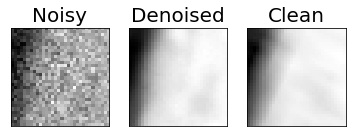

In [11]:
plot_denoise(denoise_model)

## Training a Descriptor Network
In the last section we trained a model that given a noisy patch, outputs a denoised version of it. We hoped that by doing so, we will improve the performance of the second part, which is training a network that outputs the descriptor. As we mentioned, a descriptor is a numerical vector that represents the small images we have. The dataset consists of a large number of small images, which are cropped patches from other larger images. Hence, they represent some local part of a scene. That is why there are no objects represented, only corners or textures. Each of these patches is related to a subset of other patches of the dataset by some kind of geometric transformation (e.g. rotation).  For a given patch, we want the network to output a vector that is close to the vectors of the patches that represent the same local part of a scene, while being far from patches do not represent that local part of a scene.

To do so, we will build a convolutional neural network that takes the input of $32\times32$ and outputs a descriptor of size $128$. For the loss, we use the triplet loss, which takes an anchor patch, a negative patch and a positive patch. The idea is to train the network so the descriptors from the anchor and positive patch have a low distance between them, and the negative and anchor patch have a large distance between them. 

In this cell we generate a triplet network, which is a network formed by three copies of the same network. That means that the descriptor model will compute the descriptor for the input `'a'` (anchor), the same descriptor model (with the same weights) will compute the descriptor for the input `'p'` (positive), and again the same model will compute the descriptor for the input `'n'` (negative). 

**Updated explanation**: Due to the way Keras handles the compile method, it needs a loss as an argument in that compile method. However, our loss is computed in the lambda layer, so we want to minimize the output of that layer. As we want to minimize the output of the Lambda function (in this case the triplet loss), we output as the label in the training_generator a vector of zeros and we compute the mean absolute error of the triplet loss and this vector of zeros. To give you an intuition, what we aim to minimize is
$$  |\text{triplet_loss} - 0| =  |\text{triplet_loss}| = \text{triplet_loss} $$



In [12]:
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


We now train the descriptor model and save the weights afterward.

In [13]:
epochs = 1
### As with the denoising model, we use a loop to save for each epoch 
## #the weights in an external website in case colab stops. 
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)

### If you have a model saved from a previous training session
### Load it in the next line
tmp_model = keras.models.load_model('./models/29epoch_descriptor.h5')
descriptor_model_trip.set_weights(tmp_model.get_weights())
descriptor_model_trip.optimizer = tmp_model.optimizer

for e in range(epochs):
  break
  
  #descriptor_history = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  
  ### Saves optimizer and weights
  #descriptor_model_trip.save('models/' + str(e) + 'epoch_descriptor.h5')
  ### Uploads files to external hosting
  #!curl -F "file=@descriptor.h5" https://file.io


## Generating descriptors files for test data 

To evaluate the performance of out model we will use an existing evaluation code, which is called HPatches benchmark. HPatches benchmark takes as input the descriptors for the test data in a CSV form. So the whole pipeline is represented in the following image.

![](https://i.ibb.co/WcDDf3q/Screenshot-from-2019-02-15-11-17-24.png)

This function generates those files by passing it a descriptor model and a denoising model. It performs a first step of denoising the patches, and a second one of computing the descriptor of the denoised patch. If no denoising model is given (variable set to `None`), the descriptor is computed directly in the noisy patch.

Similarly to the loading data part, you have the denoise_model variable and `use_clean` variable. If `use_clean` is set to True, the CSV generated will be those of the clean patches, even if a denoising model is given. If set to False, then depends on the variable `denoise_model`. If there is no denoise model (`denoise_model=None`), then it will use the noisy patches. If you give a denoising model, then it will compute the CSV for the denoised patches. This can be useful to explore different scenarios (for example, the Upper Bound can be training the descriptor network with clean patches, and testing with clean patches), however you should always report the score when using noisy patches (depending on the approach you develop, you may want to denoise them or not). The official baseline uses the denoised patches. 

In [14]:
generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model, use_clean=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [12:54<00:00, 17.19s/it]


## Evaluating descriptors in HPatches Benchmark
We use HPatches benchmark code to compute the results for our model. 

**Updated**: The necessary code is included in the repository we cloned at the beginning of the code, so we do not need to download any extra data. Also, we simplified the results, so now they only return one value for each of the three tasks.

Now we will perform the evaluation of three different tasks (Verification, Matching and Evaluation) using the CSV files we generated as input and the `hpatches_eval.py` script. We also print the results using the `hpatches_results.py` script. The scripts will return a score for each of the tasks. The metric used is called mean Average Precision, which it uses the Precision of the model. The Precision is defined, for a given number of retrieved elements, as the ratio of correct retrieved elements / number of retrieved elements. [Link to Wikipedia with Precision explanation](https://en.wikipedia.org/wiki/Precision_and_recall). The definition of the three different tasks is taken from the [HPatches paper](https://arxiv.org/pdf/1704.05939.pdf).

In all of the tasks if you use the optional argument `--more_info` in `hpatches_results.py` you can see extra mAP information. However, the important score is the mAP score reported without this flag.

### Verification

Patch verification measures the ability of a descriptor to classify whether two patches are extracted from the same measurement. Now we compute the score of our architecture in this task.




In [17]:
#!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification


Verification task results:
Mean Average Precision is 0.809553


### Matching
Image matching, tests to what extent a descriptor can correctly identify correspondences in two images.

In [15]:
#!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching


Matching task results:
Mean Average Precision is 0.228833




### Retrieval
Retrieval tests how well a descriptor can match a query patch to a pool of patches extracted from many images.

In [16]:
#!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval

Retrieval task results:
Mean Average Precision is 0.516650


## Compressing and saving the CSV files 

This is not necessary for the analysis of the baseline code included in the report. However, we will be hosting a competition in an external website to see who can achieve the highest score. In that case, you will need to submit the CSV files, as the scoring script will be performed in an external server. With that aim, we include here a way to save the files either in your local disc or in your google drive account.

We first compress the directory with all the CSV by using the following command. Remove the `q` option if you want it to output the progress.

In [51]:
!zip -rq descriptors.zip ./out/custom


zip error: Nothing to do! (try: zip -rq descriptors.zip . -i ./out/custom)


The generated .zip is quite large, the method we used for the weights does not work. We have two other methods. First, in the file explorer in the left column we can right-click in the file and then click download. Then, we will see a circle next to the file showing the download progress.

The second way does not require for you to download the files, it save the zip file in your Google Drive account, and you can download it later to your machine if you want. To do so, follow this method (found [here](https://stackoverflow.com/questions/49428332/how-to-download-large-files-like-weights-of-a-model-from-colaboratory)). First run the next cell, and the output will be a link for authentication purposes, and just follow the instructions

In [0]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, 
                          mimetype='application/octet-stream',
                          resumable=True)

  created = drive_service.files().create(body=file_metadata,
                                  media_body=media,
                                  fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created


Now we can use the following function to save the file to your drive account. The second argument is the name of the file we want to save, and the first argument the name that will have in your Drive.

In [4]:
shape = (32, 32, 1)
denoise_model = get_denoise_model(shape)
denoise_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input0 (InputLayer)             (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 640         input0[0][0]                     
__________________________________________________________________________________________________
relu2 (Activation)              (None, None, None, 6 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, None, None, 6 36864       relu2[0][0]                      
_____________________________________

In [5]:
from keras.utils.vis_utils import plot_model
plot_model(denoise_model, to_file='advanced_denoise_model_plot.png', show_shapes=True, show_layer_names=True)